# Práctica Machine Learning

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

## 1. Preparación de los datos. División en train y test

In [2]:
full_df = pd.read_csv('./airbnb-listings-extract.csv', sep=';', decimal='.')

# Filtrar por país (España) y crear una copia independiente
data_spain = full_df[full_df['Country Code'] == 'ES'].copy()

### Filtrar el DataFrame para incluir solamente los registros de Madrid

Para realizar un filtrado efectivo que incluya todas las variantes relevantes de Madrid y sus alrededores (queremos incluir no solo *"Madrid"* sino también otras localidades cercanas como *"Pozuelo de Alarcón", "Boadilla del Monte", "Aravaca"*, entre otras), necesitaremos una **función de filtrado** detallada:

In [3]:
def is_madrid(location):
    madrid_areas = ['madrid', 'pozuelo', 'boadilla del monte', 'aravaca', 'las matas', 'san fernando de henares', 'ventas', 'chueca', 'vallecas', 'villa verde', 'delicias']
    if isinstance(location, str) and any(area in location.lower() for area in madrid_areas):
        return True
    return False

data_madrid = data_spain[data_spain['Smart Location'].apply(is_madrid)]

In [4]:
print(f"Valores únicos en 'Zipcode': {data_madrid['Zipcode'].unique()}") 

Valores únicos en 'Zipcode': ['28007' '28001' '28006' '28009' '28028' '28002' '28016' nan '28046'
 '28039' '28020' '28025' '28041' '28026' '28019' '28018' '28053' '28038'
 '28030' '28010' '28003' '28035' '28008' '28013' '28034' '28040' '28023'
 '28011' '28024' '28044' '28021' '28031' '28032' '28037' '28042' '28224'
 '28017' '28027' '28043' '28033' '28050' '28045' '28012' '28005' '28014'
 '28036' '28004' '28029' '28015' '28105' '28051' '28022' '28055' '28054'
 '28047' '280013' '28094' '28002\n28002' '28850' '28660' '25008' '2015'
 '27004' '28060' '28056' '28290' '28049' '2805' '28052' '20013' '28048'
 '2815' '2802\n28012' 'Madrid 28004' '28830' '2804' '-' '28' '27013'
 '28058' '28051\n28051' '20126']


### Limpiar Códigos Postales
 
- Se eliminan espacios en blanco y caracteres no numéricos.
- Se corrigen códigos postales mal formateados si es posible, o se descartan si no se pueden corregir.
- Conversión de códigos postales a un formato uniforme.

In [5]:
def clean_zipcode(zipcode):
    if pd.isna(zipcode) or not isinstance(zipcode, str):
        return None
    zipcode = zipcode.replace('Madrid', '').strip()
    zipcode = ''.join(filter(str.isdigit, zipcode)).split('\n')[0]
    return zipcode if zipcode.startswith('28') and len(zipcode) == 5 else None

data_madrid.loc[:, 'Zipcode'] = data_madrid['Zipcode'].apply(clean_zipcode)

### Dividir en train y test

In [6]:
from sklearn.model_selection import train_test_split

# Dividimos en Conjuntos de Entrenamiento y Prueba
train, test = train_test_split(data_madrid, test_size=0.2, shuffle=True, random_state=0)
print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('./train.csv', sep=';', decimal='.', index=False)
test.to_csv('./test.csv', sep=';', decimal='.', index=False)

# Cargamos el dataset de train y trabajamos ÚNICAMENTE con él
data_train = pd.read_csv('./train.csv', sep=';', decimal='.')

Dimensiones del dataset de training: (10609, 89)
Dimensiones del dataset de test: (2653, 89)


## 2. Análisis Exploratorio

- Head, describe, dtypes, etc.
- Outliers
- Correlación

**Pasos que vamos a seguir:**
- Visualización de las primeras columnas del DataFrame (`.head()`)
- Descripción rápida de los datos (ver qué atributos son numéricos y cuáles no) (`.info()`)
- Ver un resumen de los atributos numéricos (`.describe()`)
- Ver los valores faltantes de cada columna
- Histograma para analizar cada atributo numérico
- Análisis inicial de la correlación entre variables
- Análisis del dataset por grupos

In [7]:
pd.set_option('display.max_rows', None) # Configurar Pandas para mostrar todas las filas
pd.set_option('display.max_columns', None) # Configurar Pandas para mostrar todas las columnas

In [8]:
data_train.head().T

0  \
ID                                                                       13448215   
Listing Url                                 https://www.airbnb.com/rooms/13448215   
Scrape ID                                                          20170407214119   
Last Scraped                                                           2017-04-08   
Name                                               Luxury Room Madrid Retiro Wifi   
Summary                         This is a new 100sqm 2 bedroom apartment locat...   
Space                           It's a master room with a 160cm real bed with ...   
Description                     This is a new 100sqm 2 bedroom apartment locat...   
Experiences Offered                                                          none   
Neighborhood Overview           The neighborhood is located in the city center...   
Notes                           I love non-smoking, respectful guests. No part...   
Transit                         It's very convenient to move around by bus or ...   
Access                          AC, heating, hot water. Fully equipped kitchen...   
Interaction                     Landlord has quite a busy working schedule but...   
House Rules                     - No smoking, no parties, respectful with neig...   
Thumbnail Url                                                                 NaN   
Medium Url                                                                    NaN   
Picture Url                     https://public.opendatasoft.com/api/v2/catalog...   
XL Picture Url                                                                NaN   
Host ID                                                                  76682878   
Host URL                               https://www.airbnb.com/users/show/76682878   
Host Name                                                                 Hai Wie   
Host Since                                                             2016-06-09   
Host Location                                  Madrid, Community of Madrid, Spain   
Host About                      I'm a Chinese-Spanish real estate consultant l...   
Host Response Time                                                   within a day   
Host Response Rate                                                           70.0   
Host Acceptance Rate                                                          NaN   
Host Thumbnail Url              https://a0.muscache.com/im/pictures/e8de5ad0-6...   
Host Picture Url                https://a0.muscache.com/im/pictures/e8de5ad0-6...   
Host Neighbourhood                                                            NaN   
Host Listings Count                                                           1.0   
Host Total Listings Count                                                     1.0   
Host Verifications                                            email,phone,reviews   
Street                                   Madrid, Comunidad de Madrid 28007, Spain   
Neighbourhood                                                                 NaN   
Neighbourhood Cleansed                                                    Adelfas   
Neighbourhood Group Cleansed                                               Retiro   
City                                                                       Madrid   
State                                                         Comunidad de Madrid   
Zipcode                                                                   28007.0   
Market                                                                     Madrid   
Smart Location                                                      Madrid, Spain   
Country Code                                                                   ES   
Country                                                                     Spain   
Latitude                                                                40.404759   
Longitude                                                               -3.669628   


In [9]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10609 entries, 0 to 10608
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              10609 non-null  int64  
 1   Listing Url                     10609 non-null  object 
 2   Scrape ID                       10609 non-null  int64  
 3   Last Scraped                    10609 non-null  object 
 4   Name                            10609 non-null  object 
 5   Summary                         10223 non-null  object 
 6   Space                           7729 non-null   object 
 7   Description                     10605 non-null  object 
 8   Experiences Offered             10609 non-null  object 
 9   Neighborhood Overview           6645 non-null   object 
 10  Notes                           4036 non-null   object 
 11  Transit                         6617 non-null   object 
 12  Access                          

In [10]:
data_train.describe()

ID     Scrape ID       Host ID  Host Response Rate  \
count  1.060900e+04  1.060900e+04  1.060900e+04         9292.000000   
mean   1.040110e+07  2.017041e+13  3.750421e+07           94.870319   
std    5.496576e+06  4.347861e+00  3.445434e+07           15.140439   
min    1.862800e+04  2.017041e+13  1.745300e+04            0.000000   
25%    5.820149e+06  2.017041e+13  7.823688e+06          100.000000   
50%    1.154498e+07  2.017041e+13  2.746121e+07          100.000000   
75%    1.532662e+07  2.017041e+13  5.763190e+07          100.000000   
max    1.810984e+07  2.017041e+13  1.247534e+08          100.000000   

       Host Acceptance Rate  Host Listings Count  Host Total Listings Count  \
count                   0.0         10607.000000               10607.000000   
mean                    NaN             9.807674                   9.807674   
std                     NaN            27.624553                  27.624553   
min                     NaN             0.000000                   0.000000   
25%                     NaN             1.000000                   1.000000   
50%                     NaN             2.000000                   2.000000   
75%                     NaN             5.000000                   5.000000   
max                     NaN           265.000000                 265.000000   

            Zipcode      Latitude     Longitude  Accommodates     Bathrooms  \
count  10252.000000  10609.000000  10609.000000  10609.000000  10571.000000   
mean   28015.454936     40.420452     -3.697172      3.187859      1.256409   
std       20.158532      0.020082      0.023733      1.996570      0.611445   
min    28001.000000     40.331888     -3.863907      1.000000      0.000000   
25%    28005.000000     40.410002     -3.707759      2.000000      1.000000   
50%    28012.000000     40.418568     -3.701573      2.000000      1.000000   
75%    28017.000000     40.427649     -3.693854      4.000000      1.000000   
max    28850.000000     40.562736     -3.526821     16.000000      8.000000   

           Bedrooms          Beds  Square Feet         Price  Weekly Price  \
count  10595.000000  10576.000000   408.000000  10601.000000   2707.000000   
mean       1.293535      1.989883   350.269608     65.693708    368.510528   
std        0.831415      1.531881   499.223019     56.138300    190.596962   
min        0.000000      1.000000     0.000000      9.000000     70.000000   
25%        1.000000      1.000000     0.000000     30.000000    200.000000   
50%        1.000000      2.000000    86.000000     52.000000    350.000000   
75%        2.000000      2.000000   592.000000     80.000000    490.000000   
max       10.000000     16.000000  2691.000000    875.000000    995.000000   

       Monthly Price  Security Deposit  Cleaning Fee  Guests Included  \
count    2660.000000       4538.000000   6262.000000     10609.000000   
mean     1334.361654        182.956148     29.681731         1.575832   
std       886.872846        107.625972     26.062273         1.081050   
min       250.000000         70.000000      4.000000         1.000000   
25%       700.000000        100.000000     15.000000         1.000000   
50%      1200.000000        150.000000     25.000000         1.000000   
75%      1666.000000        200.000000     35.000000         2.000000   
max      6990.000000        990.000000    500.000000        15.000000   

       Extra People  Minimum Nights  Maximum Nights  Has Availability  \
count  10609.000000    10609.000000    10609.000000               0.0   
mean       7.494392        3.014045      980.265906               NaN   
std       10.873778       12.840494     9908.895741               NaN   
min        0.000000        1.000000        1.000000               NaN   
25%        0.000000        1.000000      365.000000               NaN   
50%        5.000000        2.000000     1125.000000               NaN   
75%       15.000000        3.000000     1125.000000               NaN   
max     

**Columnas que parecen de menor interés por el tipo de dato o la información que contiene:**

*   ID
*   Listing Url, Scrape ID, Last Scraped
*   Name, Summary, Space, Description, Notes, Neighbourhood Overview, Transit, Access, Interaction, House Rules
*   Thumbnail Url, Medium Url, Picture Url, XL Picture Url, Host Thumbnail Url, Host Picture Url
*   Host URL, Host About
*   Host Acceptance Rate, Has Availability
*   Host Total Listings Count
*   Neighbourhood
*   Calendar last Scraped
*   License, Jurisdiction Names
*   Geolocation
    
La exclusión de estas columnas se fundamenta en la relevancia, la calidad de los datos, y la alineación con los objetivos del análisis. El eliminado de características se realizará más adelante. 

### Número de Valores Faltantes por Columna

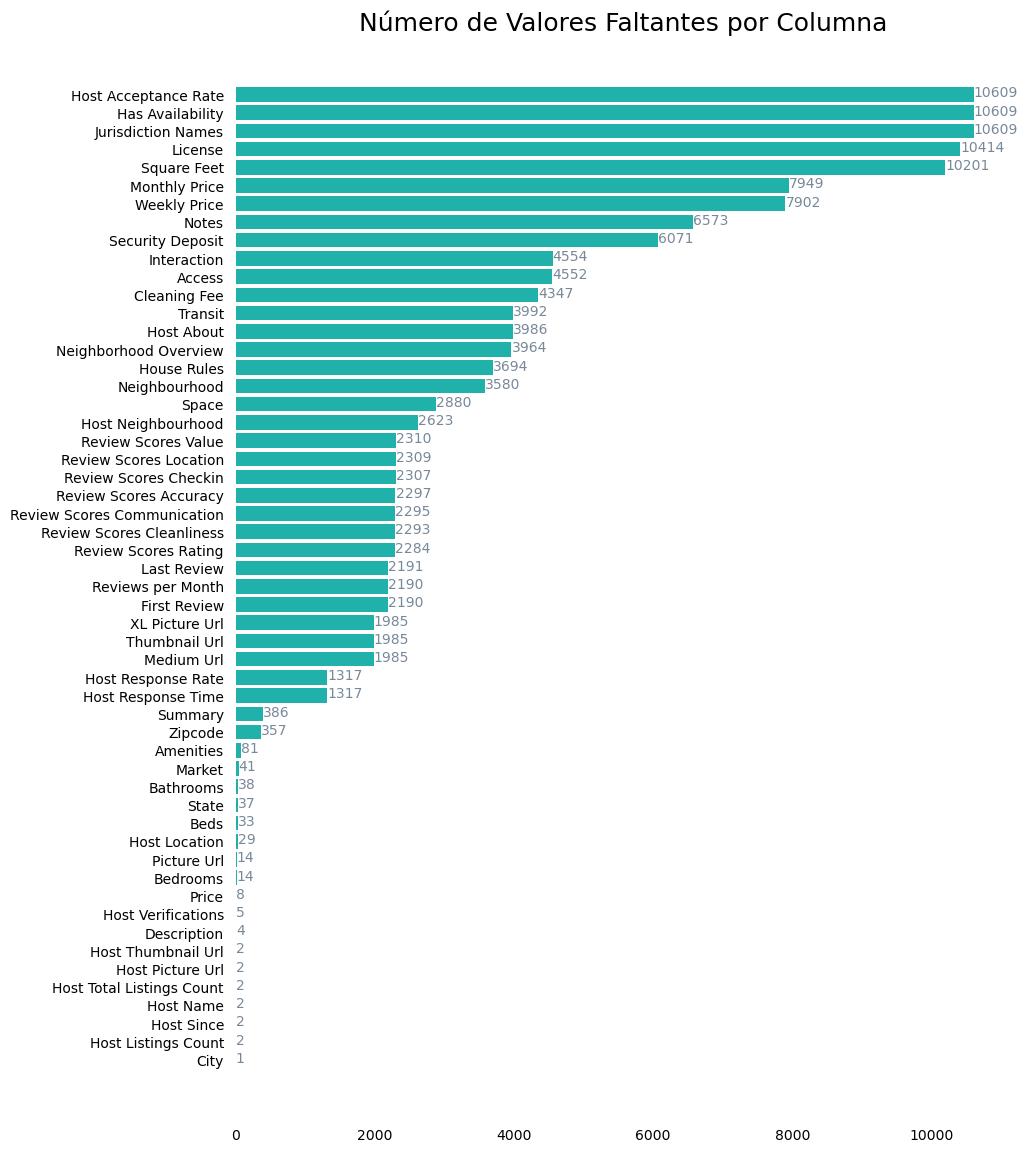

In [11]:
missing_values = data_train.isnull().sum()

# Filtra las columnas que tienen valores faltantes, ordenados de mayor a menor
missing_values_filtered = missing_values[missing_values > 0].sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(10, 14))

ax.barh(missing_values_filtered.index, missing_values_filtered.values, color='lightseagreen')

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=5)

# Valor barra
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='500',
             color='lightslategrey', va='center')
    
ax.set_title('Número de Valores Faltantes por Columna', fontsize=18, fontweight='500')
plt.show()

### Visualización Histogramas

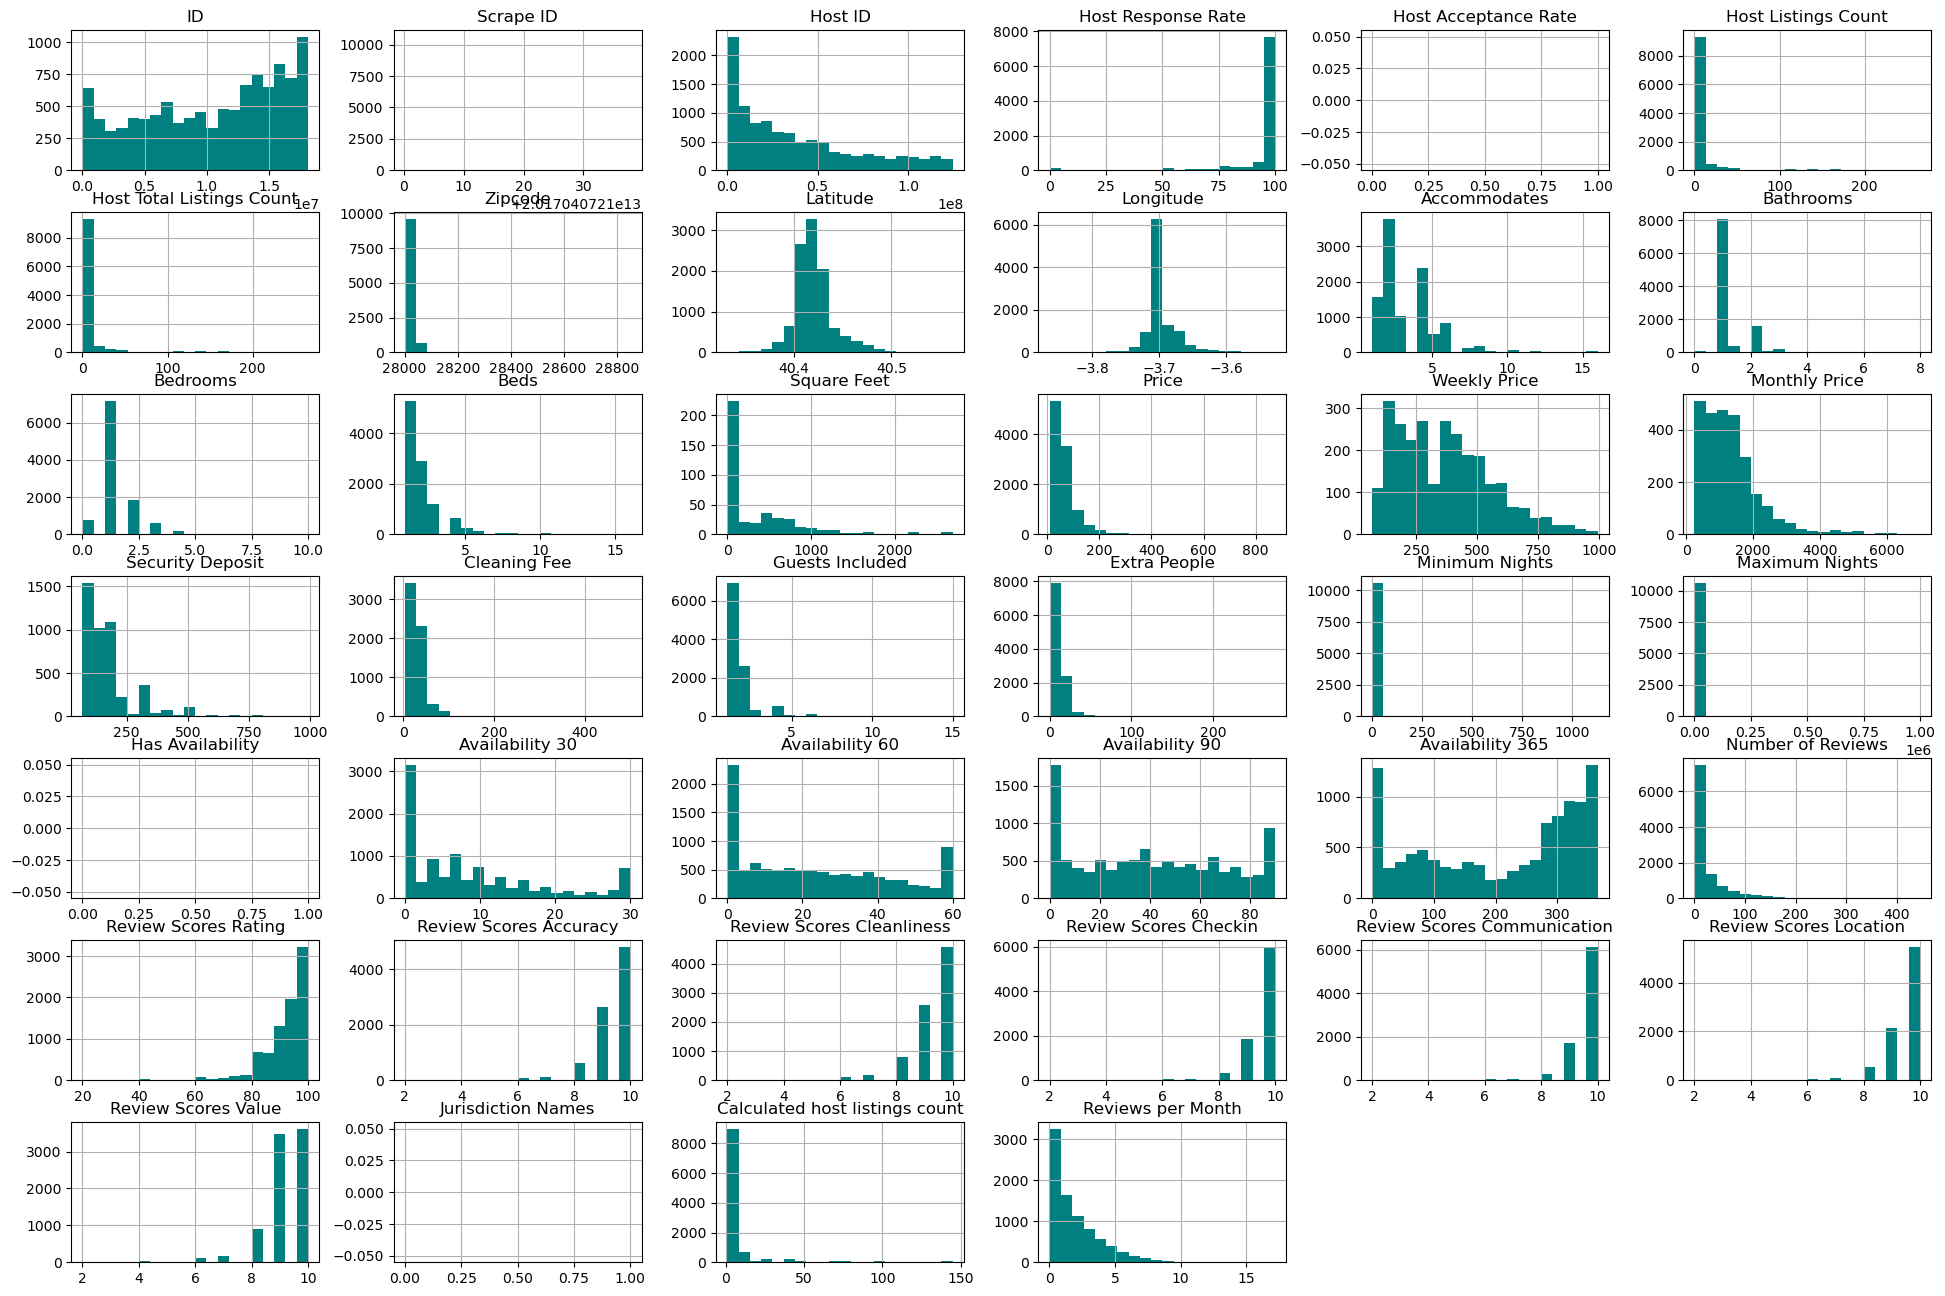

In [12]:
data_train.hist(bins=20, figsize=(24,16), color='teal')
plt.show()

**Sesgo en la distribución:** Muchas de las variables presentan una distribución sesgada, lo que significa que la mayoría de los valores se concentran en un extremo de la distribución. Por ejemplo, `Security Deposit`, `Extra People`, `Minimum Nights`, `Maximum Nights` y `Cleaning Fee` muestran un sesgo positivo claro, con muchos valores bajos y una cola larga hacia valores más altos.

**Variables con valores cero predominantes:** Algunas variables como `Square Feet`, `Review Scores Rating`, y `Number of Reviews` tienen una cantidad significativa de ceros o valores bajos, lo que podría sugerir que muchos listados no proporcionan esta información o que hay un gran número de listados nuevos o menos populares.

**Outliers:** Las columnas `Price`, `Security Deposit`, `Cleaning Fee`, `Number of Reviews`, `Minimum Nights`, `Maximum Nights` y `Extra People` parecen tener valores atípicos (por la presencia de barras individuales alejadas de la mayoría de los datos). También deberíamos analizar las columnas `Bathrooms`, `Bedrooms` y `Beds`.

**Gráficas en blanco:** Las gráficas que aparecen en blanco o prácticamente sin datos visibles pueden sugerir valores constantes o únicos, valores mayoritariamente ceros, escalas desbalanceadas o datos faltantes.

**Columnas numéricas que podrían estar relacionadas con el precio:**

- *Cleaning Fee y Security Deposit*: Alojamientos más caros podrían tener tasas de limpieza y depósitos de seguridad más altos.

- *Accommodate, Bedrooms, Bathrooms, Beds*: Estas características suelen estar fuertemente relacionadas con el precio, ya que indican el tamaño y la capacidad del alojamiento.

- *Minimum Nights y Maximum Nights*: Podrían influir en el precio en términos de descuentos por estancias largas o políticas de estancia mínima.

- *Review Scores Rating y subcategorías de Review Scores*: Las puntuaciones más altas podrían permitir a los anfitriones cobrar más por sus alojamientos debido a la percepción de mayor calidad o experiencia.

Vamos a comprobarlo...

### Análisis inicial de la correlación

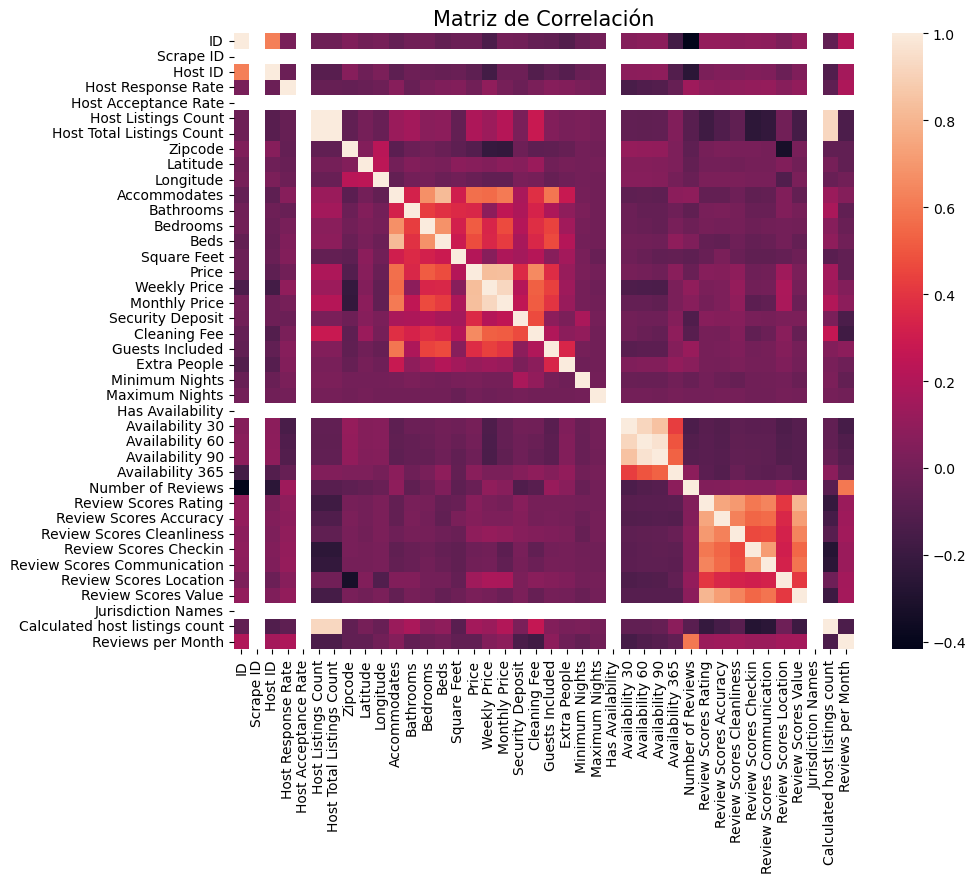

In [13]:
# Calculamos la matriz de correlación para data_train
corr_matrix = data_train.select_dtypes(include=[np.number]).corr()

# Gráfico de calor para la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix)
plt.title('Matriz de Correlación', fontsize=15)
plt.show()

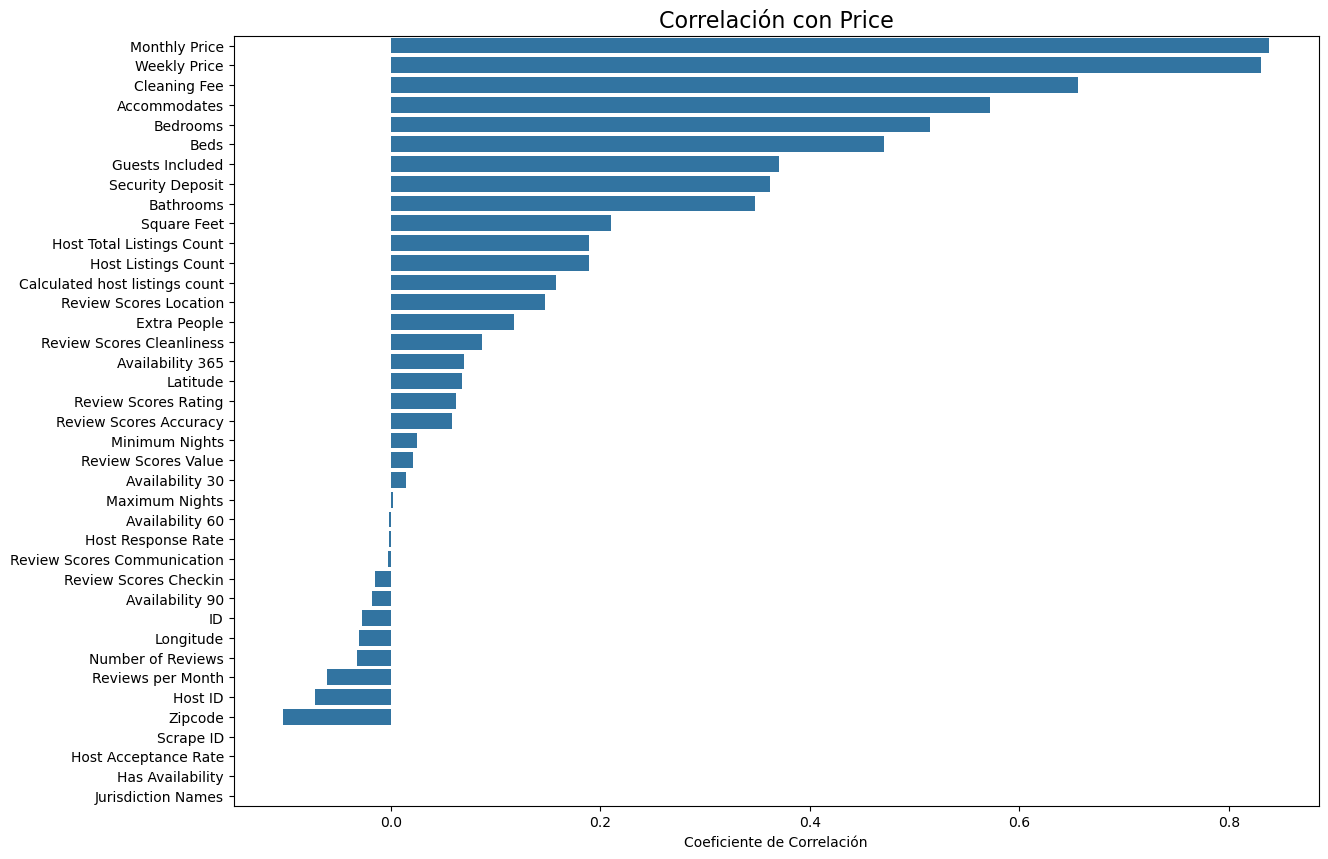

In [14]:
# Gráfico de las correlaciones de la columna 'Price' con las demás
corr_with_price = corr_matrix["Price"].sort_values(ascending=False).drop('Price')  # Excluir la propia correlación de 'Price' con sí misma

plt.figure(figsize=(14, 10))
sns.barplot(x=corr_with_price.values, y=corr_with_price.index)
plt.title('Correlación con Price', fontsize=16)
plt.xlabel('Coeficiente de Correlación')
plt.ylabel('')
plt.show()

Si queremos preparar un modelo de predicción de precios, vamos a **priorizar las características que tienen una correlación más fuerte con la variable objetivo** (`Price`). Sin embargo, tendremos en cuenta que **la correlación no implica causalidad** y que las correlaciones bajas no necesariamente significan que una característica no sea importante; podría influir en el precio de manera no lineal o interactuar con otras variables de formas que no se capturan con la correlación lineal simple. Algunas variables con baja correlación o correlación negativa podrían todavía ser útiles al combinarse con otras o al formar interacciones en el modelo.

### Analizando el Dataset por Grupos

1. Datos relacionados con la información del anfitrión
2. Datos relacionadas con la información geográfica
3. Características directas del alojamiento
4. Datos relacionados con la información de precios y costos adicionales
5. Datos relacionados con las restricciones de reserva y la disponibilidad
6. Datos relacionados con métricas de calidad y popularidad

In [15]:
# Función para crear histogramas de múltiples columnas
def plot_histograms(df, columns, bins=20, color='royalblue', figsize=(20, 5)):
    fig, axs = plt.subplots(nrows=1, ncols=len(columns), figsize=figsize)

    # Asegura que axs sea un array, incluso con una sola columna
    if len(columns) == 1:
        axs = [axs]

    # Iterar a través de las columnas y los ejes para crear histogramas
    for col, ax in zip(columns, axs):
        df[col].dropna().hist(bins=bins, ax=ax, color=color)
        ax.set_title(col)
        ax.set_xlabel('Valor')
        ax.set_ylabel('Frecuencia')
        
        # Elimina la cuadrícula y los bordes
        ax.grid(False)
        for spine in ax.spines.values():
            spine.set_visible(False)

    plt.tight_layout()
    plt.show()

In [16]:
from pandas.plotting import scatter_matrix

# Función para crear una matriz de dispersión para atributos seleccionados
def plot_scatter_matrix(df, attributes, figsize=(14, 10), diagonal='kde',
                        color='royalblue', alpha=0.7, s=100, edgecolors='white',
                        suptitle='Matriz de Dispersión'):
   
    sns.set(style="whitegrid")
    scatter_matrix(df[attributes], figsize=figsize, diagonal=diagonal,
                   color=color, alpha=alpha, s=s, edgecolors=edgecolors)
    
    plt.suptitle(suptitle, size=16)
    plt.subplots_adjust(top=0.94, wspace=0.05, hspace=0.1)
    plt.show()

### 1. Datos relacionados con la información del anfitrión

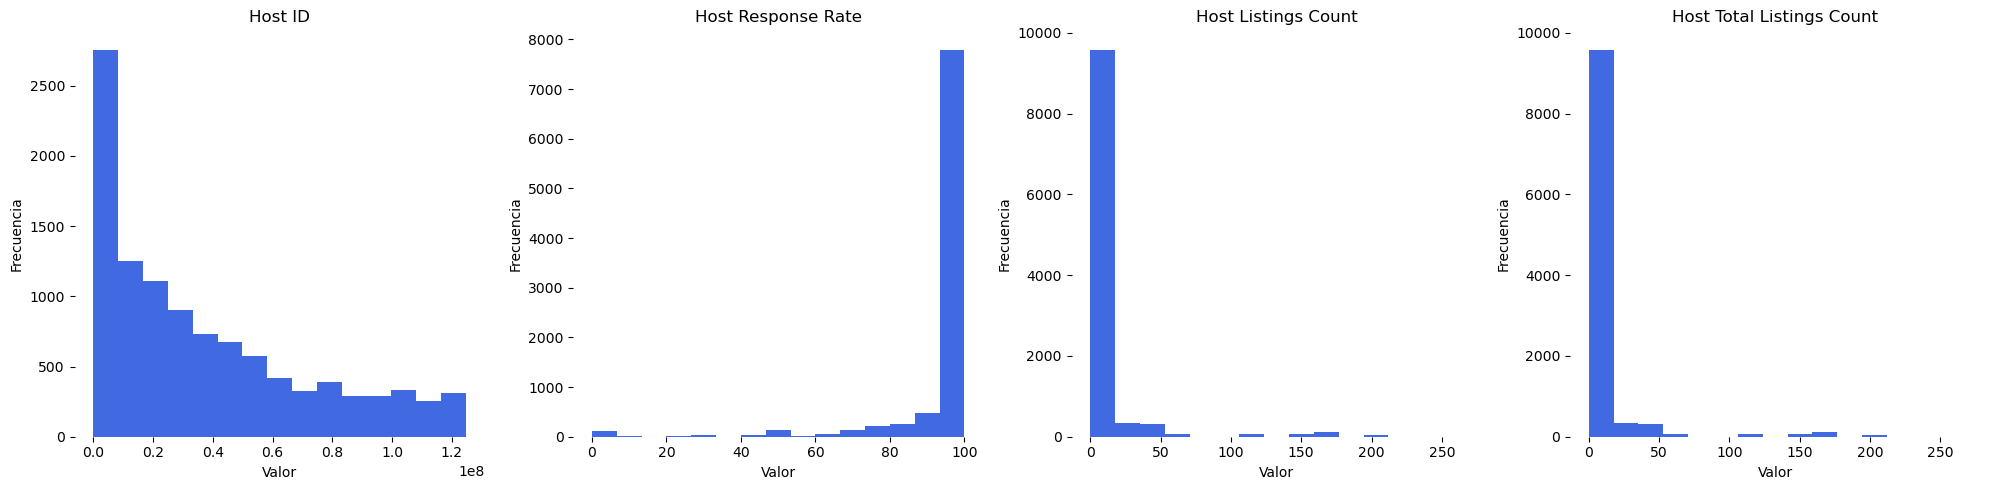

In [17]:
columns_to_include = ['Host ID', 'Host Response Rate', 'Host Listings Count', 'Host Total Listings Count']
plot_histograms(data_train, columns_to_include, bins=15, figsize=(20, 5))

In [18]:
print(data_train['Host Response Time'].value_counts())

Host Response Time
within an hour        5698
within a few hours    2168
within a day          1217
a few days or more     209
Name: count, dtype: int64


In [19]:
print(data_train['Host Listings Count'].describe())

count    10607.000000
mean         9.807674
std         27.624553
min          0.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        265.000000
Name: Host Listings Count, dtype: float64


In [20]:
# Analizamos los registros que tienen un valor superior a 100 en 'Host Listings Count'
high_listing_hosts = data_train[data_train['Host Listings Count'] > 100]
host_counts = high_listing_hosts['Host Name'].value_counts()
print(f"Número de 'Host Name' únicos con más de 100 listados: {host_counts.shape[0]}")
print(f"Cantidad de veces que cada anfitrión aparece con más de 100 listados: {host_counts}")

# Agrupamos por "Host Name" y obtenemos el valor máximo de "Host Listings Count" para cada grupo
host_listings_max = high_listing_hosts.groupby('Host Name')['Host Listings Count'].max()
print(f"Valor máximo de cada {host_listings_max}")

Número de 'Host Name' únicos con más de 100 listados: 6
Cantidad de veces que cada anfitrión aparece con más de 100 listados: Host Name
Raquel          118
Erasmo´S         75
Spain Select     65
Javier           53
Teresa            3
Loic              1
Name: count, dtype: int64
Valor máximo de cada Host Name
Erasmo´S        114.0
Javier          207.0
Loic            265.0
Raquel          164.0
Spain Select    142.0
Teresa          136.0
Name: Host Listings Count, dtype: float64


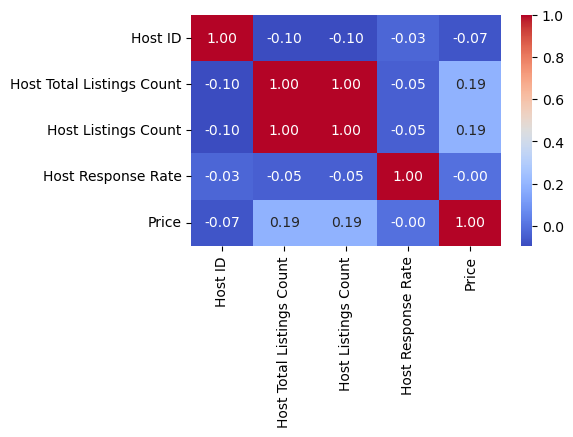

In [21]:
# Correlación entre variables
columns_of_interest = ['Host ID', 'Host Total Listings Count','Host Listings Count','Host Response Rate','Price']
correlation_matrix = data_train[columns_of_interest].corr()

plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show()

La matriz de correlación sugiere que las características del anfitrión tienen una ***relación débil con el precio***. La *correlación negativa moderada* entre el tiempo de respuesta del anfitrión y su tasa de respuesta resalta que los anfitriones que tardan más en responder tienden a tener tasas de respuesta más bajas. A pesar de las **bajas correlaciones generales**, es importante valorar la información única que cada variable aporta antes de su posible exclusión.

Con una **correlación máxima de 0.19** entre el precio y el número de listados del anfitrión, **el impacto directo de las características del anfitrión en el precio es limitado**. No obstante, vamos a explorar otras características más allá de las del anfitrión para determinar cuáles influirán significativamente en el precio y cuáles podrán ser omitidas en el modelado final.

<div class = "alert alert-success">
Quitamos del análisis *Host Total Listings Count*, ya que presenta los mismos datos que *Host Listings Count*.
</div>

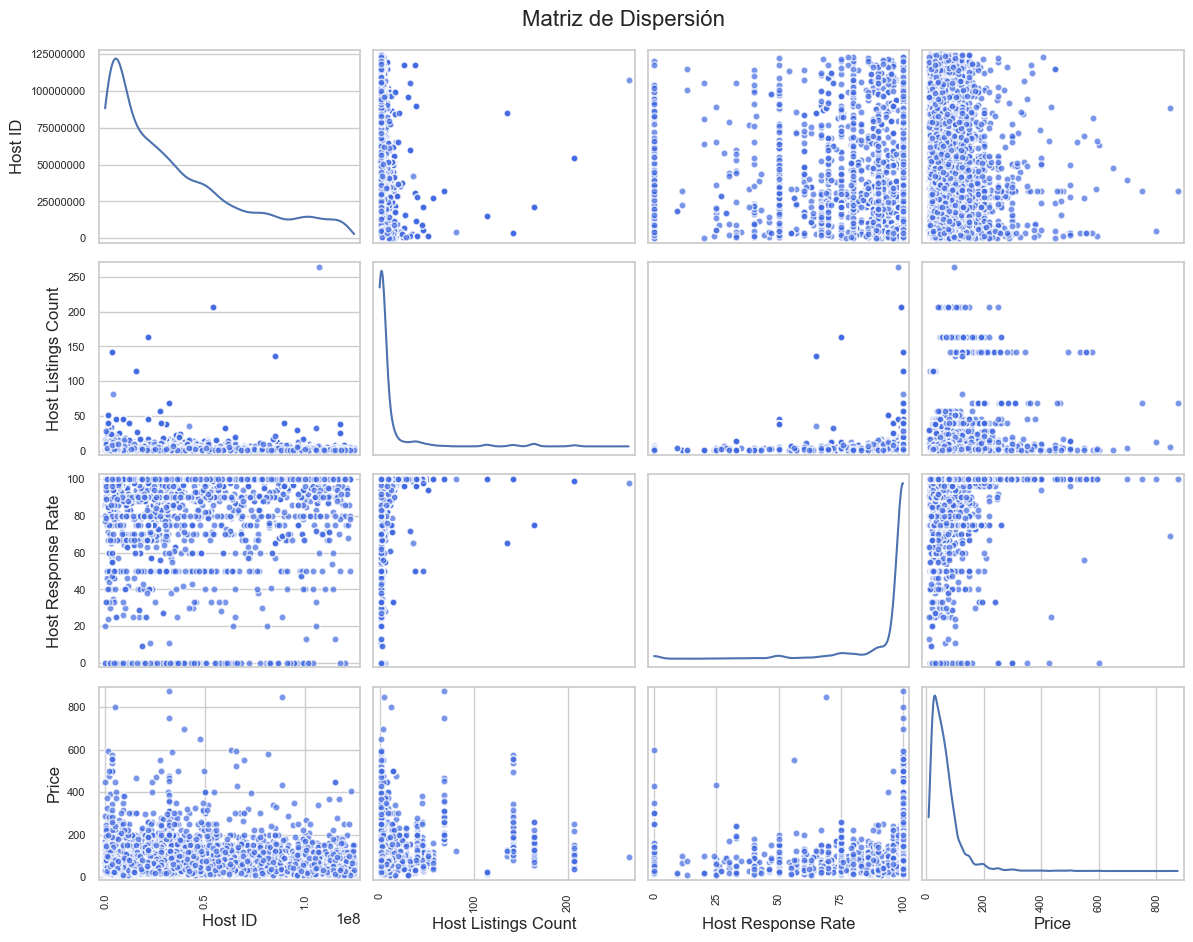

In [22]:
# Gráfico de dispersión
attributes = ['Host ID', 'Host Listings Count', 'Host Response Rate', 'Price']
plot_scatter_matrix(data_train, attributes)

### Conclusiones

**Columnas que no se incluirán en el modelo:**
-  `Host ID`, correlación baja; poco o ningún efecto lineal sobre el precio
-  `Host Name`, puede haber diferentes anfitriones con el mismo nombre y no es considerada una variable que esté relacionada con el precio
-  `Host Location`, información menos relevante o inespecífica
-  `Host Neighbourhood`, información menos relevante
-  `Host About`, requeriría procesamiento o análisis de texto
-  `Host Total Listings Count`, tiene los mismos valores que `Host Listings Count` *(corr 1)*
-  `Experiences Offered`, todos los registros tienen el valor *'none'* (no aporta información)

**Columnas de texto/categóricas que se convertirán a categorías numéricas:**
-  `Host Response Time`, se asignarán valores del 1-4 al tratarse de una categoría ordinal
-  `Host Verification`, indicará la cantidad total de verificaciones

**Columnas numéricas que se mantienen:**
-  `Host Listings Count`, se aplicará transformación; cola larga

### 2. Datos relacionados con la información geográfica

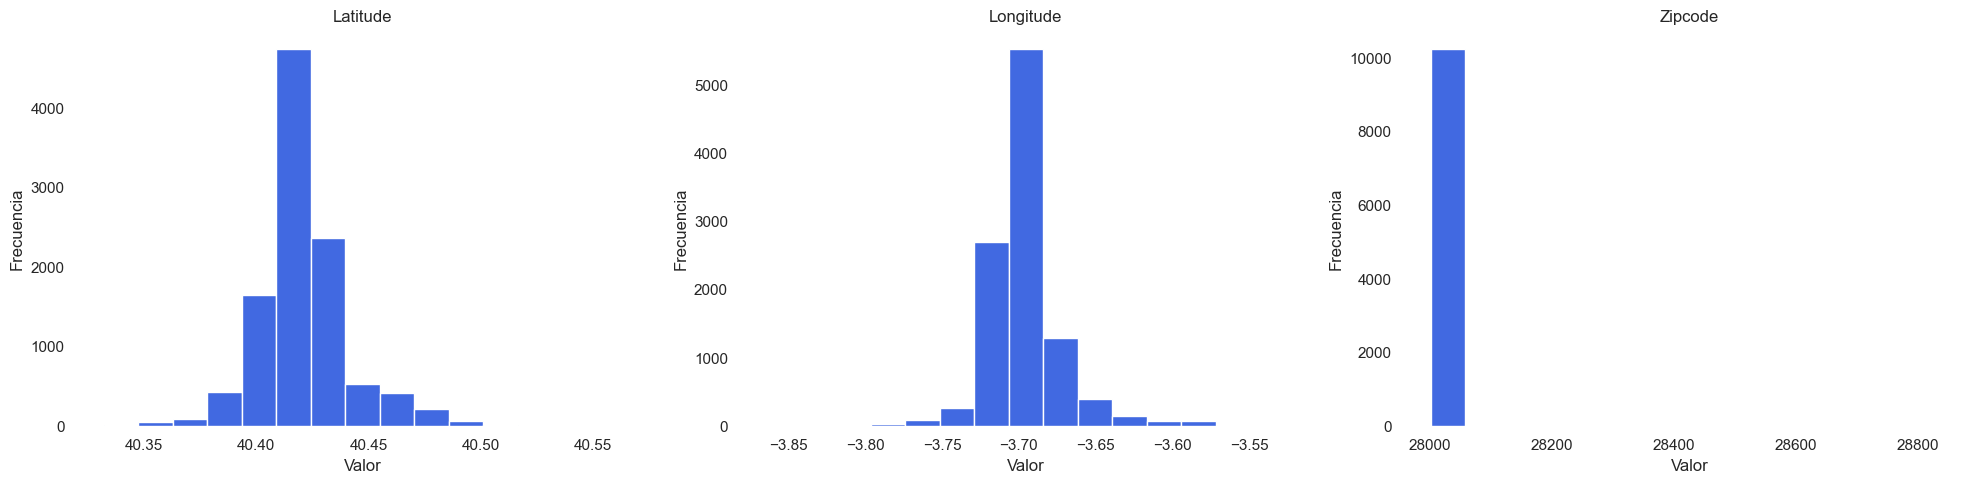

In [23]:
columns_to_include =['Latitude', 'Longitude' ,'Zipcode']
plot_histograms(data_train, columns_to_include, bins=15, figsize=(20, 5))

In [24]:
data_train[['City', 'State', 'Country Code', 'Country']].describe()

City                State Country Code Country
count    10608                10572        10609   10609
unique      19                   15            1       1
top     Madrid  Comunidad de Madrid           ES   Spain
freq     10565                 8520        10609   10609

In [25]:
data_train[['Neighbourhood Cleansed', 'Neighbourhood Group Cleansed']].describe()

Neighbourhood Cleansed Neighbourhood Group Cleansed
count                   10609                        10609
unique                    126                           21
top               Embajadores                       Centro
freq                     1471                         5436

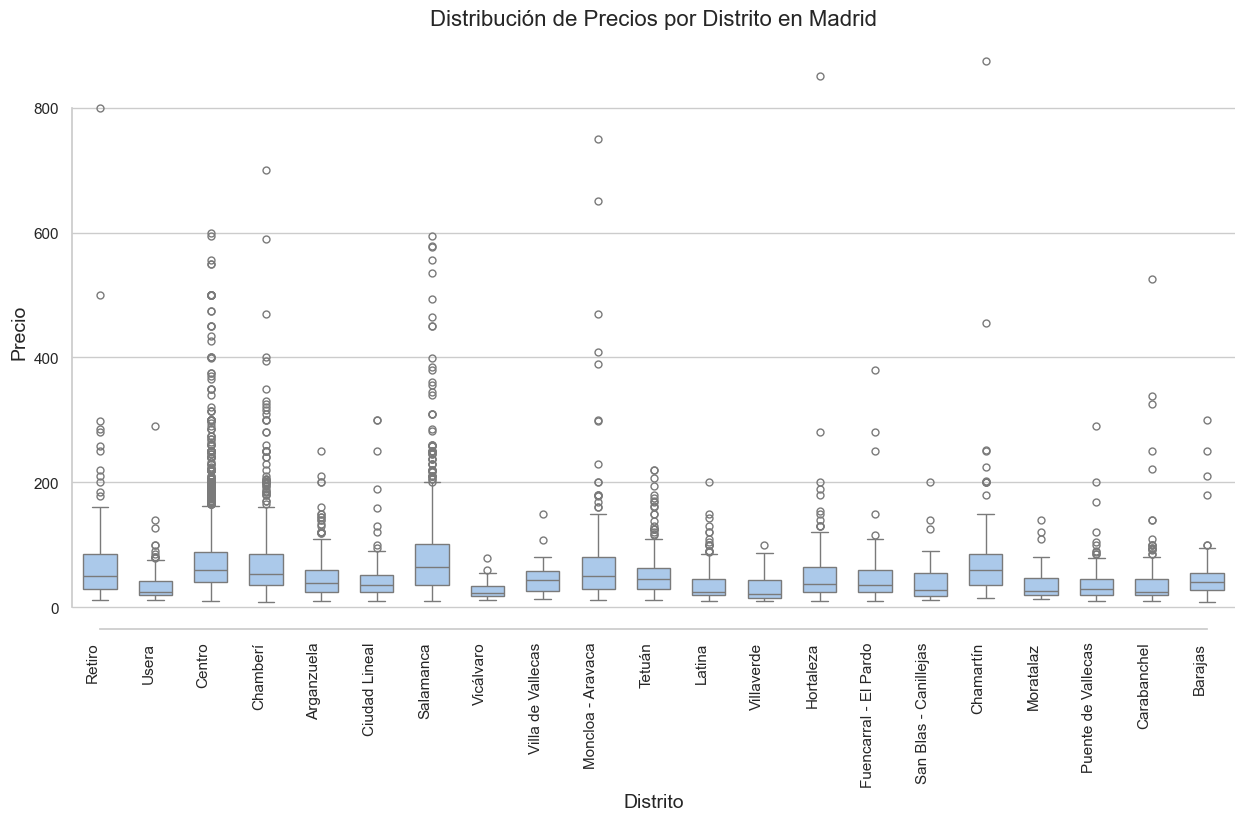

In [26]:
# Creamos un boxplot de precios por distrito
sns.set(style="whitegrid", palette="pastel")

plt.figure(figsize=(15, 7))
sns.boxplot(x='Neighbourhood Group Cleansed', y='Price', data=data_train, width=0.6, fliersize=5)

plt.title('Distribución de Precios por Distrito en Madrid', fontsize=16, weight=500)
plt.xlabel('Distrito', fontsize=14)
plt.ylabel('Precio', fontsize=14)
plt.xticks(rotation=90, ha='right')

sns.despine(trim=True)
plt.subplots_adjust(top=0.96)
plt.show()

Tras la revisión anterior, decido mantener temporalmente tanto la columna `Neighbourhood Cleansed` (barrios) como `Neighbourhood Group Cleansed` (distritos) en el análisis. Posteriormente, en función de los resultados obtenidos en análisis más avanzados, como la correlación entre variables y otros métodos estadísticos, tomaré una decisión informada sobre cuál de las dos columnas es más pertinente mantener para el análisis final (o ninguna).

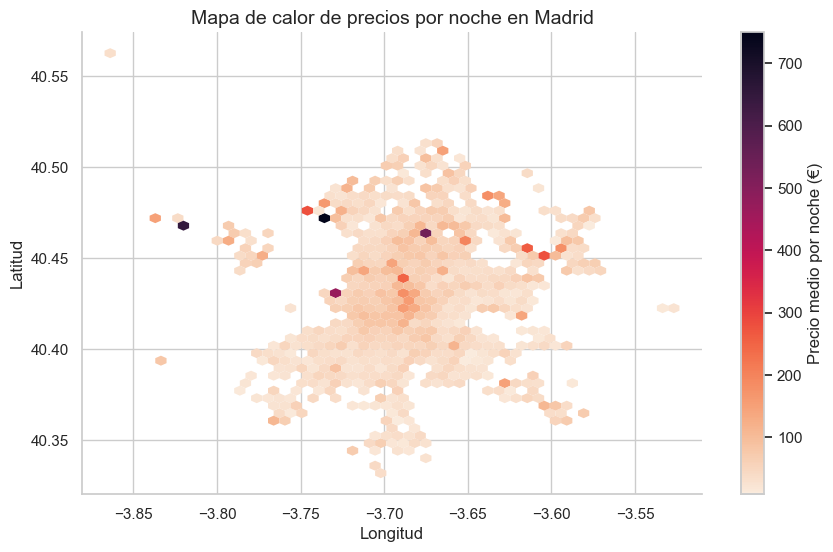

In [27]:
np.random.seed(0)

def safe_mean(data):
    if len(data) == 0:
        return np.nan  # Retorna NaN si el conjunto está vacío
    return np.nanmean(data)  # Utiliza nanmean para ignorar los NaN en el cálculo

plt.figure(figsize=(10, 6))

hb = plt.hexbin(data_train['Longitude'], data_train['Latitude'], 
                C=data_train['Price'], gridsize=50, cmap='rocket_r', 
                reduce_C_function=safe_mean, edgecolors='none')

cb = plt.colorbar(hb, label='Precio medio por noche (€)')

plt.xlabel('Longitud', fontsize=12, fontweight='light')
plt.ylabel('Latitud', fontsize=12, fontweight='light')
plt.title('Mapa de calor de precios por noche en Madrid', fontsize=14, fontweight='500')

sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

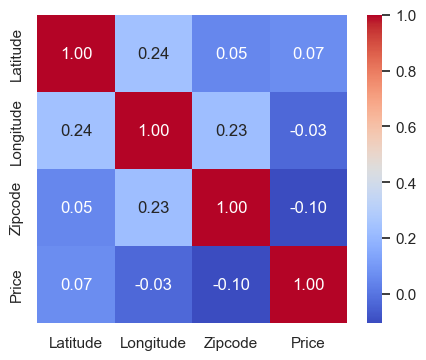

In [28]:
correlation_matrix = data_train[['Latitude','Longitude','Zipcode','Price']].corr()
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show()

### Conclusiones

**Nuevas columnas que se plantean:**
- `LatLongInteraction`, refleja la multiplicacion de longitud y latitud 

**Columnas que no se incluirán en el modelo:**
-  `Neighbourhood`, 33,7% datos faltantes e información redundante
-  `Stree, City, State, Country Code, Country, Market, Smart Location`, información no relevante
-  `Latitude, Longitude`, información redundante al tener *LatLongInteraction*
-  `Zipcode`, la información geográfica relevante ya está cubierta por otra columna y el código postal numérico no aporta valor significativo al modelo

**Columnas de texto/categóricas que se convertirán a categorías numéricas:**
-  `Neighbourhood Cleansed` 
-  `Neighbourhood Group Cleansed`

### 3. Características directas del alojamiento

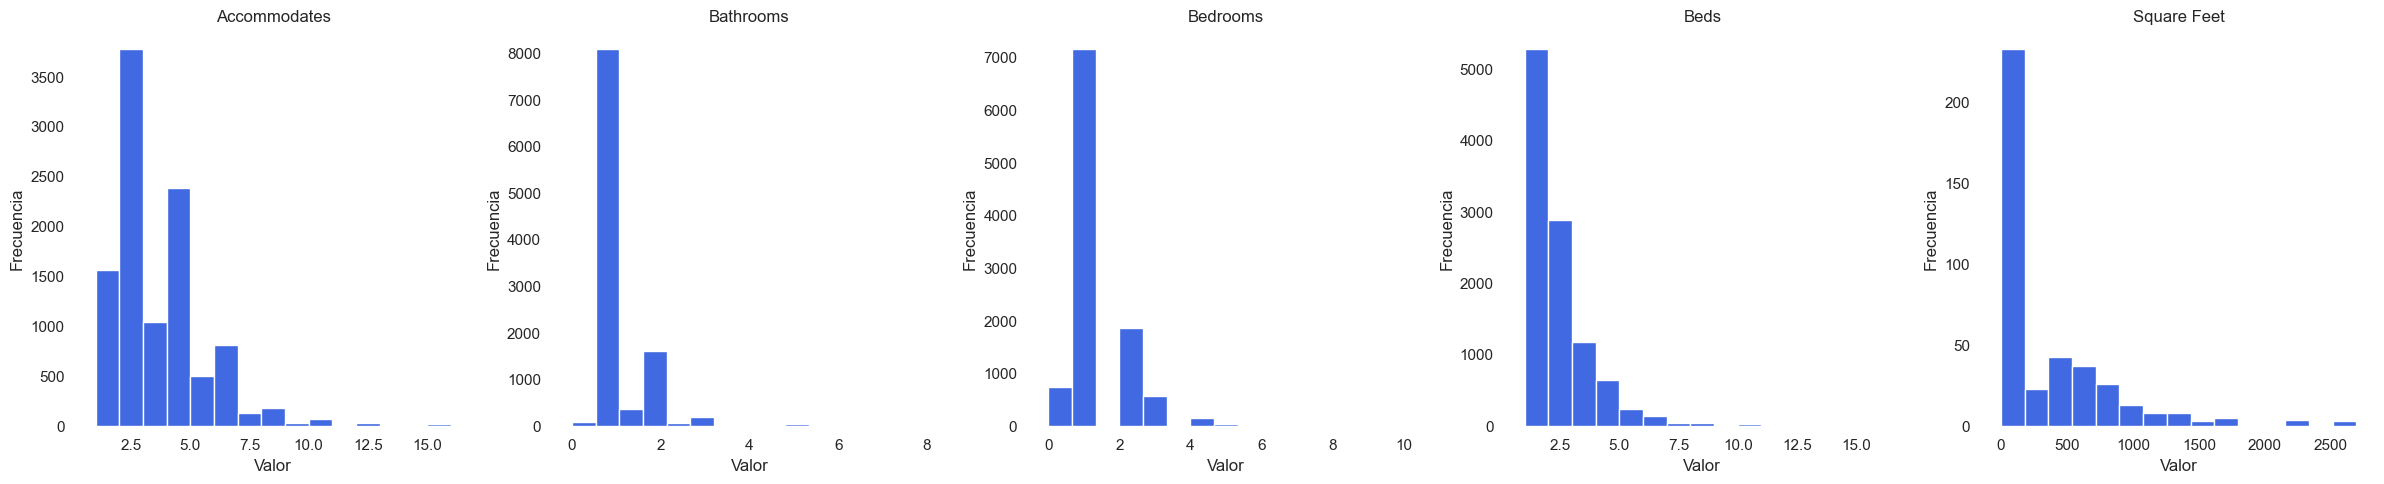

In [29]:
columns_to_include = ['Accommodates','Bathrooms','Bedrooms','Beds','Square Feet']
plot_histograms(data_train, columns_to_include, bins=15, figsize=(24, 5))

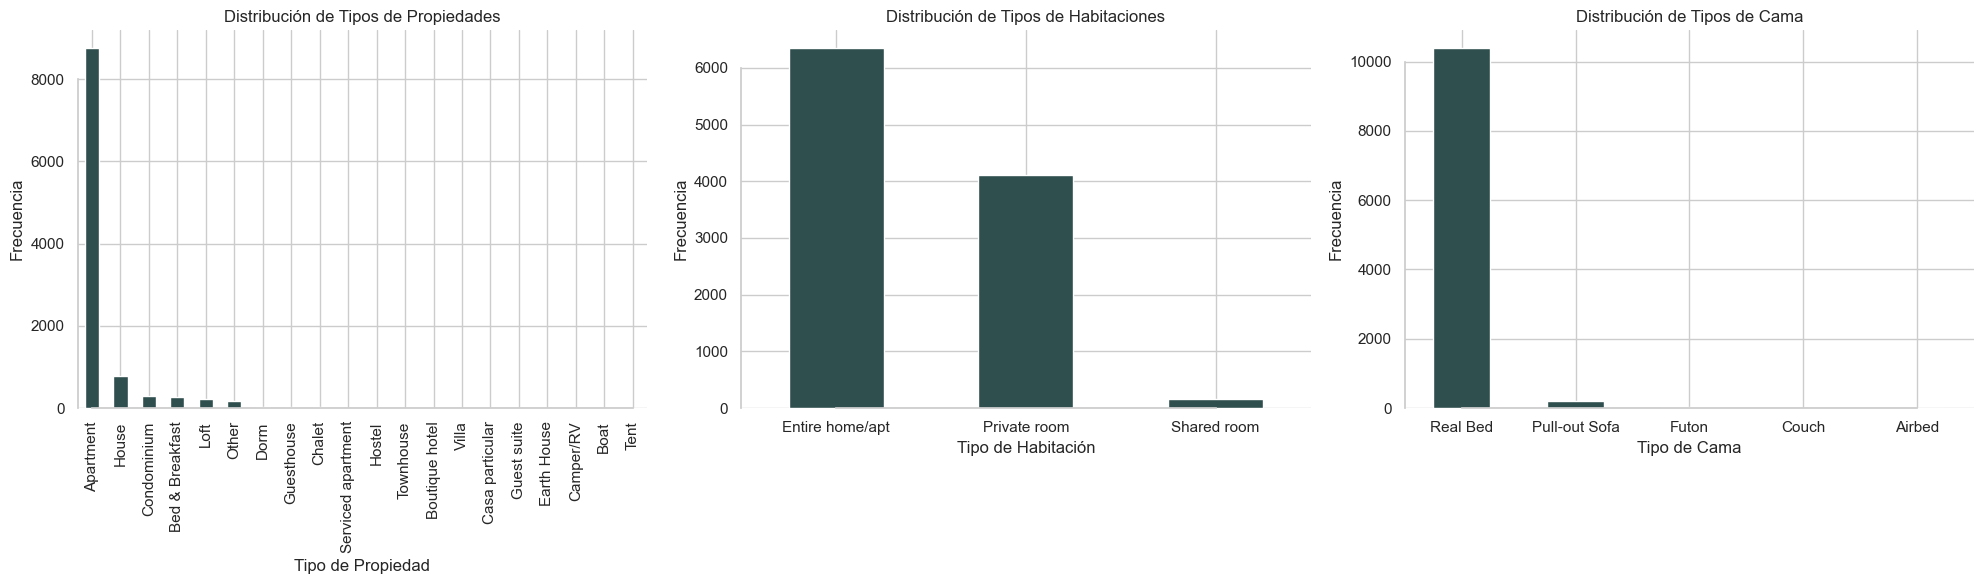

In [30]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# Gráfico de barras para 'Property Type'
data_train['Property Type'].value_counts().plot(kind='bar', color='darkslategray', ax=axes[0])
axes[0].set_title('Distribución de Tipos de Propiedades')
axes[0].set_xlabel('Tipo de Propiedad')
axes[0].set_ylabel('Frecuencia')
axes[0].tick_params(axis='x', rotation=90)

# Gráfico de barras para 'Room Type'
data_train['Room Type'].value_counts().plot(kind='bar', color='darkslategray', ax=axes[1])
axes[1].set_title('Distribución de Tipos de Habitaciones')
axes[1].set_xlabel('Tipo de Habitación')
axes[1].set_ylabel('Frecuencia')
axes[1].tick_params(axis='x', rotation=0) 

# Gráfico de barras para 'Bed Type'
data_train['Bed Type'].value_counts().plot(kind='bar', color='darkslategray', ax=axes[2])
axes[2].set_title('Distribución de Tipos de Cama')
axes[2].set_xlabel('Tipo de Cama')
axes[2].set_ylabel('Frecuencia')
axes[2].tick_params(axis='x', rotation=0)

sns.despine(trim=True)
plt.tight_layout()
plt.show()

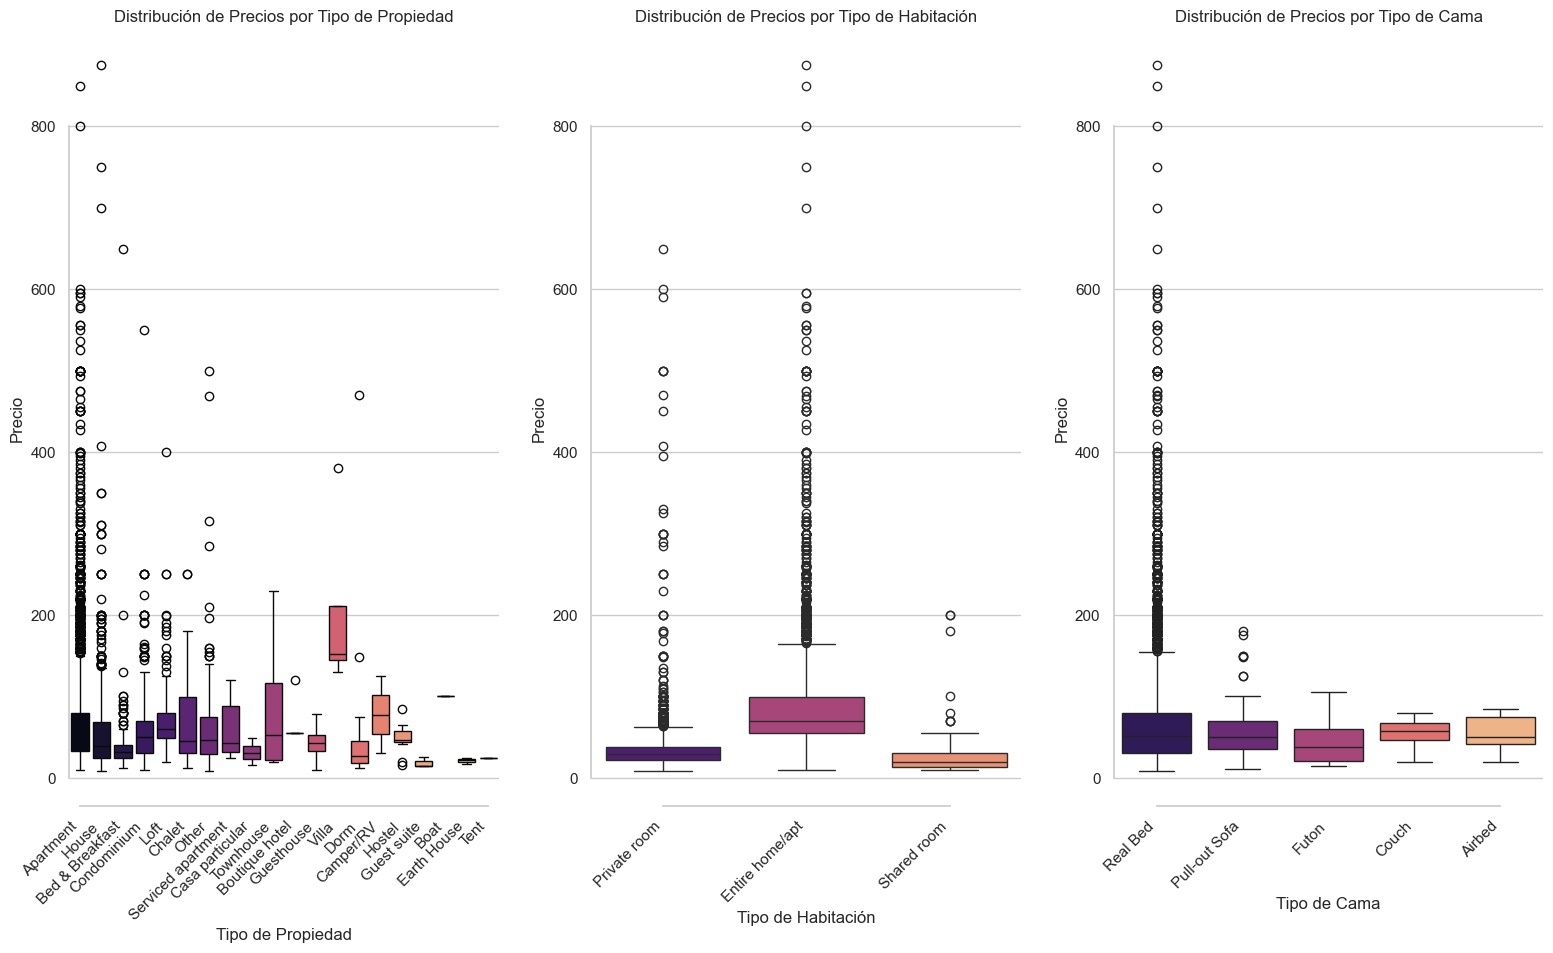

In [31]:
sns.set_style("whitegrid") 
plt.figure(figsize=(16, 10))

# Gráfico de cajas para 'Property Type' y 'Price'
plt.subplot(1, 3, 1)
sns.boxplot(x='Property Type',y='Price',data=data_train,palette="magma",hue='Property Type',legend=False)
plt.xticks(rotation=45, ha='right') 
plt.title('Distribución de Precios por Tipo de Propiedad')
plt.xlabel('Tipo de Propiedad')
plt.ylabel('Precio')

# Gráfico de cajas para 'Room Type' y 'Price'
plt.subplot(1, 3, 2)
sns.boxplot(x='Room Type',y='Price',data=data_train,palette="magma",hue='Room Type',legend=False)
plt.xticks(rotation=45, ha='right')
plt.title('Distribución de Precios por Tipo de Habitación')
plt.xlabel('Tipo de Habitación')
plt.ylabel('Precio')

# Gráfico de cajas para 'Bed Type' y 'Price'
plt.subplot(1, 3, 3)
sns.boxplot(x='Bed Type',y='Price',data=data_train,palette="magma",hue='Bed Type',legend=False)
plt.xticks(rotation=45, ha='right')
plt.title('Distribución de Precios por Tipo de Cama')
plt.xlabel('Tipo de Cama')
plt.ylabel('Precio')

sns.despine(trim=True)
plt.tight_layout(pad=2)
plt.show()

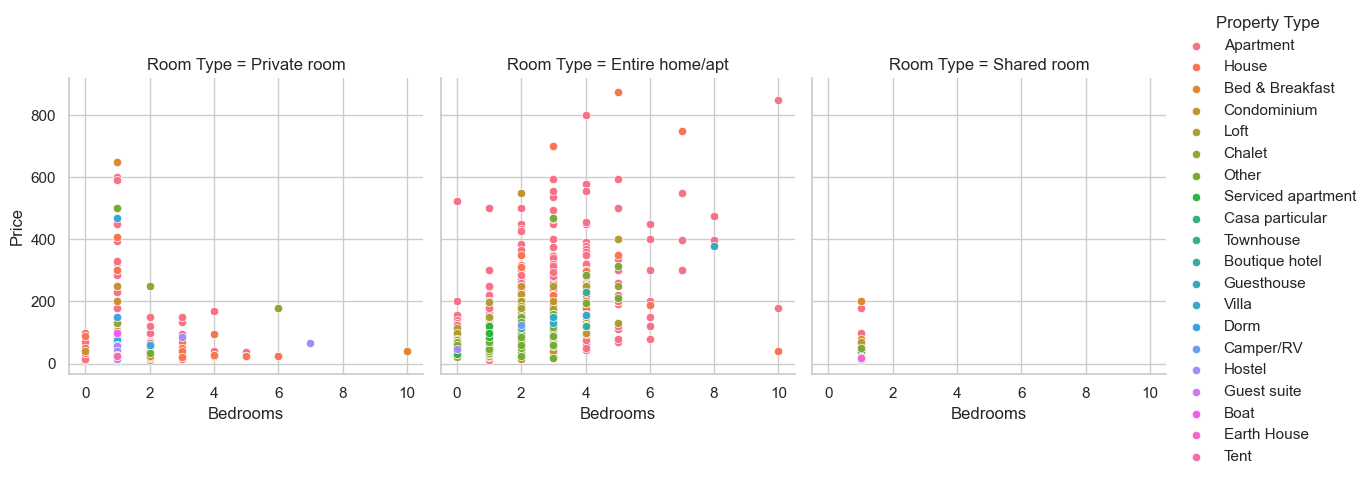

In [32]:
# Scatter Plot
sns.set_style("whitegrid") 
g = sns.FacetGrid(data_train, col="Room Type", hue="Property Type", col_wrap=3, height=4)
g.map(sns.scatterplot, "Bedrooms", "Price")
g.add_legend()
plt.show()

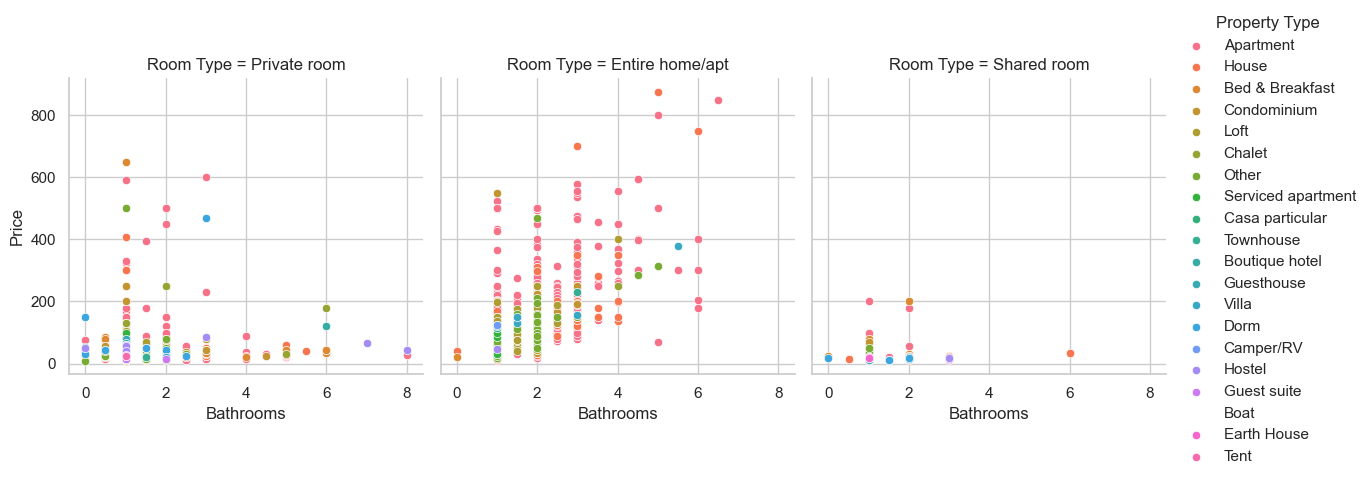

In [33]:
# Scatter Plot
sns.set_style("whitegrid") 
g = sns.FacetGrid(data_train, col="Room Type", hue="Property Type", col_wrap=3, height=4)
g.map(sns.scatterplot, "Bathrooms", "Price")
g.add_legend()
plt.show()

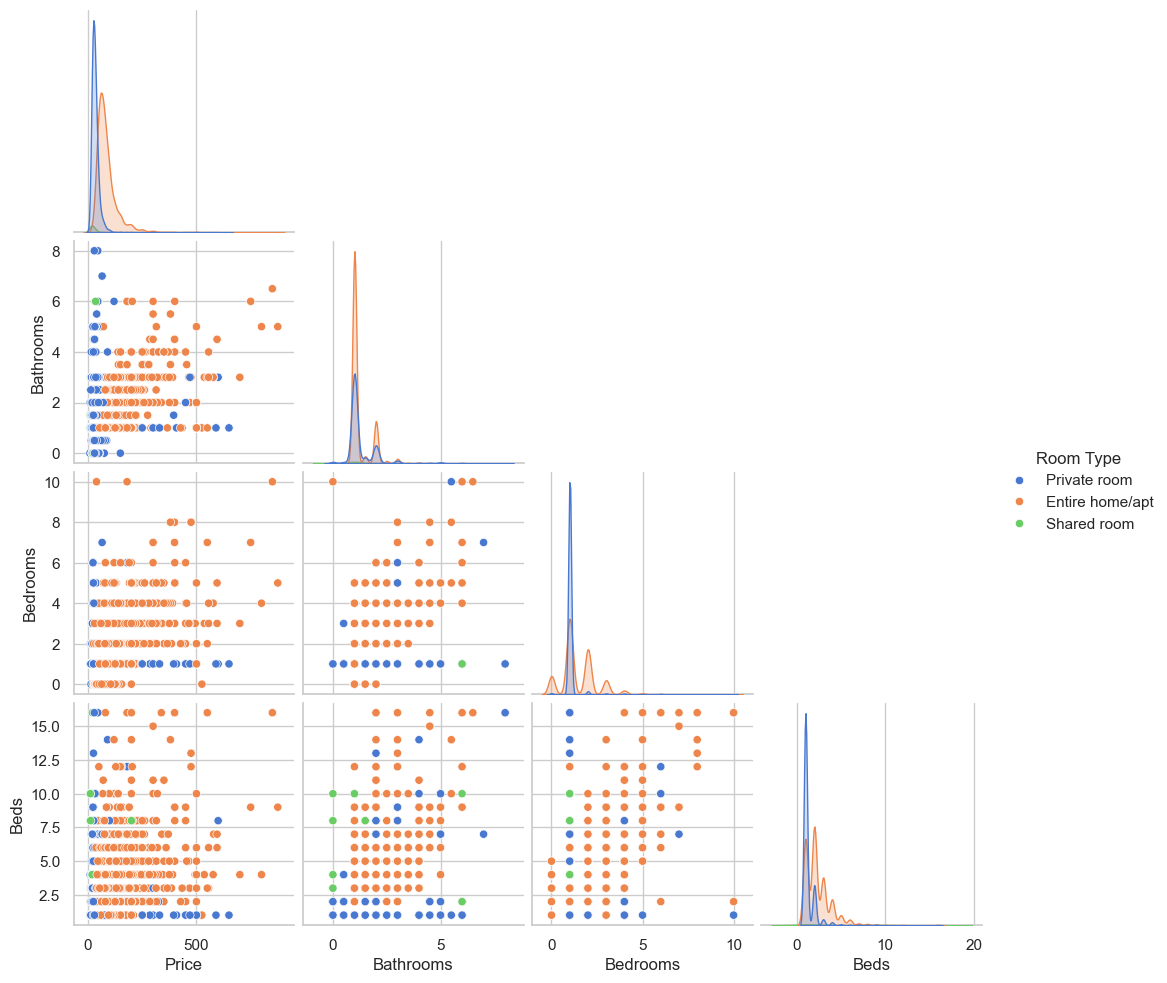

In [34]:
# Pair Plot
sns.pairplot(data_train, hue="Room Type", 
             vars=["Price", "Bathrooms", "Bedrooms", "Beds"], 
             corner=True, palette="muted")
plt.show()

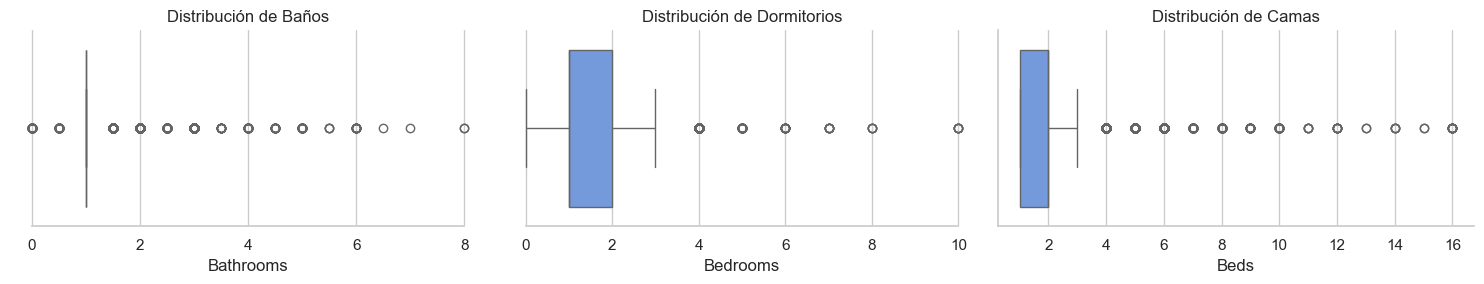

In [35]:
sns.set_style("whitegrid")
plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
sns.boxplot(data=data_train, x='Bathrooms', color="cornflowerblue")
plt.title('Distribución de Baños')

plt.subplot(1, 3, 2)
sns.boxplot(data=data_train, x='Bedrooms', color="cornflowerblue")
plt.title('Distribución de Dormitorios')

sns.despine(trim=True)

plt.subplot(1, 3, 3)
sns.boxplot(data=data_train, x='Beds', color="cornflowerblue")
plt.title('Distribución de Camas')

sns.despine(top=True, right=True, left=False, bottom=False)

plt.tight_layout()
plt.show()

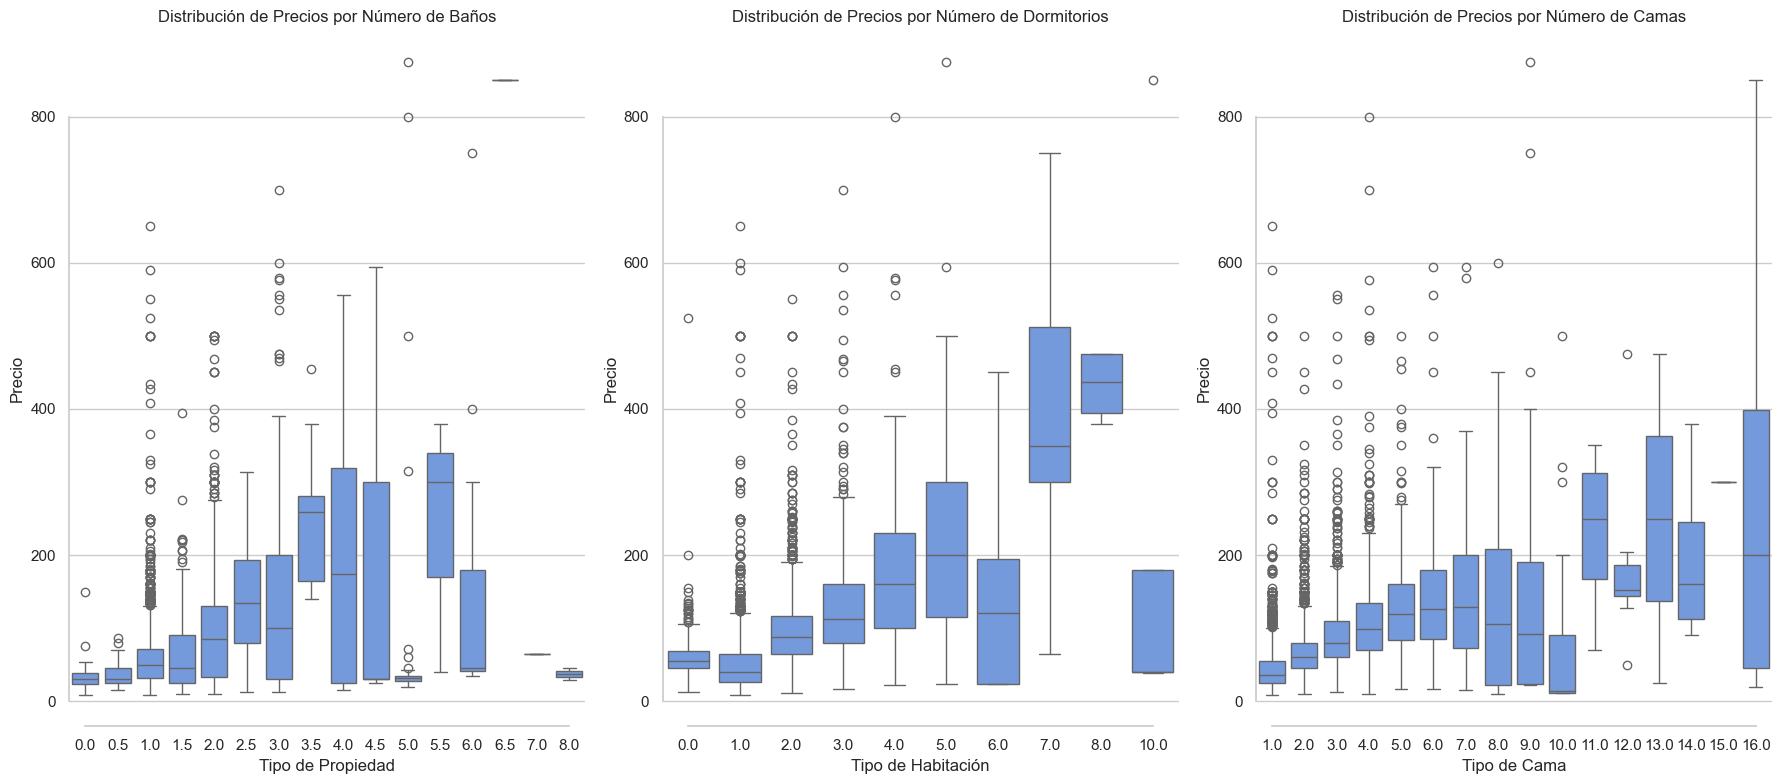

In [36]:
sns.set_style("whitegrid")
plt.figure(figsize=(18, 8))

plt.subplot(1, 3, 1)
sns.boxplot(x='Bathrooms', y='Price', data=data_train, color="cornflowerblue")
plt.title('Distribución de Precios por Número de Baños')
plt.xlabel('Tipo de Propiedad')
plt.ylabel('Precio')

plt.subplot(1, 3, 2)
sns.boxplot(x='Bedrooms', y='Price', data=data_train, color="cornflowerblue")
plt.title('Distribución de Precios por Número de Dormitorios')
plt.xlabel('Tipo de Habitación')
plt.ylabel('Precio')

plt.subplot(1, 3, 3)
sns.boxplot(x='Beds', y='Price', data=data_train, color="cornflowerblue")
plt.title('Distribución de Precios por Número de Camas')
plt.xlabel('Tipo de Cama')
plt.ylabel('Precio')

sns.despine(trim=True)
plt.tight_layout()
plt.show()

La presencia de *Private Room* y *Shared Room* en la columna "Room Type" da una exploración pausible para algunos de los valores atípicos en la cantidad de baños y dormitorios. Por ejemplo, una propiedad podría tener un alto número de baños disponibles porque se trata de un hostal o un bed & breakfast donde cada habitación privada o compartida tiene acceso a su propio baño, aunque el número de dormitorios sea bajo. 

In [37]:
print(f"Registros con 10 dormitorios:\n{data_train[data_train['Bedrooms'] == 10][['Bathrooms', 'Beds', 'Price', 'Property Type']]}")
print(f"\nRegistros con 0 dormitorios:\n{data_train[data_train['Bedrooms'] == 0][['Bathrooms', 'Beds', 'Price', 'Property Type']]}")
print(f"\nRegistros con 7 baños o más:\n{data_train[data_train['Bathrooms'] >= 7][['Bathrooms', 'Beds', 'Price', 'Property Type']]}")

Registros con 10 dormitorios:
      Bathrooms  Beds  Price    Property Type
82          6.0  16.0   40.0  Bed & Breakfast
1782        5.5   1.0   40.0            House
3859        6.0  16.0  180.0        Apartment
5557        6.5  16.0  850.0        Apartment
7916        0.0   2.0   39.0            House

Registros con 0 dormitorios:
       Bathrooms  Beds  Price       Property Type
42           1.0   1.0   60.0           Apartment
53           1.0   1.0   53.0           Apartment
77           1.0   2.0   66.0                Loft
126          1.0   3.0   55.0           Apartment
132          1.0   3.0   43.0  Serviced apartment
138          1.0   1.0  135.0           Apartment
142          1.0   2.0   69.0           Apartment
167          1.0   1.0   51.0           Apartment
170          1.0   1.0   59.0           Apartment
188          1.0   2.0   69.0           Apartment
192          1.0   1.0   69.0           Apartment
197          1.0   2.0  100.0                Loft
199          1

In [38]:
print(f"Registros con 0 baños:\n{data_train[data_train['Bathrooms'] == 0][['Bedrooms', 'Beds', 'Price', 'Property Type']]}")
print(f"\nApartamentos con 16 camas:\n{data_train[(data_train['Beds'] == 16) & (data_train['Property Type'] == 'Apartment')][['Price', 'Bedrooms', 'Bathrooms', 'Property Type']]}")

Registros con 0 baños:
       Bedrooms  Beds  Price    Property Type
30          1.0   1.0   75.0        Apartment
71          1.0   1.0   24.0  Bed & Breakfast
773         1.0   2.0   22.0        Apartment
1138        1.0   2.0   50.0           Hostel
1254        1.0   1.0   33.0  Bed & Breakfast
1592        1.0   1.0   20.0        Apartment
1675        1.0   2.0   24.0        Apartment
1699        1.0   8.0   21.0  Bed & Breakfast
1751        1.0   1.0   30.0        Apartment
1752        1.0   1.0   30.0        Apartment
1899        1.0   1.0   30.0        Apartment
1912        1.0   1.0  149.0             Dorm
2064        1.0   1.0   29.0        Apartment
2322        1.0   1.0   29.0            House
2405        1.0   1.0   26.0        Apartment
2914        1.0   1.0   29.0            House
3280        1.0   1.0   30.0             Dorm
3458        1.0   2.0   39.0            House
3513        1.0   3.0   53.0       Guesthouse
3538        1.0   1.0   27.0      Condominium
3874       

Del análisis anterior podemos concluir lo siguiente:

**Inconsistencia en los datos:** apartamentos que tienen 10 dormitorios pero solo 1 y 2 camas respectivamente (ID 1782 y 1916), son inusuales. Normalmente, esperaríamos un número mayor de camas en propiedades con tantos dormitorios. Esto podría ser un error en los datos o una situación atípica donde los dormitorios no están destinados a ser utilizados con camas tradicionales (por ejemplo, pueden ser utilizados como oficinas o espacios de trabajo).

El apartamento con el ID 7916 también indica 0 baños, lo cual es muy improbable para una propiedad con 10 dormitorios y sugiere un error de ingreso de datos o una omisión. Cada casa se espera que tenga al menos un baño. Un error de entrada de datos podría ser la causa aquí, o una interpretación incorrecta de un baño compartido o externo que no se contó.

**Establecer el límite de outliers**: Quiero se conservadora en la eliminación de outliers pero deseo descartar registros muy inconsistentes, por lo que decido establecer un umbral basado en el conocimiento del dominio en lugar del rango intercuartílico. 

<div class = "alert alert-success">
Vamos a definir lo siguiente: Se excluirán los apartamentos que tengan más de 6 dormitorios pero menos de 2 camas. También aquellos que tengan 0 baños, más de 8 dormitorios o más de 6 baños.
</div>

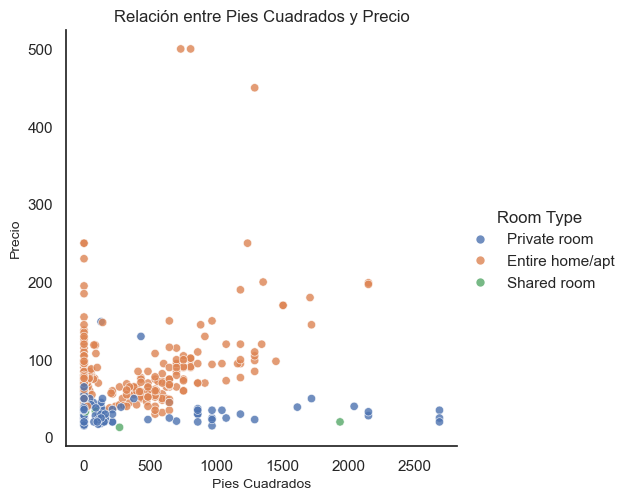

In [39]:
sns.set_theme(style="white")
sns.relplot(x='Square Feet', y='Price', data=data_train, hue='Room Type', alpha=0.8)
plt.title('Relación entre Pies Cuadrados y Precio')
plt.xlabel('Pies Cuadrados', fontsize=10)
plt.ylabel('Precio', fontsize=10)
plt.show()

*Tenemos en cuenta en el análisis anterior que hay muchos datos faltantes en la columna 'Square Feet'*

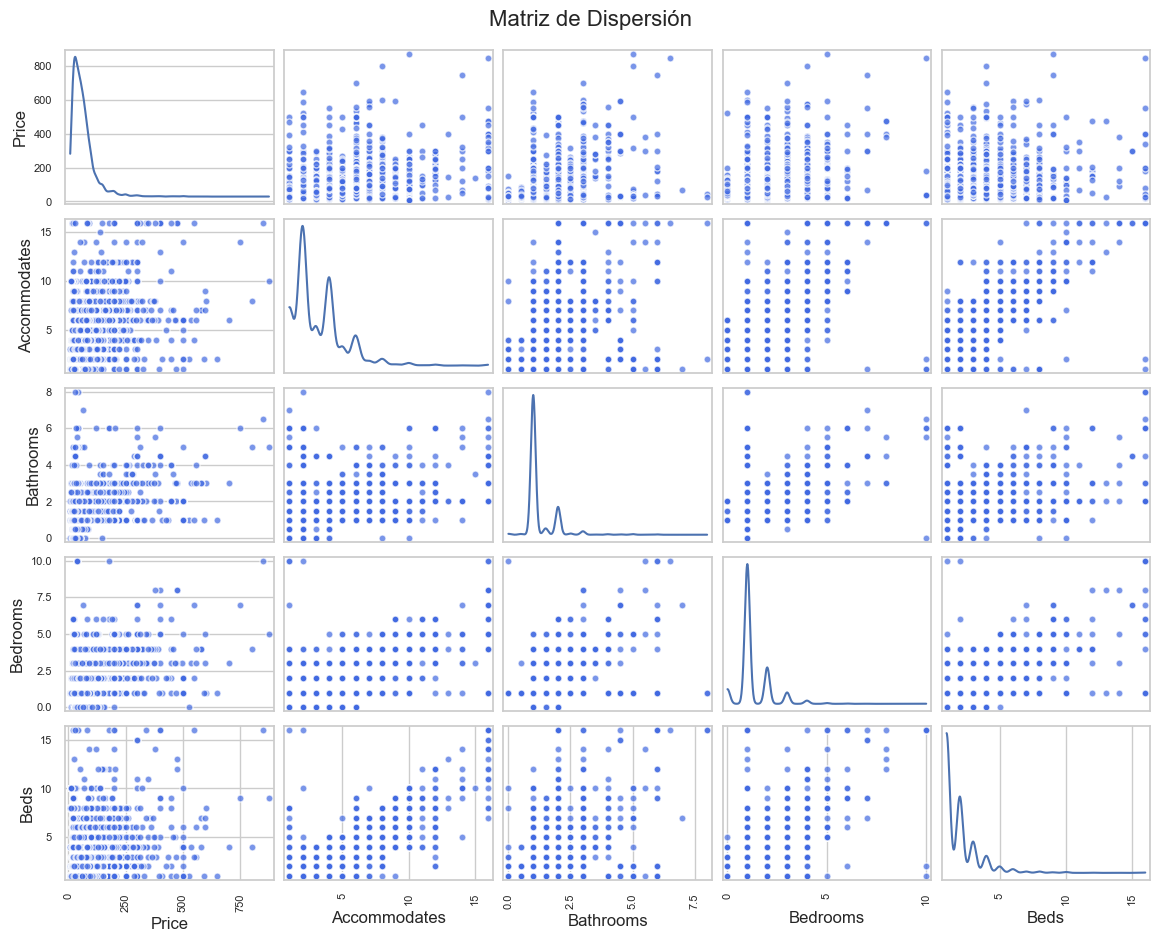

In [40]:
corr_matrix = data_train.select_dtypes(include=[np.number]).corr()
attributes = ['Price','Accommodates','Bathrooms','Bedrooms','Beds']
plot_scatter_matrix(data_train, attributes)

In [41]:
# Filtro para propiedades con más de 2500 SquareFeet
properties_above_2500sqft = data_train[data_train['Square Feet'] > 2500]
print("Propiedades con más de 2500 SquareFeet:")
print(properties_above_2500sqft[['Square Feet', 'Price', 'Room Type', 'Bathrooms', 'Bedrooms', 'Beds']])

# Filtro para apartamentos con 0 SquareFeet
apartments_with_0sqft = data_train[data_train['Square Feet'] == 0]
print("\nApartamentos con 0 SquareFeet:")
print(apartments_with_0sqft[['Square Feet', 'Price', 'Bathrooms', 'Bedrooms', 'Beds']].describe())

Propiedades con más de 2500 SquareFeet:
      Square Feet  Price     Room Type  Bathrooms  Bedrooms  Beds
1495       2691.0   35.0  Private room        1.0       1.0   1.0
7346       2691.0   25.0  Private room        2.5       1.0   3.0
8580       2691.0   20.0  Private room        2.0       1.0   7.0

Apartamentos con 0 SquareFeet:
       Square Feet       Price   Bathrooms    Bedrooms        Beds
count        169.0  169.000000  165.000000  169.000000  169.000000
mean           0.0   65.147929    1.230303    1.260355    2.272189
std            0.0   39.809315    0.547992    0.734135    1.821628
min            0.0   15.000000    0.000000    0.000000    1.000000
25%            0.0   37.000000    1.000000    1.000000    1.000000
50%            0.0   60.000000    1.000000    1.000000    2.000000
75%            0.0   80.000000    1.000000    1.000000    3.000000
max            0.0  250.000000    4.000000    4.000000   16.000000


Los registros que muestras indican propiedades con **más de 2500 'Square Feet'** (pies cuadrados) pero con precios muy bajos, y todas están listadas como habitaciones privadas ('Private room'). Esto podría parecer inusual por varias razones:

- Un tamaño de 2691 pies cuadrados es significativo para una propiedad, y uno esperaría que este tipo de propiedad sea un apartamento completo, una casa, o posiblemente una suite de lujo, no solo una habitación privada. Esto podría sugerir un error en la categorización o en el ingreso de los datos de tamaño.

- Para propiedades de este tamaño, los precios listados (35, 25, y 20) son extremadamente bajos, lo cual no parece coherente con el mercado inmobiliario para propiedades de tal tamaño, incluso si solo se está alquilando una habitación privada dentro de la propiedad.

- Los detalles adicionales, como la cantidad de baños y camas, especialmente en el registro con 7 camas pero solo listado como una habitación privada, también parecen **inusuales** y podrían indicar un **error en la entrada de datos o una interpretación incorrecta** de cómo se deben listar las propiedades.

Respecto a los **apartamentos con 0 pies cuadrados:**

- Todos los apartamentos en este subconjunto tienen 0 'Square Feet', lo que indica que o bien esta información no fue recopilada o ingresada correctamente, o representa un marcador de posición para valores desconocidos. Es altamente improbable que estos apartamentos literalmente no tengan área, lo que sugiere un problema de datos.

- El precio promedio de estos apartamentos es de aproximadamente 65.15, con un rango que va desde 15 hasta 250. Esto muestra que, a pesar de la falta de información sobre el tamaño, los precios varían significativamente, lo cual es esperable en el mercado inmobiliario, pero difícil de justificar sin conocer el tamaño de la propiedad.

- El mínimo en baños y dormitorios es 0, lo que podría ser correcto para ciertos tipos de alojamientos (como estudios), pero también merece una revisión detallada para asegurar que no se trate de errores de entrada.

<div class = "alert alert-success">
Se elimina la columna 'Square Feet' sin filtrar el dataset, asumiendo que su recopilación fue incorrecta, pero considerando que el resto de los datos pueden ser precisos y valiosos para el análisis, evitando así la pérdida de información.
</div>

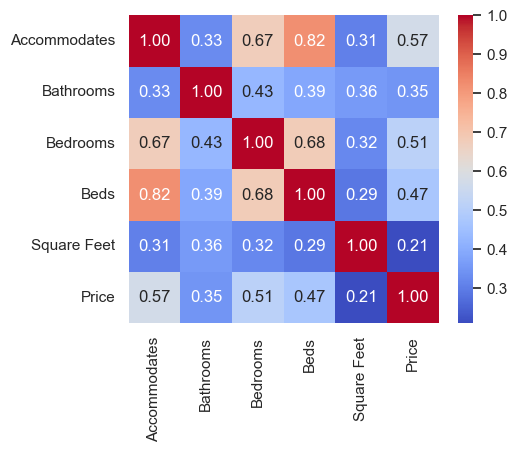

In [42]:
correlation_matrix = data_train[['Accommodates','Bathrooms','Bedrooms','Beds','Square Feet','Price']].corr()
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show()

### Conclusiones

**Nuevas columnas que se plantean:**
- `BedsPerRoom` (nº camas / nº habitaciones): calcula el ratio de camas por habitación
- `BathsPerRoom` (nº baños / nº habitaciones): podría ser un indicador de lujo y conveniencia (afectaría al precio)
- `PricePerBed` (precio / nº camas): da una idea del costo por persona
- `BedBathRooms` (nº dormitorios * nº baños): relación entre el número de dormitorios y de baños

**Columnas que no se incluirán en el modelo:**
- `Square Feet` (muchos datos faltantes, 96,15% de los registros)

**Columnas de texto/categóricas que se convertirán a categorías numéricas:**
-  `Property Type` (primero clasificar en 6 valores únicos: Apartment' 'Loft' 'House' 'Bed & Breakfast' ‘Condominium' 'Others' y después codificar)
-  `Room Type` (target encoding)
-  `Bed Type` (pasar a binaria 0 - 1 en función de si es Real Bed o no)
-  `Amenities` (recuento del listado de Amenities)

**Columnas numéricas que se mantienen:**
-  `Accommodates` 
-  `Bathrooms, Bedrooms, Beds` 

### 4. Datos relacionados con la información de precios y costos adicionales

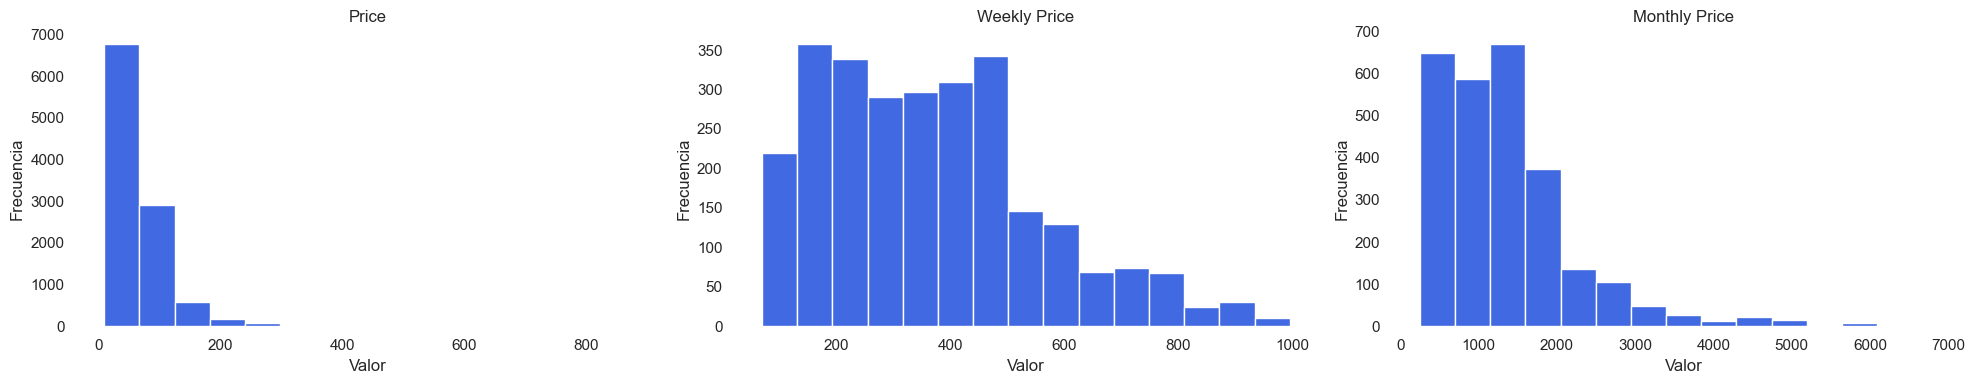

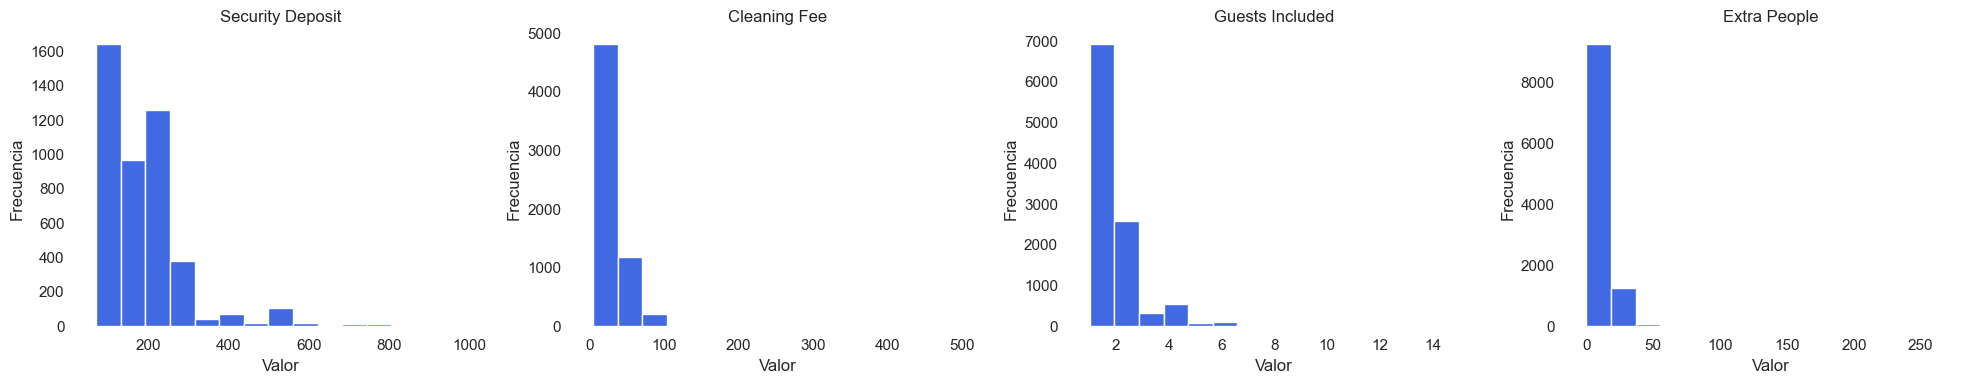

In [43]:
columns_to_include = ['Price', 'Weekly Price', 'Monthly Price', 'Security Deposit',
                      'Cleaning Fee', 'Guests Included', 'Extra People']
plot_histograms(data_train, columns_to_include[:3], bins=15, figsize=(20, 4))
plot_histograms(data_train, columns_to_include[3:], bins=15, figsize=(20, 4))

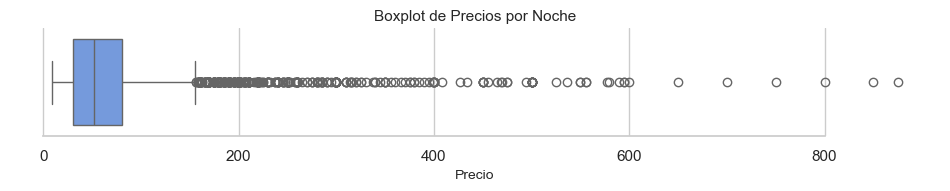

In [44]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 1.4))
sns.boxplot(x=data_train['Price'], color='cornflowerblue')
plt.title('Boxplot de Precios por Noche', fontsize='11')
plt.xlabel('Precio', fontsize='10')
sns.despine(trim=True)
plt.show()

Hay una cantidad significativa de outliers, lo que indica variabilidad en los precios. El valor de la mediana (línea dentro de la caja) será un mejor indicador de la 'tarifa típica' que la media debido a estos outliers.

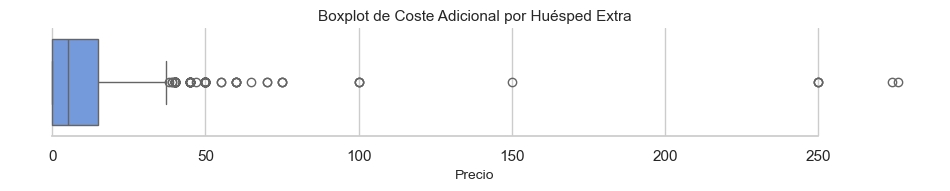

In [45]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 1.4))
sns.boxplot(x=data_train['Extra People'], color='cornflowerblue')
plt.title('Boxplot de Coste Adicional por Huésped Extra', fontsize='11')
plt.xlabel('Precio', fontsize='10')
sns.despine(trim=True)
plt.show()

In [46]:
data_train[data_train['Extra People'] > 100][['Extra People', 'Property Type', 'Price',
                                              'Bedrooms', 'Bathrooms', 'Beds', 'Neighbourhood Cleansed']]

Extra People Property Type  Price  Bedrooms  Bathrooms  Beds  \
2495            276     Apartment   55.0       1.0        1.5   1.0   
4997            250        Chalet    NaN       3.0        3.0   3.0   
5014            150     Apartment  120.0       1.0        1.0   2.0   
5591            250         House    NaN       3.0        3.0   3.0   
8646            274     Apartment   75.0       1.0        1.0   1.0   
10466           250     Apartment  500.0       1.0        1.0   3.0   

      Neighbourhood Cleansed  
2495               Trafalgar  
4997              Niño Jesús  
5014             Universidad  
5591              Niño Jesús  
8646             Universidad  
10466            Embajadores

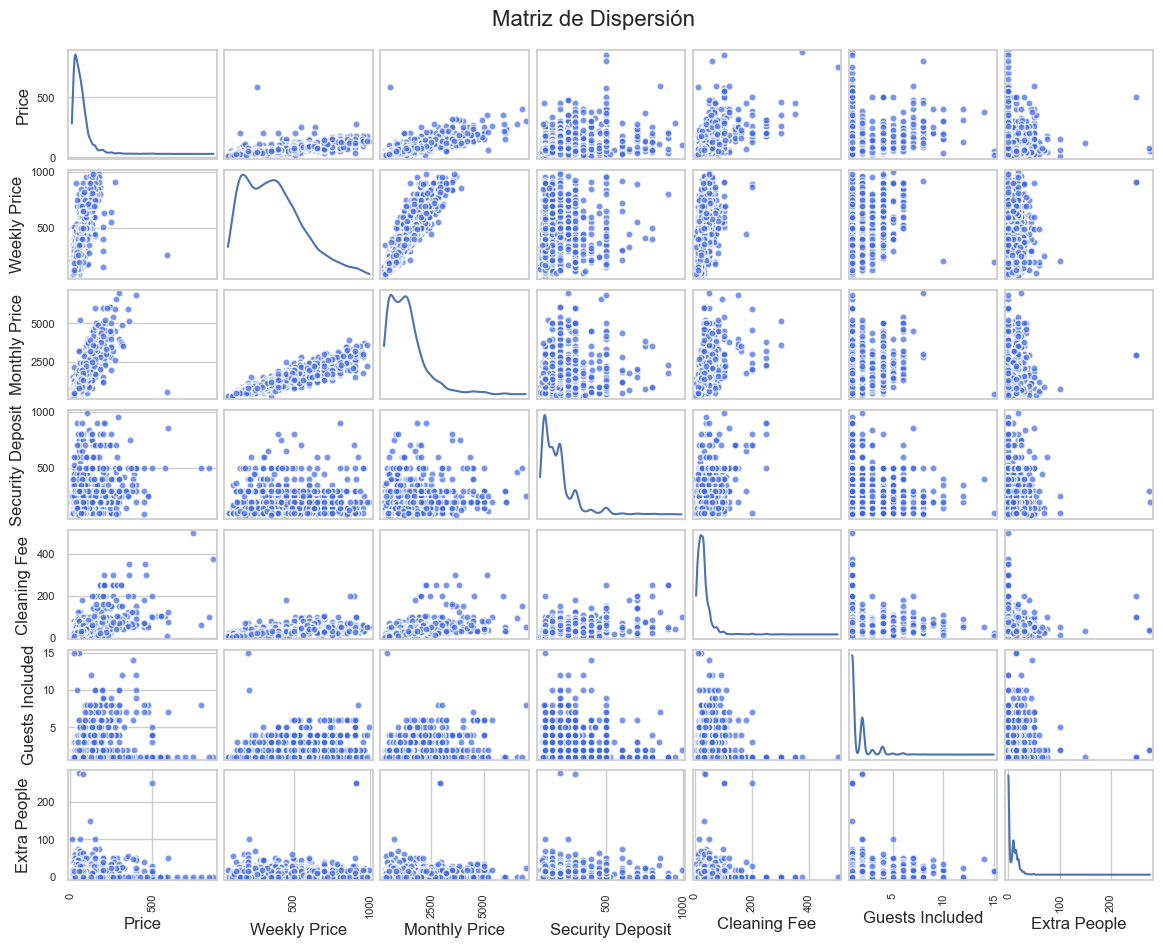

In [47]:
attributes = ['Price', 'Weekly Price', 'Monthly Price', 'Security Deposit',
                'Cleaning Fee', 'Guests Included', 'Extra People']
plot_scatter_matrix(data_train, attributes)

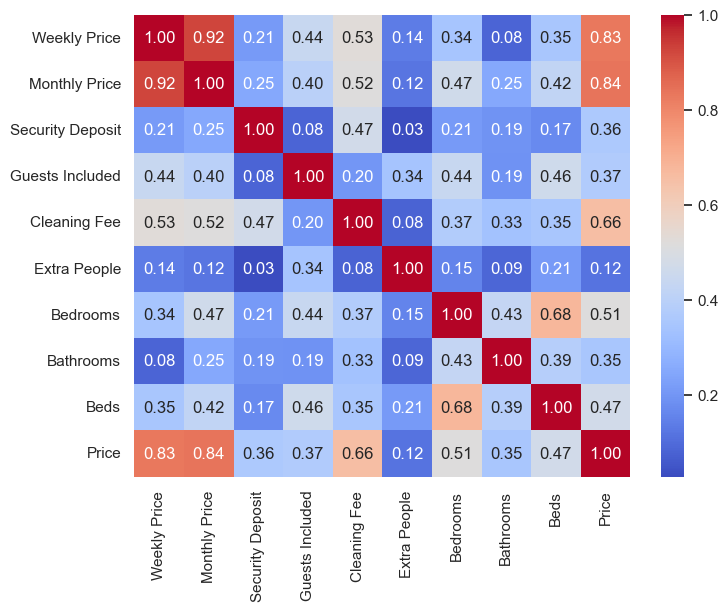

In [48]:
correlation_matrix = data_train[['Weekly Price','Monthly Price','Security Deposit','Guests Included',
                         'Cleaning Fee','Extra People','Bedrooms','Bathrooms','Beds','Price']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show()

### Conclusiones

**Columnas que no se incluirán en el modelo:**
- `Weekly Price, Monthly Price, Security Deposit` (muchos valores faltantes)

**Columnas numéricas que se mantienen:**
-  `Cleaning Fee` (hay que imputar, tiene 4347 datos faltantes) 
-  `Guests Included`
-  `Extra People`, decido mantenerla a pesar de tener una correlación baja con el precio (puedo incluirla en el modelo predictivo inicial y luego evaluar la importancia). Si los métodos de selección de características o la importancia de las variables en el modelo indican que 'Extra People' no es significativa, consideraré excluirla del modelo final.

### 5. Datos relacionados con las restricciones de reserva y la disponibilidad

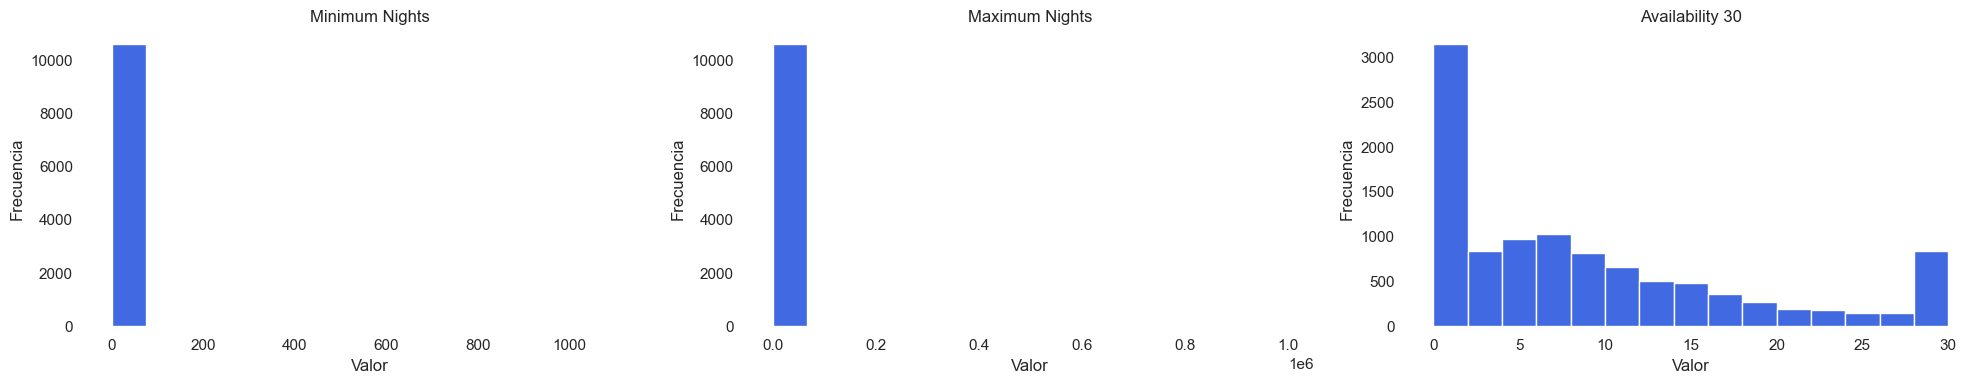

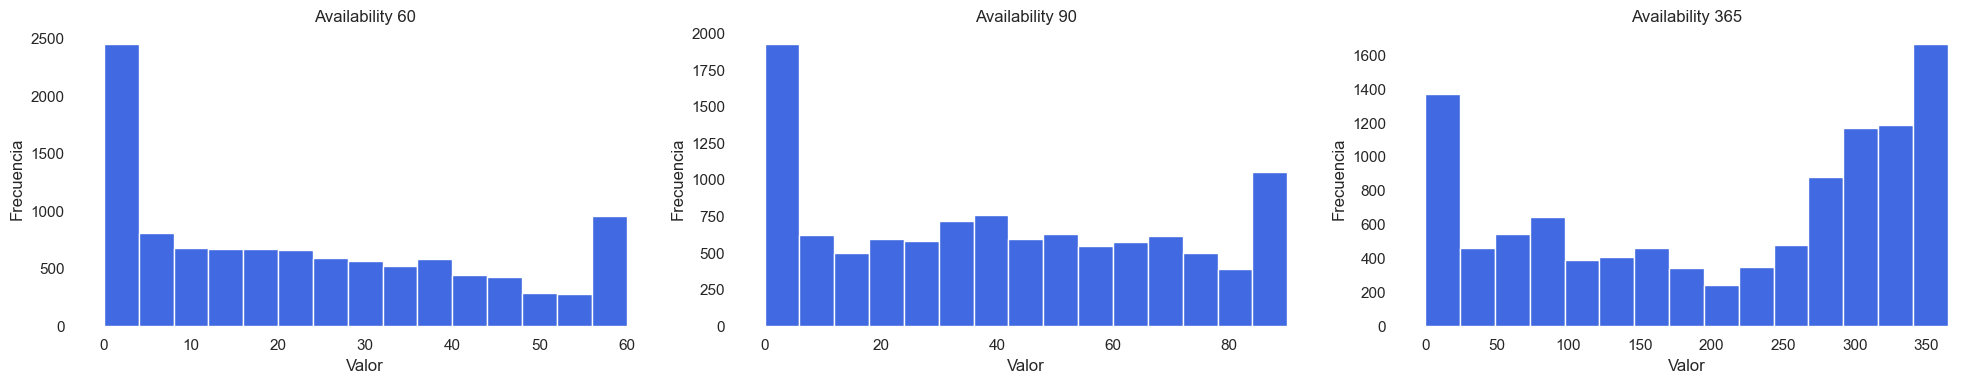

In [49]:
columns_to_include = ['Minimum Nights', 'Maximum Nights', 'Availability 30',
                      'Availability 60', 'Availability 90', 'Availability 365']
plot_histograms(data_train, columns_to_include[:3], bins=15, figsize=(20, 4))
plot_histograms(data_train, columns_to_include[3:], bins=15, figsize=(20, 4))

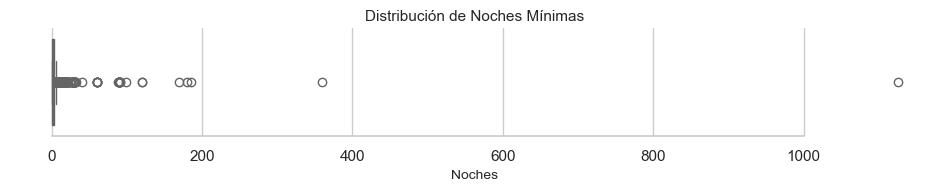

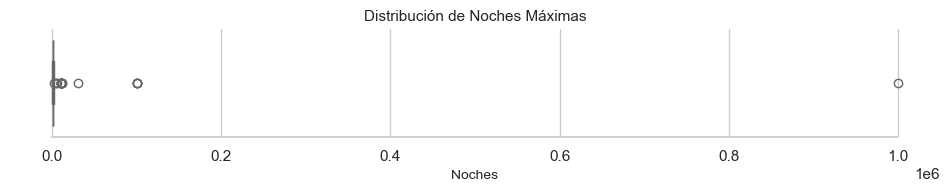

In [50]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 1.4))
sns.boxplot(x=data_train['Minimum Nights'], color='cornflowerblue')
plt.title('Distribución de Noches Mínimas', fontsize='11')
plt.xlabel('Noches', fontsize='10')
sns.despine(trim=True)
plt.show()

plt.figure(figsize=(12, 1.4))
sns.boxplot(x=data_train['Maximum Nights'], color='cornflowerblue')
plt.title('Distribución de Noches Máximas', fontsize='11')
plt.xlabel('Noches', fontsize='10')
sns.despine(trim=True)
plt.show()

Utilizaré los valores de las columnas `Maximum Night` y `Minimum Nights` para crear una nueva columna que refleja la duración de la estancia (corta, media, larga, variable)

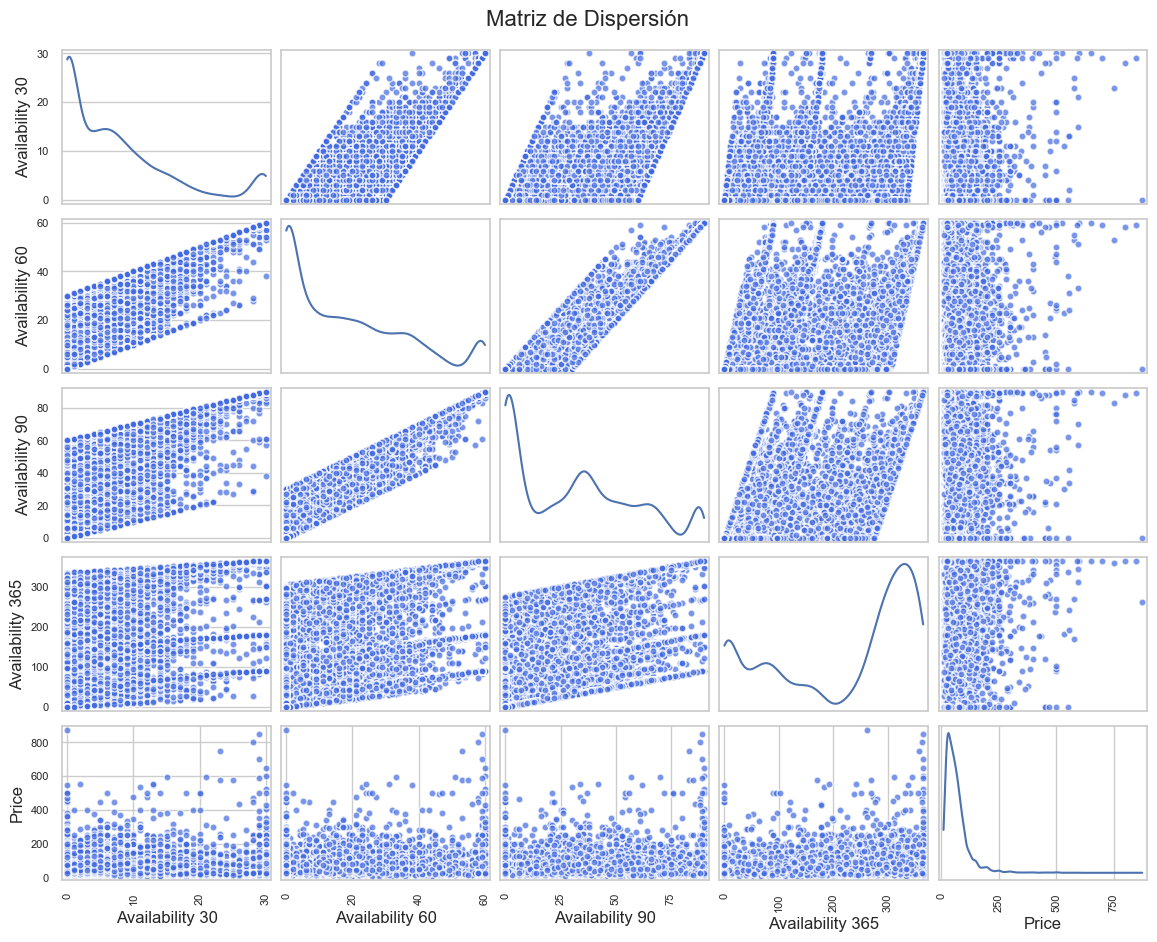

In [51]:
attributes = ['Availability 30', 'Availability 60', 'Availability 90', 'Availability 365', 'Price']
plot_scatter_matrix(data_train, attributes)

Los gráficos no parecen mostrar una relación lineal clara entre la disponibilidad y el precio. Esto podría significar que la disponibilidad no afecta directamente el precio o que cualquier relación puede ser no lineal o influenciada por otros factores.

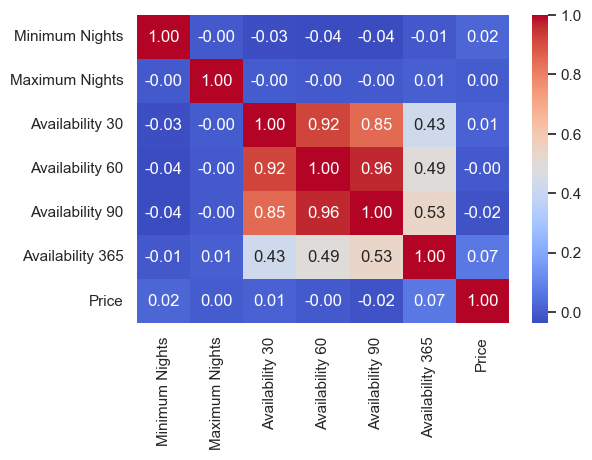

In [52]:
correlation_matrix = data_train[['Minimum Nights','Maximum Nights', 'Availability 30',
                                 'Availability 60','Availability 90','Availability 365','Price']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show()

### Conclusiones

**Nuevas columnas:**
- `Stay Duration` (duración de la estancia en base a minimum nights y maximum nights)

**Columnas que no se incluirán en el modelo:**
- `Availability 30, Availability 60, Availability 90, Availability 365` (corr baja)
- `Minimum Nights, Maximum Nights` (utilizamos 'Stay Duration')
- `Calendar Updated` (información menos relevante)

### 6. Datos relacionados con métricas de calidad y popularidad

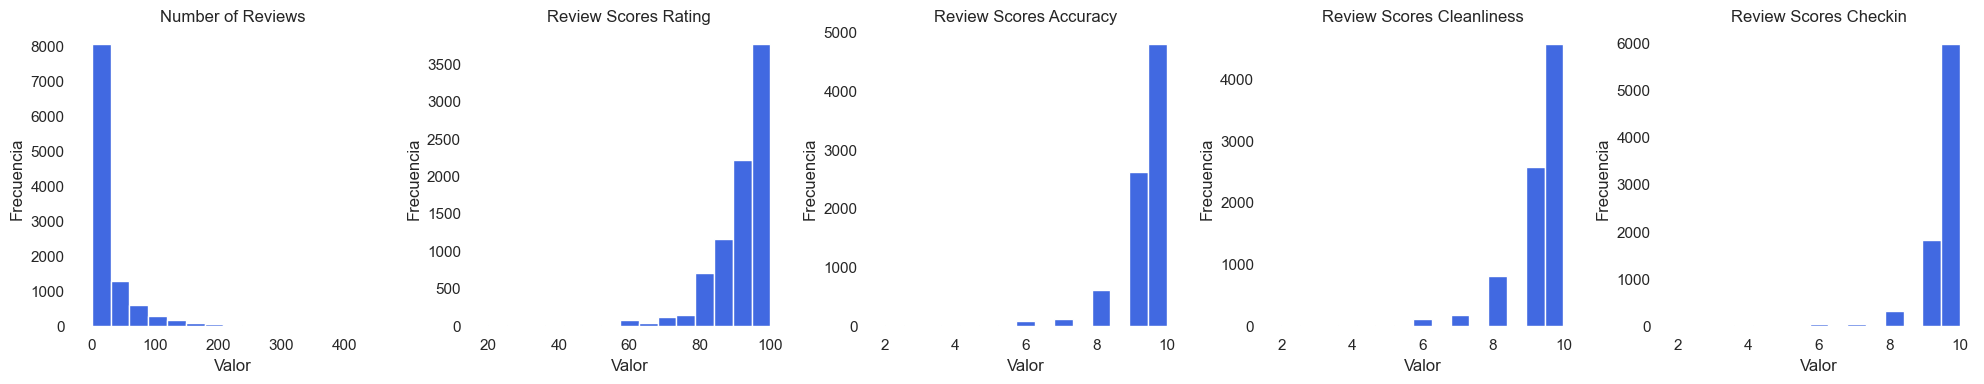

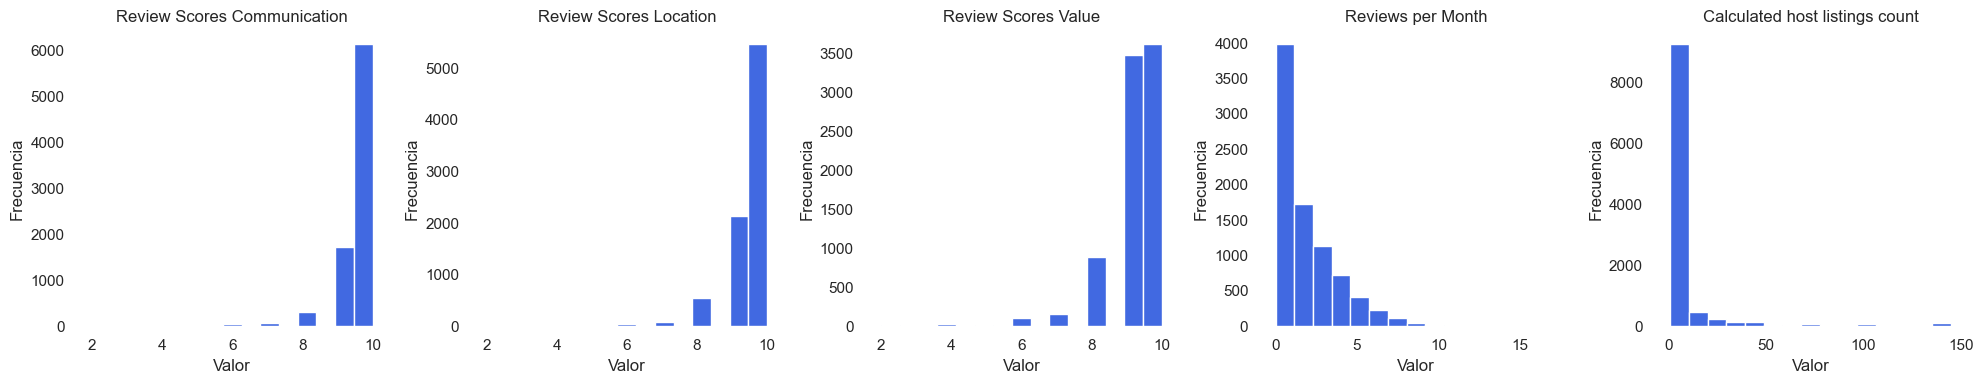

In [53]:
columns_to_include = ['Number of Reviews','Review Scores Rating','Review Scores Accuracy',
                      'Review Scores Cleanliness','Review Scores Checkin','Review Scores Communication',
                      'Review Scores Location','Review Scores Value','Reviews per Month',
                      'Calculated host listings count']
plot_histograms(data_train, columns_to_include[:5], bins=15, figsize=(20, 4))
plot_histograms(data_train, columns_to_include[5:], bins=15, figsize=(20, 4))

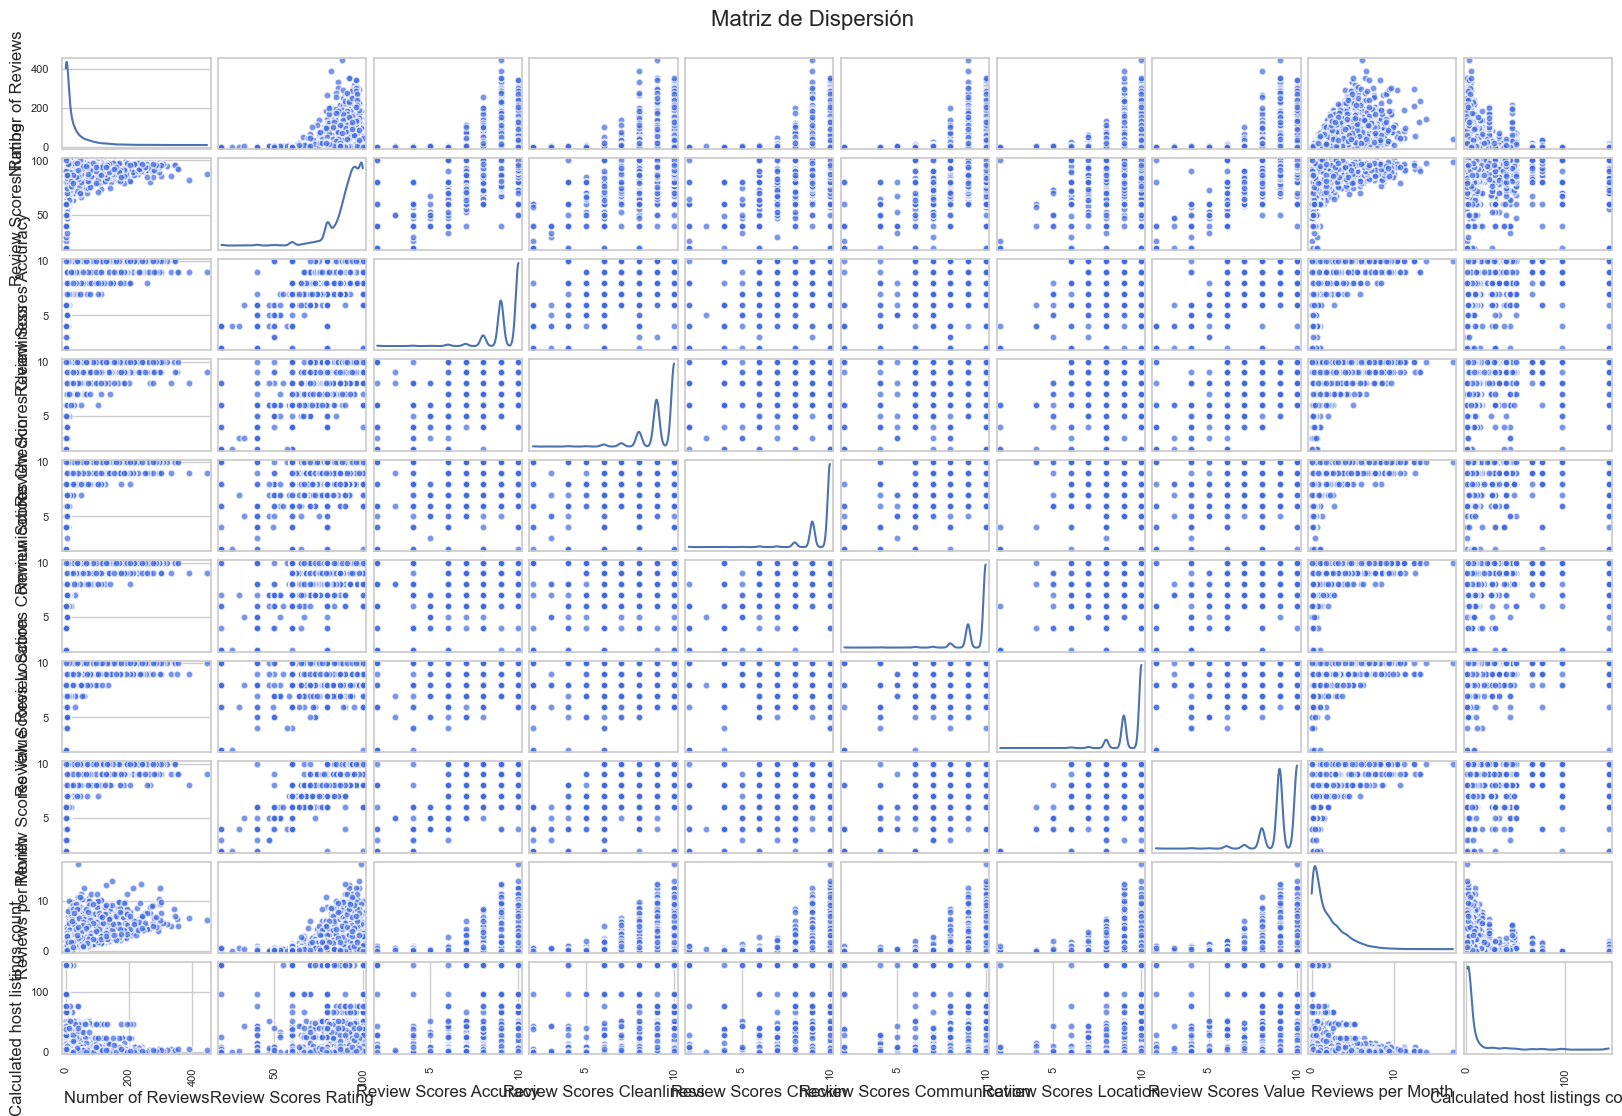

In [54]:
attributes = ['Number of Reviews','Review Scores Rating','Review Scores Accuracy','Review Scores Cleanliness',
              'Review Scores Checkin','Review Scores Communication','Review Scores Location',
              'Review Scores Value','Reviews per Month','Calculated host listings count']
plot_scatter_matrix(data_train, attributes, figsize=(20, 12))

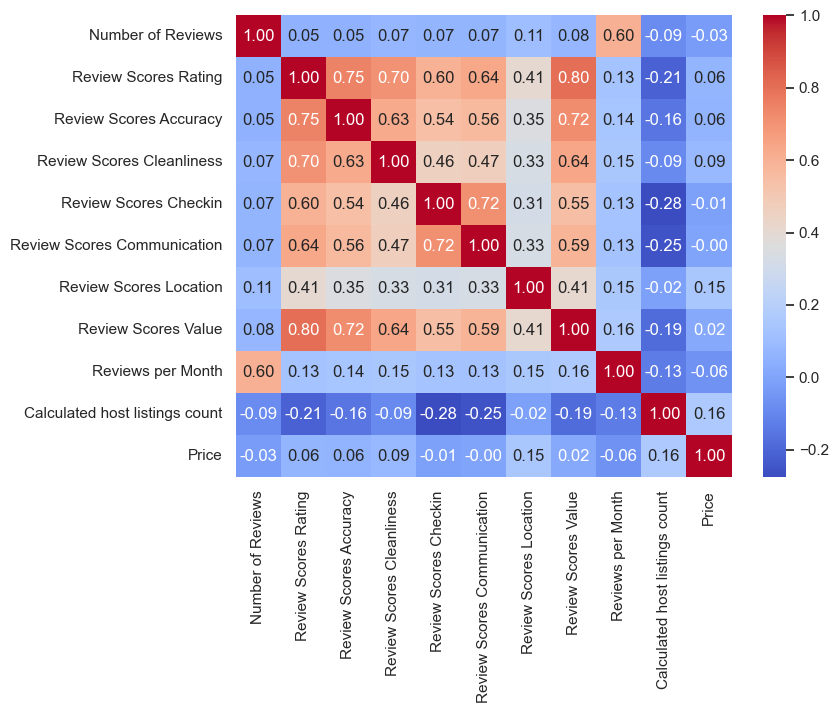

In [55]:
# Seleccionamos las columnas de interés para la correlación
columns_of_interest = ['Number of Reviews','Review Scores Rating','Review Scores Accuracy',
                       'Review Scores Cleanliness','Review Scores Checkin','Review Scores Communication',
                       'Review Scores Location','Review Scores Value','Reviews per Month',
                       'Calculated host listings count','Price']

correlation_matrix = data_train[columns_of_interest].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show()

### Conclusiones

**Columnas que no se incluirán en el modelo:**
- `Number of Reviews, Review Scores Rating,Review Scores Accuracy, Review Scores Cleanliness, Review Scores Checkin, Review Scores Communication, Review Scores Location, Review Scores Value, Reviews per Month, Calculated host listings count` (corr baja)

**Columnas de texto/categóricas que se convertirán a categorías numéricas:**
- `Features`(recuento total de features)
- `Cancellation Policity` (8 valores únicos)

### Outliers

Tras el análisis anterior sospecho que algunos de los alojamientos con valores atípicos en el número de dormitorios y de baños podrían representar una situación única y por tanto real, como un hostal o un tipo de alojamiento compartido, decido analizar la siguiente situación, eliminando los registros que tienen valores elevados en esas características. 

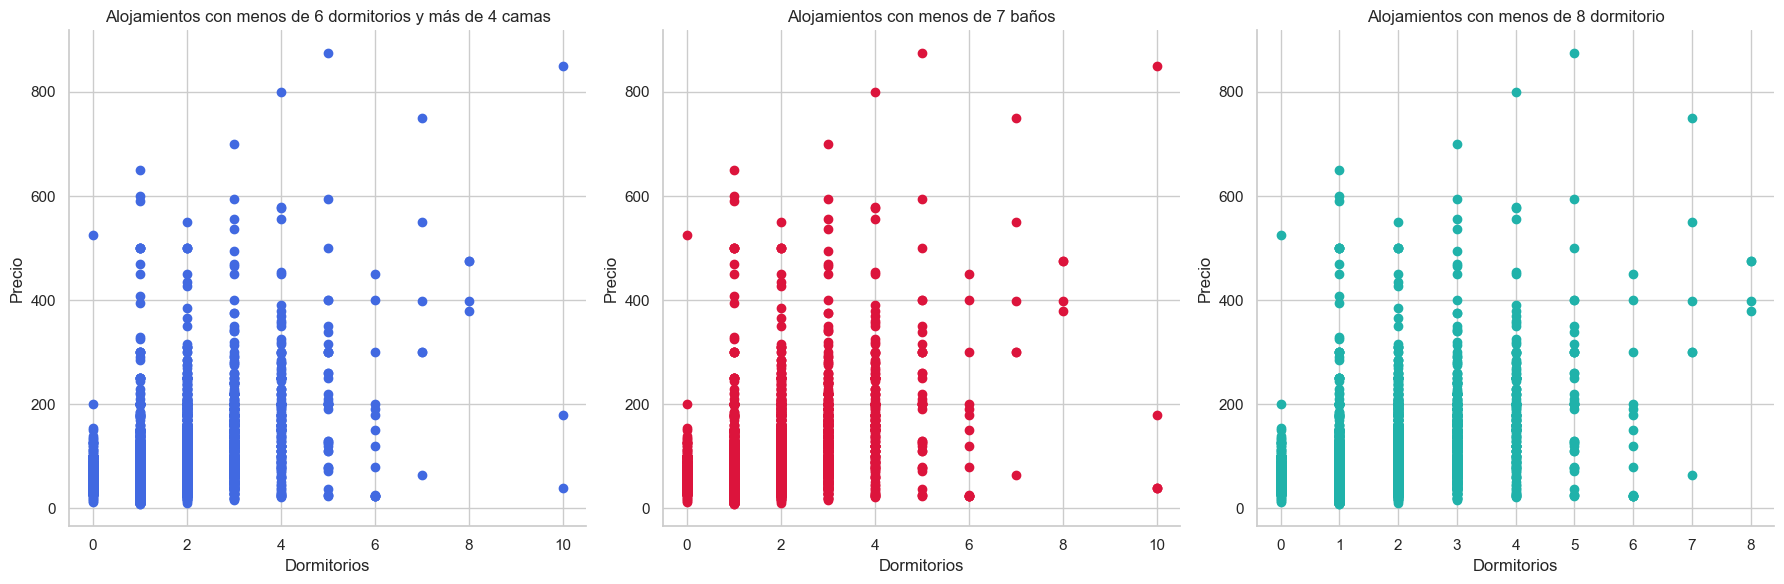

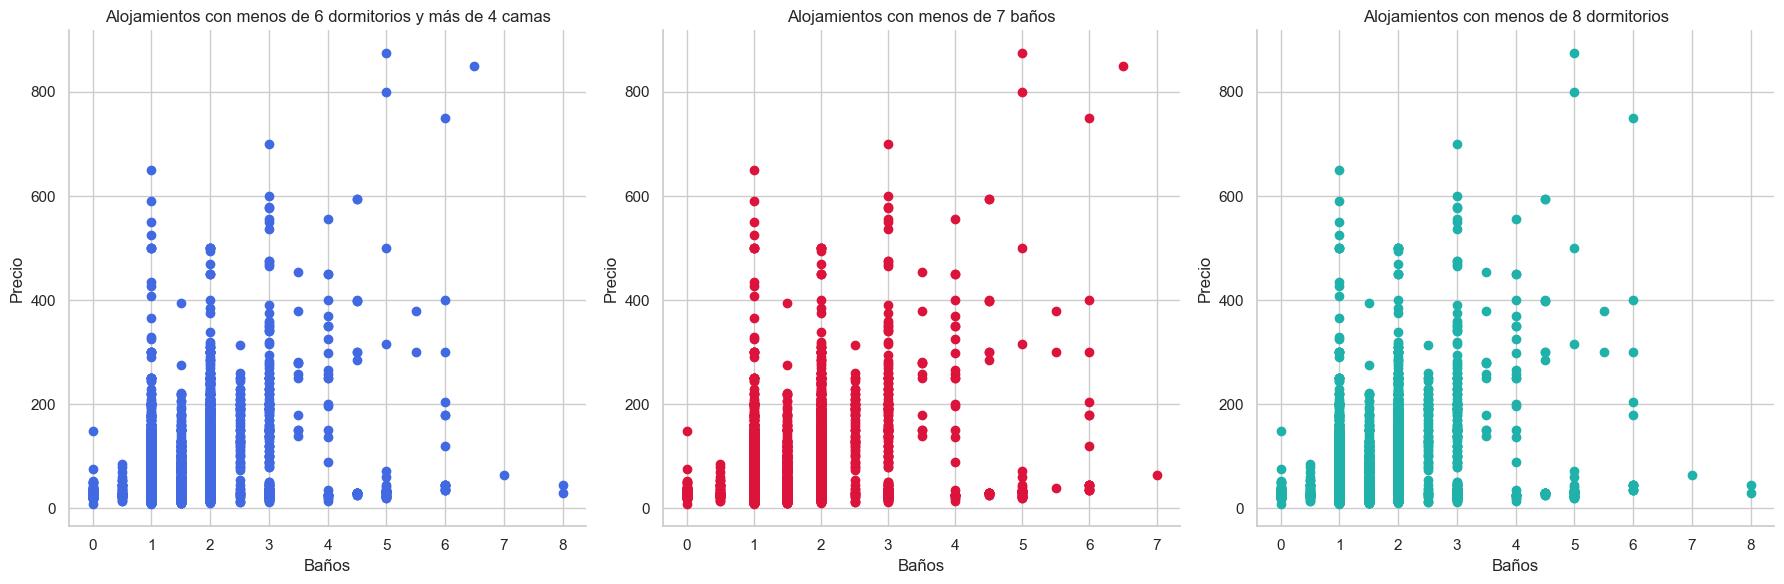

In [56]:
sns.set_style("whitegrid")

data_train_no_outliers = data_train[~((data_train['Bedrooms'] > 6) & (data_train['Beds'] < 4))]
data_train_no_outliers2 = data_train[data_train['Bathrooms'] <= 7]
data_train_no_outliers3 = data_train[data_train['Bedrooms'] <= 8]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Primer gráfico: Dormitorios vs Precio
axs[0].scatter(data_train_no_outliers['Bedrooms'], data_train_no_outliers['Price'], color='royalblue')
axs[0].set_xlabel('Dormitorios')
axs[0].set_ylabel('Precio')
axs[0].set_title('Alojamientos con menos de 6 dormitorios y más de 4 camas')

# Tercer gráfico: Dormitorios vs Precio (sin outliers2)
axs[1].scatter(data_train_no_outliers2['Bedrooms'], data_train_no_outliers2['Price'], color='crimson')
axs[1].set_xlabel('Dormitorios')
axs[1].set_ylabel('Precio')
axs[1].set_title('Alojamientos con menos de 7 baños')

# Quinto gráfico: Dormitorios vs Precio (sin outliers2)
axs[2].scatter(data_train_no_outliers3['Bedrooms'], data_train_no_outliers3['Price'], color='lightseagreen')
axs[2].set_xlabel('Dormitorios')
axs[2].set_ylabel('Precio')
axs[2].set_title('Alojamientos con menos de 8 dormitorio')

plt.tight_layout()
sns.despine(top=True, right=True, left=False, bottom=False)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Segundo gráfico: Baños vs Precio
axs[0].scatter(data_train_no_outliers['Bathrooms'], data_train_no_outliers['Price'], color='royalblue')
axs[0].set_xlabel('Baños')
axs[0].set_ylabel('Precio')
axs[0].set_title('Alojamientos con menos de 6 dormitorios y más de 4 camas')

# Cuarto gráfico: Baños vs Precio (sin outliers2)
axs[1].scatter(data_train_no_outliers2['Bathrooms'], data_train_no_outliers2['Price'], color='crimson')
axs[1].set_xlabel('Baños')
axs[1].set_ylabel('Precio')
axs[1].set_title('Alojamientos con menos de 7 baños')

# Sexto gráfico: Baños vs Precio (sin outliers2)
axs[2].scatter(data_train_no_outliers3['Bathrooms'], data_train_no_outliers3['Price'], color='lightseagreen')
axs[2].set_xlabel('Baños')
axs[2].set_ylabel('Precio')
axs[2].set_title('Alojamientos con menos de 8 dormitorios')

plt.tight_layout()
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [57]:
print(f'Original: {data_train.shape[0]} // Modificado: {data_train_no_outliers.shape[0]}\nDiferencia: {data_train.shape[0] - data_train_no_outliers.shape[0]}')
print(f'Variación: {((data_train.shape[0] - data_train_no_outliers.shape[0])/data_train.shape[0])*100:2f}%')
print(f'\nOriginal: {data_train.shape[0]} // Modificado: {data_train_no_outliers2.shape[0]}\nDiferencia: {data_train.shape[0] - data_train_no_outliers2.shape[0]}')
print(f'Variación: {((data_train.shape[0] - data_train_no_outliers2.shape[0])/data_train.shape[0])*100:2f}%')
print(f'\nOriginal: {data_train.shape[0]} // Modificado: {data_train_no_outliers3.shape[0]}\nDiferencia: {data_train.shape[0] - data_train_no_outliers3.shape[0]}')
print(f'Variación: {((data_train.shape[0] - data_train_no_outliers3.shape[0])/data_train.shape[0])*100:2f}%')

Original: 10609 // Modificado: 10607
Diferencia: 2
Variación: 0.018852%

Original: 10609 // Modificado: 10569
Diferencia: 40
Variación: 0.377038%

Original: 10609 // Modificado: 10590
Diferencia: 19
Variación: 0.179093%


La aplicación cuidadosa de los filtros excluye menos del 1% del conjunto de datos, eliminando únicamente las instancias más atípicas sin comprometer la representatividad global. Este enfoque selectivo y minucioso garantiza la retención de información crucial para el análisis, manteniendo la calidad y la fidelidad de los datos para modelado futuro.

### Correlación entre variables

In [ ]:
#data_train.select_dtypes(include=[np.number]).corr()

Características con correlaciones más altas con `Price`:

In [58]:
corr_matrix = data_train.select_dtypes(include=[np.number]).corr()

# Filtramos para mostrar solo las correlaciones de 'Price' superiores a 0.4 o inferiores a -0.4
strong_correlations = corr_matrix["Price"][(corr_matrix["Price"] > 0.4) | (corr_matrix["Price"] < -0.4)]
print(strong_correlations.sort_values(ascending=False))

Price            1.000000
Monthly Price    0.838666
Weekly Price     0.830605
Cleaning Fee     0.656235
Accommodates     0.572179
Bedrooms         0.514831
Beds             0.471162
Name: Price, dtype: float64


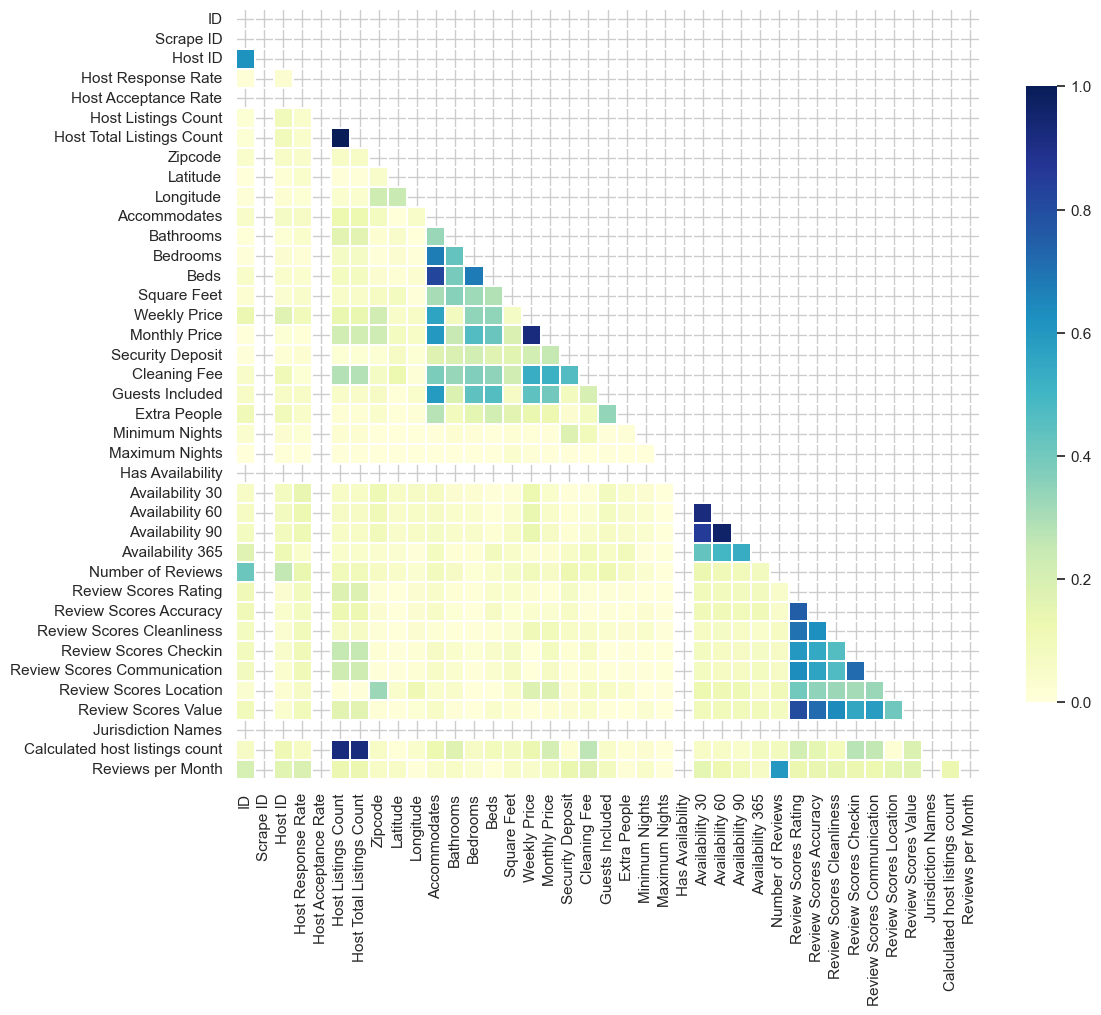

In [59]:
data = data_train.select_dtypes(include=[np.number])
corr = np.abs(data.drop(['Price'], axis=1).corr())

mask = np.zeros_like(corr, dtype = bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

## 3. Preprocesamiento

- Eliminación de variables, mediante selección (random forest/Lasso), alta correlación, alto porcentaje de missings, o el método que se considere oportuno.
- Generación de variables

### Añadir nuevas variables

*  `LatLongInteraction` (multiplicacion de longitude y latitude)
*  `BedsPerRoom` (nº camas / nº habitaciones) - *Relación Dormitorios-Camas*
*  `BathsPerRoom` (nº baños / nº habitaciones) - *Relación Baños-Habitaciones*
*  `PricePerBed` (precio / nº camas) - *Precio por cama*
*  `BedBathRooms` (nº dormitorios * nº baños) - *Relación Dormitorios-Baños*
*  `Stay Duration` (duración de la estancia en base a minimum nights y maximum nights)

In [60]:
data_train['LatLongInteraction']  = data_train['Latitude'] * data_train['Longitude']

# Si el número de dormitorios es mayor que cero, realiza la división, de lo contrario devuelve cero.
data_train['BedsPerRoom'] = data_train.apply(lambda row: row['Beds'] / row['Bedrooms'] if row['Bedrooms'] > 0 else 0, axis=1)
data_train['BathsPerRoom'] = data_train.apply(lambda row: row['Bathrooms'] / row['Bedrooms'] if row['Bedrooms'] > 0 else 0, axis=1)

data_train['PricePerBed'] = data_train['Price'] / data_train['Beds']
data_train['BedBathRooms'] = data_train['Bedrooms'] * data_train['Bathrooms']

print(data_train[['LatLongInteraction','BedsPerRoom','BathsPerRoom','PricePerBed','BedBathRooms']].describe())

       LatLongInteraction   BedsPerRoom  BathsPerRoom   PricePerBed  \
count        10609.000000  10583.000000  10571.000000  10568.000000   
mean          -149.441245      1.356939      0.952190     37.987937   
std              0.944412      0.932363      0.577699     28.433538   
min           -156.730652      0.000000      0.000000      1.100000   
25%           -149.860933      1.000000      0.666667     22.312500   
50%           -149.614689      1.000000      1.000000     30.000000   
75%           -149.284273      2.000000      1.000000     46.000000   
max           -142.562833     16.000000      8.000000    650.000000   

       BedBathRooms  
count  10557.000000  
mean       1.842853  
std        2.583767  
min        0.000000  
25%        1.000000  
50%        1.000000  
75%        2.000000  
max       65.000000  


In [61]:
# Creamos una columna que refleje la duración de la estancia
def classify_stay(min_nights, max_nights):
    if min_nights == 1 and max_nights <= 7:
        return 1  # Estancias cortas
    elif 7 < min_nights <= 30 or (min_nights <= 7 and 7 < max_nights <= 30):
        return 2  # Estancias medias
    elif 30 < min_nights <= 365 or (min_nights <= 30 and 30 < max_nights <= 365):
        return 3  # Estancias largas
    elif min_nights > 365 or max_nights > 365:
        return 4  # Estancias muy largas
    else:
        return 0  # Casos atípicos o no clasificables

data_train['Stay Duration'] = data_train.apply(lambda row: classify_stay(row['Minimum Nights'], row['Maximum Nights']), axis=1)
print(data_train[['Stay Duration', 'Minimum Nights', 'Maximum Nights']].describe())
print(data_train[['Stay Duration']].value_counts())
#data_train[['Stay Duration', 'Minimum Nights', 'Maximum Nights']].head()

       Stay Duration  Minimum Nights  Maximum Nights
count   10609.000000    10609.000000    10609.000000
mean        3.435197        3.014045      980.265906
std         0.982103       12.840494     9908.895741
min         0.000000        1.000000        1.000000
25%         3.000000        1.000000      365.000000
50%         4.000000        2.000000     1125.000000
75%         4.000000        3.000000     1125.000000
max         4.000000     1125.000000  1000000.000000
Stay Duration
4                7421
2                1523
3                1147
1                 273
0                 245
Name: count, dtype: int64


### Filtros aplicados en el análisis

Se excluirán del análisis los alojamientos con:
*  Más de 8 dormitorios
*  Más de 7 baños
*  0 baños
*  Más de 6 dormitorios y que tengan menos de 4 camas


*Surge la duda de si eliminar los alojamientos con 0 pies cuadrados (metros cuadrados) debido a la poca fiabilidad de los datos de esa columna. Si hubiera más datos o una relación más coherente, se habría aplicado este filtro.*

In [62]:
# Filtramos posibles outliers
def filter_data(data):
    filtered_data = data[~((data['Bedrooms'] > 6) & (data['Beds'] < 4))]
    filtered_data = filtered_data[filtered_data['Bedrooms'] <= 8]
    filtered_data = filtered_data[(filtered_data['Bathrooms'] <= 6) & (filtered_data['Bathrooms'] > 0)]
    
    return filtered_data

data_train = filter_data(data_train) 

### Primera Eliminación de Características

*Información menos relavante*
*   ID
*   Listing Url, Scrape ID, Last Scraped
*   Calendar last Scraped
*   License, Jurisdiction Names
*   Host URL, Host About
*   Host Name, Host Location, Host Neighbouhood, Host About
*   Street, City, State, Country Code, Country, Market, Smart Location
*   Host Response Time
*   Calendar Updated

*Requeriría procesamiento de texto*
*   Name, Summary, Space, Description, Notes, Neighborhood Overview, Transit, Access, Interaction, House Rules

*URLs de imágenes*
*   Thumbnail Url, Medium Url, Picture Url, XL Picture Url, Host Thumbnail Url, Host Picture Url

*Presenta muchos valores faltantes*
*   Has Availability (100% datos faltantes)
*   Experiences Offered (todos los registros tienen el valor 'none')
*   Neighbourhood (33,7% datos faltantes e información redundante)
*   Square Feet (96,15% datos faltantes e inconsistentes)
*   Weekly Price, Monthly Price, Security Deposit (57,22-74,92%)

*Contenido duplicado o redundante*
*   Host Total Listings Count (mismos datos que en 'Host Listings Count')
*   Geolocation (combinación latitude, longitude)
*   Neighbourhood
*   Longitude, Latitude (se crea una columna que combine ambas)
*   Zipcode (la información geográfica relevante ya está cubierta por otra columna y el código postal numérico no aporta valor significativo al modelo)
*   Minimum Nights, Maximum Nights

*Baja correlación con precio*
*   Host ID (correlación baja; poco o ningún efecto lineal sobre el precio)
*   Host Acceptance Rate (12,41% datos faltantes)
*   Availability 30, Availability 60, Availability 90, Availability 365 
*   Number of Reviews, Review Scores Rating,Review Scores Accuracy, Review Scores Cleanliness, Review Scores Checkin, Review Scores Communication, Review Scores Location, Review Scores Value, Reviews per Month, Calculated host listings count


In [63]:
columns_to_drop = [
    'ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Calendar last Scraped',
    'License', 'Jurisdiction Names', 'Host URL', 'Host About', 'Name', 'Summary',
    'Space', 'Description', 'Notes', 'Neighborhood Overview', 'Transit', 'Access',
    'Interaction', 'House Rules', 'Thumbnail Url', 'Medium Url', 'Picture Url',
    'XL Picture Url', 'Host Thumbnail Url', 'Host Picture Url', 'Host Acceptance Rate',
    'Has Availability', 'Host Total Listings Count', 'Geolocation', 'Neighbourhood',
    'Host ID', 'Host Name', 'Host Location', 'Host Neighbourhood', 'Host About',
    'Host Total Listings Count', 'Experiences Offered', 'Street', 'City', 'State',
    'Country Code', 'Country', 'Market', 'Smart Location', 'Latitude', 'Longitude', 'Zipcode',
    'Host Response Time', 'Square Feet', 'Weekly Price', 'Monthly Price', 'Security Deposit',
    'Availability 30', 'Availability 60', 'Availability 90', 'Availability 365', 'Minimum Nights',
    'Maximum Nights', 'Calendar Updated', 'Geolocation', 'Number of Reviews', 
    'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Rating',
    'Review Scores Checkin', 'Review Scores Communication', 'Review Scores Location',
    'Review Scores Value', 'Reviews per Month', 'Calculated host listings count',
    'Host Response Rate', 'First Review', 'Last Review'
]
data_train = data_train.drop(columns_to_drop, axis=1)

In [64]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10497 entries, 0 to 10608
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Host Since                    10495 non-null  object 
 1   Host Listings Count           10495 non-null  float64
 2   Host Verifications            10494 non-null  object 
 3   Neighbourhood Cleansed        10497 non-null  object 
 4   Neighbourhood Group Cleansed  10497 non-null  object 
 5   Property Type                 10497 non-null  object 
 6   Room Type                     10497 non-null  object 
 7   Accommodates                  10497 non-null  int64  
 8   Bathrooms                     10497 non-null  float64
 9   Bedrooms                      10497 non-null  float64
 10  Beds                          10490 non-null  float64
 11  Bed Type                      10497 non-null  object 
 12  Amenities                     10434 non-null  object 
 13  Price 

In [65]:
data_train['Cancellation Policy'].value_counts()

Cancellation Policy
strict             3980
flexible           3385
moderate           3126
super_strict_60       4
super_strict_30       2
Name: count, dtype: int64

### Codificación de características de texto o categóricas

In [66]:
# Calculamos la antigüedad en días desde la fecha 'Host Since' hasta la fecha actual
data_train['Host Since'] = pd.to_datetime(data_train['Host Since'])
data_train['Host Since'] = (pd.Timestamp.now().normalize() - data_train['Host Since']).dt.days

# Indicará la cantidad total de verificaciones
data_train['Host Verifications'] = data_train['Host Verifications'].apply(lambda x: len(x.split(',')) if pd.notna(x) else 0)

# Creamos una nueva columna que sea 1 si 'Bed Type' es 'Real Bed' y 0 en caso contrario
data_train['Bed Type'] = (data_train['Bed Type'] == 'Real Bed').astype(int)

# Número total de comodidades
data_train['Amenities'] = data_train['Amenities'].dropna().str.split(',').apply(len)

# Contamos el número de Features por registro y creamos una nueva columna con esta información
data_train['Features'] = data_train['Features'].dropna().str.split(',').apply(len)

In [67]:
data_train['Property Type'].value_counts()

Property Type
Apartment             8679
House                  756
Condominium            279
Bed & Breakfast        259
Loft                   223
Other                  174
Guesthouse              29
Dorm                    29
Chalet                  21
Serviced apartment      12
Hostel                   8
Townhouse                8
Villa                    4
Boutique hotel           4
Casa particular          3
Guest suite              3
Earth House              3
Camper/RV                2
Tent                     1
Name: count, dtype: int64

In [68]:
# Función para agrupar las categorías de 'Property Type'
def group_property_type(dataframe):
    categories_to_keep = ['Apartment','House','Condominium','Bed & Breakfast','Loft']
    return dataframe['Property Type'].apply(lambda x: x if x in categories_to_keep else 'Others')

data_train['Property Type'] = group_property_type(data_train)
data_train['Property Type'].value_counts()

Property Type
Apartment          8679
House               756
Others              301
Condominium         279
Bed & Breakfast     259
Loft                223
Name: count, dtype: int64

In [69]:
categorical = ['Neighbourhood Cleansed', 'Neighbourhood Group Cleansed', 'Property Type', 'Room Type']
mean_map = {}

for c in categorical:
    # Calcula el promedio de precio para cada categoría
    mean = data_train.groupby(c)['Price'].mean()
    data_train[c] = data_train[c].map(mean)    
    mean_map[c] = mean

En las políticas de cancelación decidimos usar un codificador ordinal ya que tienen un orden inherente (de menos a más estrictas). La jerarquía sería *flexible < moderate < strict < super_strict_30 < super_strict_60* (asumiendo que *super_strict_60* es más estricta que *super_strict_30*). Podrían unirse las categorías *super_strict_60* y *super_strict_30* en un solo grupo (debido a su baja frecuencia).

In [70]:
# Unir las categorías 'super_strict_60' y 'super_strict_30'
data_train['Cancellation Policy'] = data_train['Cancellation Policy'].replace(['super_strict_60', 'super_strict_30'], 'super_strict')
print(data_train['Cancellation Policy'].value_counts())

Cancellation Policy
strict          3980
flexible        3385
moderate        3126
super_strict       6
Name: count, dtype: int64


In [71]:
from sklearn.preprocessing import OrdinalEncoder

categories = [['flexible', 'moderate', 'strict', 'super_strict']]
cancel_cat = data_train[['Cancellation Policy']]

ordinal_encoder = OrdinalEncoder(categories=categories)
encoded_data = ordinal_encoder.fit_transform(cancel_cat)
print(encoded_data)

# Para convertir de vuelta a las etiquetas originales si fuera necesario
# decoded_data = encoder.inverse_transform(encoded_data)
# print(encoded_data)

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [3.]]


In [72]:
data_train['Cancellation Policy'] = encoded_data
print(data_train['Cancellation Policy'].dtype)

float64


In [73]:
# Verificamos que todas las categorías son numéricas
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10497 entries, 0 to 10608
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Host Since                    10495 non-null  float64
 1   Host Listings Count           10495 non-null  float64
 2   Host Verifications            10497 non-null  int64  
 3   Neighbourhood Cleansed        10497 non-null  float64
 4   Neighbourhood Group Cleansed  10497 non-null  float64
 5   Property Type                 10497 non-null  float64
 6   Room Type                     10497 non-null  float64
 7   Accommodates                  10497 non-null  int64  
 8   Bathrooms                     10497 non-null  float64
 9   Bedrooms                      10497 non-null  float64
 10  Beds                          10490 non-null  float64
 11  Bed Type                      10497 non-null  int64  
 12  Amenities                     10434 non-null  float64
 13  Price 

### Limpiar datos

La mayoría de los algoritmos de *machine leargning* no pueden funcionar si faltan características, así que necesitamos ocuparnos de ello.

In [74]:
# Para imputar los datos faltantes
# La instancia imputer calcula la mediana de cada atributo y almacena el resultado en su variable de instancia statistics_
from sklearn.impute import KNNImputer

imputer = KNNImputer()

columns_to_impute = ['Host Since','Host Listings Count','Beds','Amenities',
                     'Cleaning Fee','BedsPerRoom','PricePerBed', 'Price']

# Transformamos los datos de entrenamiento sustituyendo valores que faltan por las medianas aprendidas
X_imputed = imputer.fit_transform(data_train[columns_to_impute])

In [75]:
# Convertimos el resultado nuevamente a un DataFrame para mantener la estructura original
data_train_imputed = pd.DataFrame(X_imputed, columns=columns_to_impute,index=data_train.index)

# Actualizamos las columnas originales en data_train con los valores imputados
data_train.update(data_train_imputed)

# Verificamos la imputación
print(data_train[columns_to_impute].isnull().sum())

Host Since             0
Host Listings Count    0
Beds                   0
Amenities              0
Cleaning Fee           0
BedsPerRoom            0
PricePerBed            0
Price                  0
dtype: int64


In [93]:
# Eliminamos más columnas del modelo (después de Lasso)
columns_to_drop_2 = ['Host Verifications', 'Stay Duration']
data_train = data_train.drop(columns_to_drop_2, axis=1)

In [139]:
# Eliminamos más columnas del modelo (tras el 2º análisis)
columns_to_drop_3 = ['Features','Bed Type','Cancellation Policy','Extra People','Neighbourhood Group Cleansed','Property Type']
data_train = data_train.drop(columns_to_drop_3, axis=1)

In [140]:
# Verificamos que no hay datos faltantes
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10497 entries, 0 to 10608
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Host Since              10497 non-null  float64
 1   Host Listings Count     10497 non-null  float64
 2   Neighbourhood Cleansed  10497 non-null  float64
 3   Room Type               10497 non-null  float64
 4   Accommodates            10497 non-null  int64  
 5   Bathrooms               10497 non-null  float64
 6   Bedrooms                10497 non-null  float64
 7   Beds                    10497 non-null  float64
 8   Amenities               10497 non-null  float64
 9   Price                   10497 non-null  float64
 10  Cleaning Fee            10497 non-null  float64
 11  Guests Included         10497 non-null  int64  
 12  LatLongInteraction      10497 non-null  float64
 13  BedsPerRoom             10497 non-null  float64
 14  BathsPerRoom            10497 non-null  flo

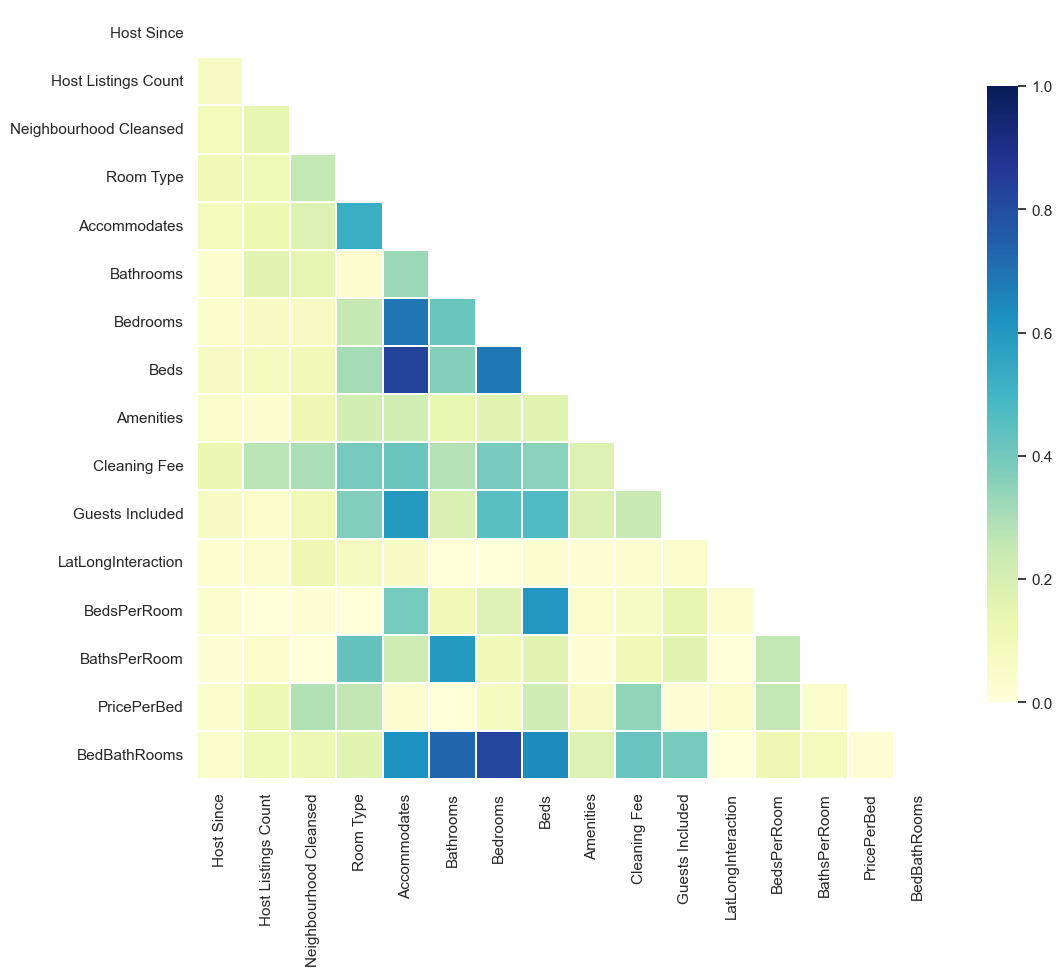

In [141]:
# Analizar correlación con los cambios
data = data_train.select_dtypes(include=[np.number])
corr = np.abs(data.drop(['Price'], axis=1).corr())

mask = np.zeros_like(corr, dtype = bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

In [142]:
corr_matrix = data_train.select_dtypes(include=[np.number]).corr()
print(corr_matrix["Price"].sort_values(ascending=False))

Price                     1.000000
Cleaning Fee              0.689744
Accommodates              0.572874
BedBathRooms              0.567828
PricePerBed               0.560153
Bedrooms                  0.519410
Beds                      0.474187
Room Type                 0.469757
Guests Included           0.374546
Neighbourhood Cleansed    0.354200
Bathrooms                 0.347137
Amenities                 0.213631
Host Listings Count       0.191909
BedsPerRoom               0.087661
Host Since                0.080965
LatLongInteraction       -0.044289
BathsPerRoom             -0.162766
Name: Price, dtype: float64


In [79]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

In [143]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10497 entries, 0 to 10608
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Host Since              10497 non-null  float64
 1   Host Listings Count     10497 non-null  float64
 2   Neighbourhood Cleansed  10497 non-null  float64
 3   Room Type               10497 non-null  float64
 4   Accommodates            10497 non-null  int64  
 5   Bathrooms               10497 non-null  float64
 6   Bedrooms                10497 non-null  float64
 7   Beds                    10497 non-null  float64
 8   Amenities               10497 non-null  float64
 9   Price                   10497 non-null  float64
 10  Cleaning Fee            10497 non-null  float64
 11  Guests Included         10497 non-null  int64  
 12  LatLongInteraction      10497 non-null  float64
 13  BedsPerRoom             10497 non-null  float64
 14  BathsPerRoom            10497 non-null  flo

### Escalado de características y transformación

Dividir en `x` y en `Y`:

In [144]:
# Ver el índice de la columna 'Price'
price_index = data_train.columns.get_loc('Price')
price_index

9

In [145]:
from sklearn import preprocessing

data = data_train.values

y_train = data[:, price_index] # Extraemos la columna 'Price' usando su índice numérico
X_train = np.delete(data, price_index, axis=1)  # Eliminamos price_index de la matriz

feature_names = np.delete(data_train.columns.values, price_index)

# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

In [146]:
feature_names

array(['Host Since', 'Host Listings Count', 'Neighbourhood Cleansed',
       'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds',
       'Amenities', 'Cleaning Fee', 'Guests Included',
       'LatLongInteraction', 'BedsPerRoom', 'BathsPerRoom', 'PricePerBed',
       'BedBathRooms'], dtype=object)

## 4. Modelado

- Cross validation
- Evaluación; mejor si lo hacéis de más de un modelo, porque así podéis comparar entre ellos.

In [84]:
data_test = pd.read_csv('./test.csv', sep=';', decimal='.')

### Aplicar las mismas transformaciones que en train

In [85]:
# Añadir nuevas características
data_test['LatLongInteraction']  = data_test['Latitude'] * data_test['Longitude']
data_test['BedsPerRoom'] = data_test.apply(lambda row: row['Beds'] / row['Bedrooms'] if row['Bedrooms'] > 0 else 0, axis=1)
data_test['BathsPerRoom'] = data_test.apply(lambda row: row['Bathrooms'] / row['Bedrooms'] if row['Bedrooms'] > 0 else 0, axis=1)
data_test['PricePerBed'] = data_test['Price'] / data_test['Beds']
data_test['BedBathRooms'] = data_test['Bedrooms'] * data_test['Bathrooms']
data_test['Stay Duration'] = data_test.apply(lambda row: classify_stay(row['Minimum Nights'], row['Maximum Nights']), axis=1)

# Filtramos outliers
data_test = filter_data(data_test) 

# Eliminamos columnas
columns_to_drop = [
    'ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Calendar last Scraped',
    'License', 'Jurisdiction Names', 'Host URL', 'Host About', 'Name', 'Summary',
    'Space', 'Description', 'Notes', 'Neighborhood Overview', 'Transit', 'Access',
    'Interaction', 'House Rules', 'Thumbnail Url', 'Medium Url', 'Picture Url',
    'XL Picture Url', 'Host Thumbnail Url', 'Host Picture Url', 'Host Acceptance Rate',
    'Has Availability', 'Host Total Listings Count', 'Geolocation', 'Neighbourhood',
    'Host ID', 'Host Name', 'Host Location', 'Host Neighbourhood', 'Host About',
    'Host Total Listings Count', 'Experiences Offered', 'Street', 'City', 'State',
    'Country Code', 'Country', 'Market', 'Smart Location', 'Latitude', 'Longitude', 'Zipcode',
    'Host Response Time', 'Square Feet', 'Weekly Price', 'Monthly Price', 'Security Deposit',
    'Availability 30', 'Availability 60', 'Availability 90', 'Availability 365', 'Minimum Nights',
    'Maximum Nights', 'Calendar Updated', 'Geolocation', 'Number of Reviews', 
    'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Rating',
    'Review Scores Checkin', 'Review Scores Communication', 'Review Scores Location',
    'Review Scores Value', 'Reviews per Month', 'Calculated host listings count',
    'Host Response Rate', 'First Review', 'Last Review'
]
data_test = data_test.drop(columns_to_drop, axis=1)

# Codificación de variables
data_test['Host Since'] = pd.to_datetime(data_test['Host Since'])
data_test['Host Since'] = (pd.Timestamp.now().normalize() - data_test['Host Since']).dt.days
data_test['Host Verifications'] = data_test['Host Verifications'].apply(lambda x: len(x.split(',')) if pd.notna(x) else 0)
data_test['Bed Type'] = (data_test['Bed Type'] == 'Real Bed').astype(int)
data_test['Amenities'] = data_test['Amenities'].dropna().str.split(',').apply(len)
data_test['Features'] = data_test['Features'].dropna().str.split(',').apply(len)

# Mean Encoder
data_test['Property Type'] = group_property_type(data_test)
categorical = ['Neighbourhood Cleansed', 'Neighbourhood Group Cleansed', 'Property Type', 'Room Type']
for c in categorical:
    data_test[c] = data_test[c].map(mean_map[c])
    
# Ordinal Encoder
data_test['Cancellation Policy'] = data_test['Cancellation Policy'].replace(['super_strict_60', 'super_strict_30'], 'super_strict')
categories = [['flexible', 'moderate', 'strict', 'super_strict']]
ordinal_encoder = OrdinalEncoder(categories=categories)
data_test['Cancellation Policy'] = ordinal_encoder.fit_transform(data_test[['Cancellation Policy']])

# KNNImputer
X_imputed = imputer.fit_transform(data_test[columns_to_impute])
data_test_imputed = pd.DataFrame(X_imputed, columns=columns_to_impute,index=data_test.index)
data_test.update(data_test_imputed)

In [94]:
# Eliminamos más columnas del modelo (después de Lasso)
columns_to_drop_2 = ['Host Verifications', 'Stay Duration']
data_test = data_test.drop(columns_to_drop_2, axis=1)

In [147]:
# Eliminamos más columnas del modelo (tras el 2º análisis)
columns_to_drop_3 = ['Features','Bed Type','Cancellation Policy','Extra People','Neighbourhood Group Cleansed','Property Type']
data_test = data_test.drop(columns_to_drop_3, axis=1)

In [148]:
# Verificamos que no hay datos faltantes y que son características numéricas 
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2619 entries, 0 to 2652
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Host Since              2619 non-null   float64
 1   Host Listings Count     2619 non-null   float64
 2   Neighbourhood Cleansed  2619 non-null   float64
 3   Room Type               2619 non-null   float64
 4   Accommodates            2619 non-null   int64  
 5   Bathrooms               2619 non-null   float64
 6   Bedrooms                2619 non-null   float64
 7   Beds                    2619 non-null   float64
 8   Amenities               2619 non-null   float64
 9   Price                   2619 non-null   float64
 10  Cleaning Fee            2619 non-null   float64
 11  Guests Included         2619 non-null   int64  
 12  LatLongInteraction      2619 non-null   float64
 13  BedsPerRoom             2619 non-null   float64
 14  BathsPerRoom            2619 non-null   float

In [149]:
# Sacamos los datos de test
data_test_values = data_test.values
y_test = data_test_values[:, price_index]   
X_test = np.delete(data_test_values, price_index, axis=1)

feature_names_test = np.delete(data_test.columns.values, price_index)

# Esta normalización/escalado se realiza con el scaler anterior, basado en los datos de training!
XtestScaled = scaler.transform(X_test) 

### Definir una función para calcular múltiples métricas

In [88]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def compute_metrics(y_true, y_pred):
    metrics = {
        'MAE': round(mean_absolute_error(y_true, y_pred),3),
        'MSE': round(mean_squared_error(y_true, y_pred),3),
        'RMSE': round(mean_squared_error(y_true, y_pred, squared=False),3),
        'R2': round(r2_score(y_true, y_pred),3)
    }
    return metrics

### Selección de Características - Lasso

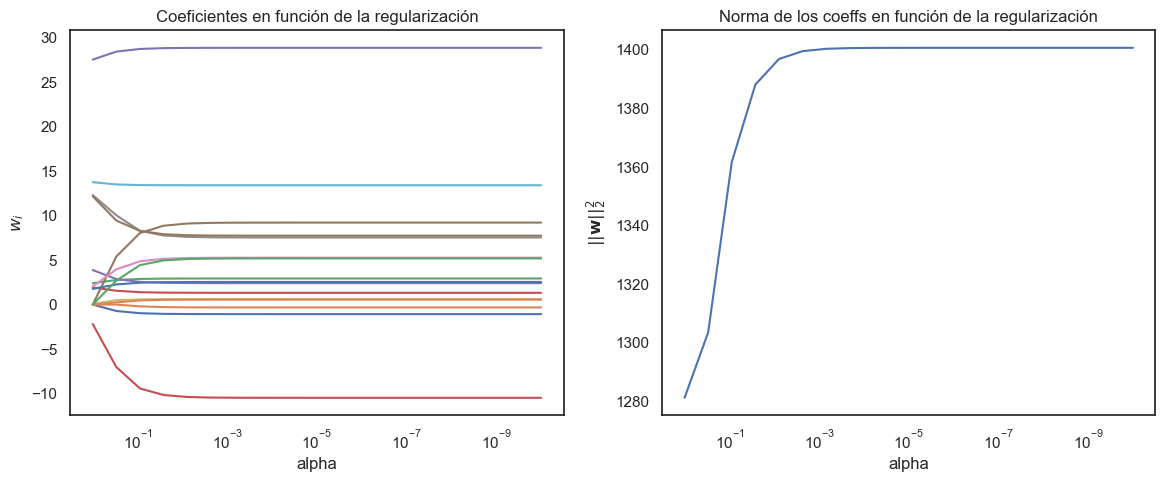

In [150]:
from sklearn.linear_model import Lasso

n_alphas = 20
alphas = np.logspace(-10, 0, n_alphas)

coefs = []

norm2_coefs = []
for a in alphas:
    lasso = Lasso(alpha=a).fit(XtrainScaled, y_train)
    coefs.append(lasso.coef_)
    norm2_coefs.append(np.dot(lasso.coef_,lasso.coef_.T))

plt.figure(figsize=(14, 5))

ax = plt.subplot(1, 2, 1)
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('$w_i$')
plt.title('Coeficientes en función de la regularización')
plt.axis('tight')


ax = plt.subplot(1, 2, 2)
ax.plot(alphas, norm2_coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('$||\mathbf{w}||^2_2$')
plt.title('Norma de los coeffs en función de la regularización')
plt.axis('tight')
plt.show()

La primera gráfica muestra cómo los coeficientes individuales del modelo varían con diferentes valores de alpha. En un modelo Lasso, a medida que alpha aumenta, más coeficientes se reducirán a cero. Los coeficientes que caen a cero indican que Lasso ha eliminado esas características del modelo, considerándolas no informativas o redundantes.

La segunda gráfica muestra cómo la suma total de los valores absolutos de los coeficientes disminuye a medida que alpha aumenta, lo que indica que el modelo está siendo más regularizado y, por lo tanto, se vuelve más simple.

Estas gráficas sugieren que el modelo Lasso está haciendo lo que se espera: penaliza los coeficientes, empujándolos hacia cero y posiblemente eliminando características que no contribuyen significativamente a la predicción del modelo.

best parameters: {'alpha': 0.01778279410038923}


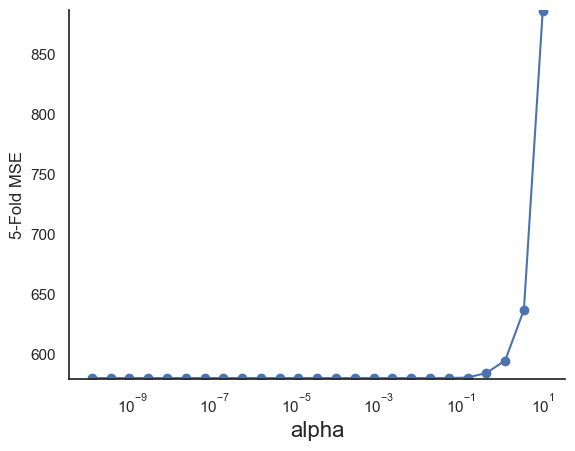

In [151]:
from sklearn.model_selection import GridSearchCV

alpha_vector = np.logspace(-10,1,25)

param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 5)
grid.fit(XtrainScaled, y_train)
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.ylim(min(scores) - 1, max(scores) + 1)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [152]:
lasso = Lasso(alpha=0.01778279410038923)  # Reemplazar con el valor de alpha anterior
lasso.fit(XtrainScaled, y_train)

# Obtener los coeficientes
lasso_coefs = lasso.coef_

# Identificar las características que el modelo Lasso ha reducido a cero
features_to_remove = [feature for feature, coef in zip(feature_names, lasso_coefs) if coef == 0]

print("Características para eliminar:", features_to_remove)

Características para eliminar: []


In [153]:
print("Train: ",lasso.score(XtrainScaled,y_train))
print("Test: ",lasso.score(XtestScaled,y_test))

Train:  0.8154816001821197
Test:  0.8252591851752692


MAE: 12.408
MSE: 505.83
RMSE: 22.491
R2: 0.825


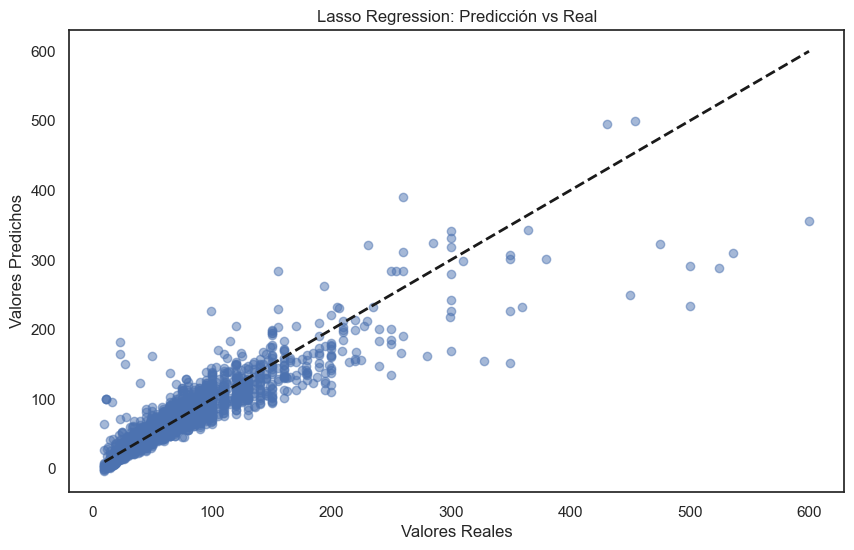

In [154]:
y_pred = lasso.predict(XtestScaled)

# Métricas
metrics = compute_metrics(y_test, y_pred)

for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value}")

# Plotting the predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Lasso Regression: Predicción vs Real')

plt.show()

**MAE (Mean Absolute Error):** Si los precios oscilan entre 0 y 600, un MAE de 12.57 podría considerarse razonablemente bajo.

**MSE (Mean Squared Error):** Similar al MAE pero penaliza más los errores grandes. Un MSE de 522.15 es bastante más alto que el MAE debido a esta penalización. Si la mayoría de los precios están cerca del límite inferior del rango (cerca de 0), un MSE de más de 500 podría ser muy alto. 

**RMSE (Root Mean Squared Error):** Un RMSE de 22.85 indica que, en promedio, las predicciones del modelo se desvían aproximadamente 22.85 unidades del valor real, lo cual proporciona una mejor idea de la magnitud de los errores que el MSE debido a que está en las mismas unidades que los precios.

**R2 (R-squared):** El R2 es una medida de qué tan bien las predicciones del modelo se correlacionan con los valores reales. Un valor de 0.819 (o 81.9%) es bastante alto, lo que sugiere que este modelo explica alrededor del 81.9% de la variabilidad en el precio. Un valor alto de R2 no necesariamente significa que el modelo es bueno para hacer predicciones precisas en datos nuevos.

In [155]:
# ElasticNetCV - maneja la multicolinealidad mejor que Lasso
from sklearn.linear_model import ElasticNetCV

enet = ElasticNetCV(cv=5, random_state=0).fit(XtrainScaled, y_train)
y_pred_enet = enet.predict(XtestScaled)

# Métricas
metrics = compute_metrics(y_test, y_pred)

for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value}")

MAE: 12.408
MSE: 505.83
RMSE: 22.491
R2: 0.825


In [116]:
print("Train: ",enet.score(XtrainScaled,y_train))
print("Test: ",enet.score(XtestScaled,y_test))

Train:  0.8156313565387212
Test:  0.825079800905857


Dado que ElasticNet equilibra entre Lasso y Ridge, observamos que se obtiene un conjunto de métricas igual al de Lasso. Esto podría explicarse porque los datos son más adecuados para la penalización L1 o porque el mejor parámetro de mezcla encontrado en la validación cruzada está más sesgado hacia Lasso.

### Linear Regression

In [156]:
from sklearn.linear_model import LinearRegression

# Entrenar el modelo de regresión lineal
lr = LinearRegression().fit(XtrainScaled, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = lr.predict(XtestScaled)

# Métricas
metrics = compute_metrics(y_test, y_pred)

for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value}")

# Mostrar los coeficientes del modelo
print('Intercepto (w0):', lr.intercept_)
print('Coeficientes (w1, w2, ..., wn):', lr.coef_)

# Calcular la norma L2 al cuadrado de los coeficientes (sin incluir el intercepto)
norm_w2 = np.dot(lr.coef_,lr.coef_.T) 
print(f'\n||w||_2^2 = {norm_w2:.2g}')

MAE: 12.415
MSE: 505.786
RMSE: 22.49
R2: 0.825
Intercepto (w0): 65.7782414023054
Coeficientes (w1, w2, ..., wn): [ -1.07012948  -0.31977824   2.93189686   1.32212255   2.40605079
   9.20571351   5.26664076   7.53438872   0.61977756  13.39736857
   2.54196563   0.56047219   5.18524856 -10.46423407  28.82881597
   7.73956604]

||w||_2^2 = 1.4e+03


In [157]:
print("Train: ",lr.score(XtrainScaled,y_train))
print("Test: ",lr.score(XtestScaled,y_test))

Train:  0.8154845311576571
Test:  0.8252743029936962


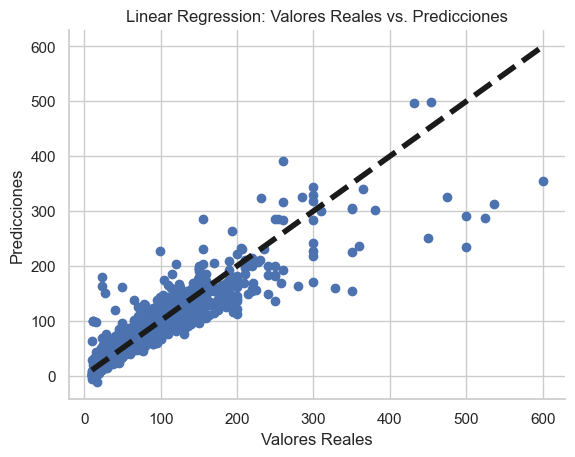

In [118]:
# Gráfico de predicciones vs valores reales
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title(f'Linear Regression: Valores Reales vs. Predicciones')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

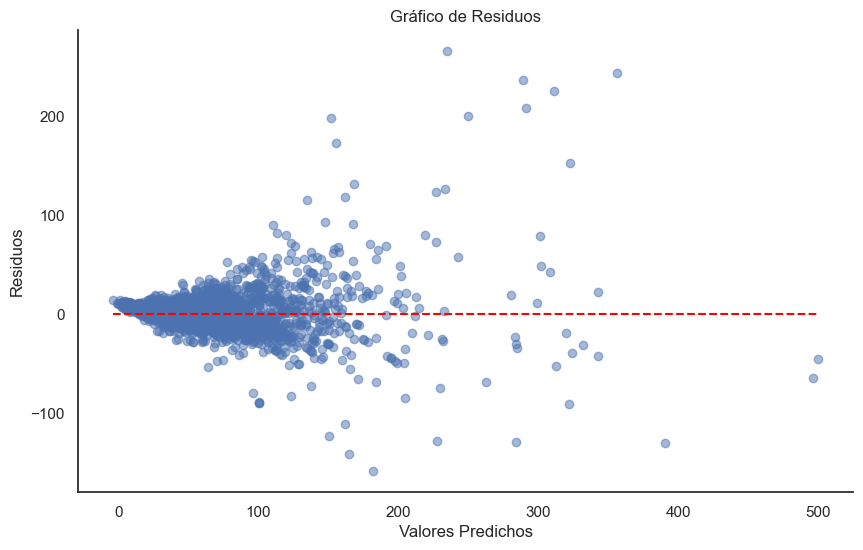

In [158]:
residuos = y_test - y_pred

plt.figure(figsize=(10,6))
plt.scatter(y_pred, residuos, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='--')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

La gráfica de residuos muestra una dispersión uniforme alrededor de la línea de cero, lo cual es un indicador positivo de predicciones consistentes. Sin embargo, hay una posible tendencia de **aumento en la varianza de los residuos a medida que los valores predichos se incrementan**, indicando *heterocedasticidad* en los errores del modelo. Esto sugiere que el modelo podría mejorar con transformaciones adecuadas en los datos o técnicas de modelado que ajusten los residuos de manera diferencial.

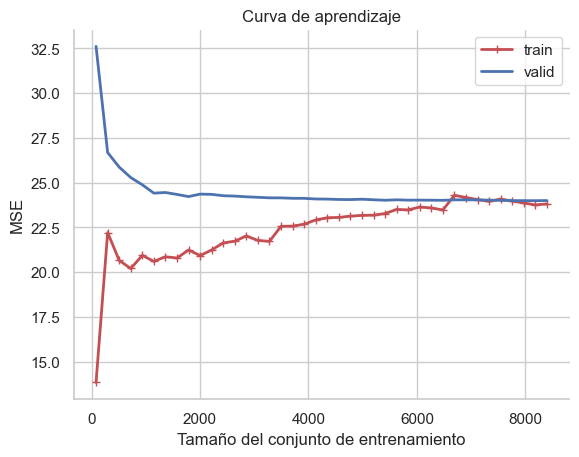

In [120]:
# Curva de Aprendizaje - Traza el error de validación cruzada en función del tamaño del conjunto de entrenamiento
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), XtrainScaled, y_train, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=2, label="valid")
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('MSE')
plt.title('Curva de aprendizaje')
plt.legend()
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Esta curva de aprendizaje nos permite determinar si agregar más datos mejorará el rendimiento del modelo. Si las curvas se estabilizan y la diferencia entre ellas no es significativa (lo que indicaría un buen equilibrio entre sesgo y varianza), agregar más datos puede no ser útil. En su lugar, podríamos pensar en aumentar la complejidad del modelo o mejorar la calidad de los datos actuales.

### Árbol de Decisión *(DecisionTreeRegressor)*

Fitting 3 folds for each of 11 candidates, totalling 33 fits
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END ........................................max_depth=4; total time=   0.0s
[CV] END ........................................max_depth=4; total time=   0.0s
[CV] END .......................................

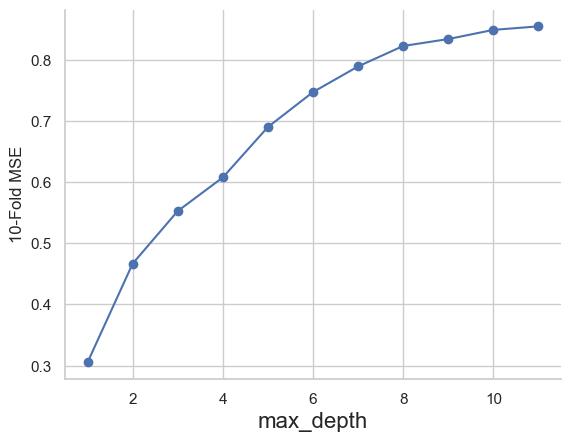

In [121]:
from sklearn.tree import DecisionTreeRegressor

maxDepth = range(1,12)
param_grid = {'max_depth': maxDepth }
grid = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid=param_grid, cv = 3, verbose=2)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth',fontsize=16)
plt.ylabel('10-Fold MSE')
#plt.ylim((-1, 0))
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

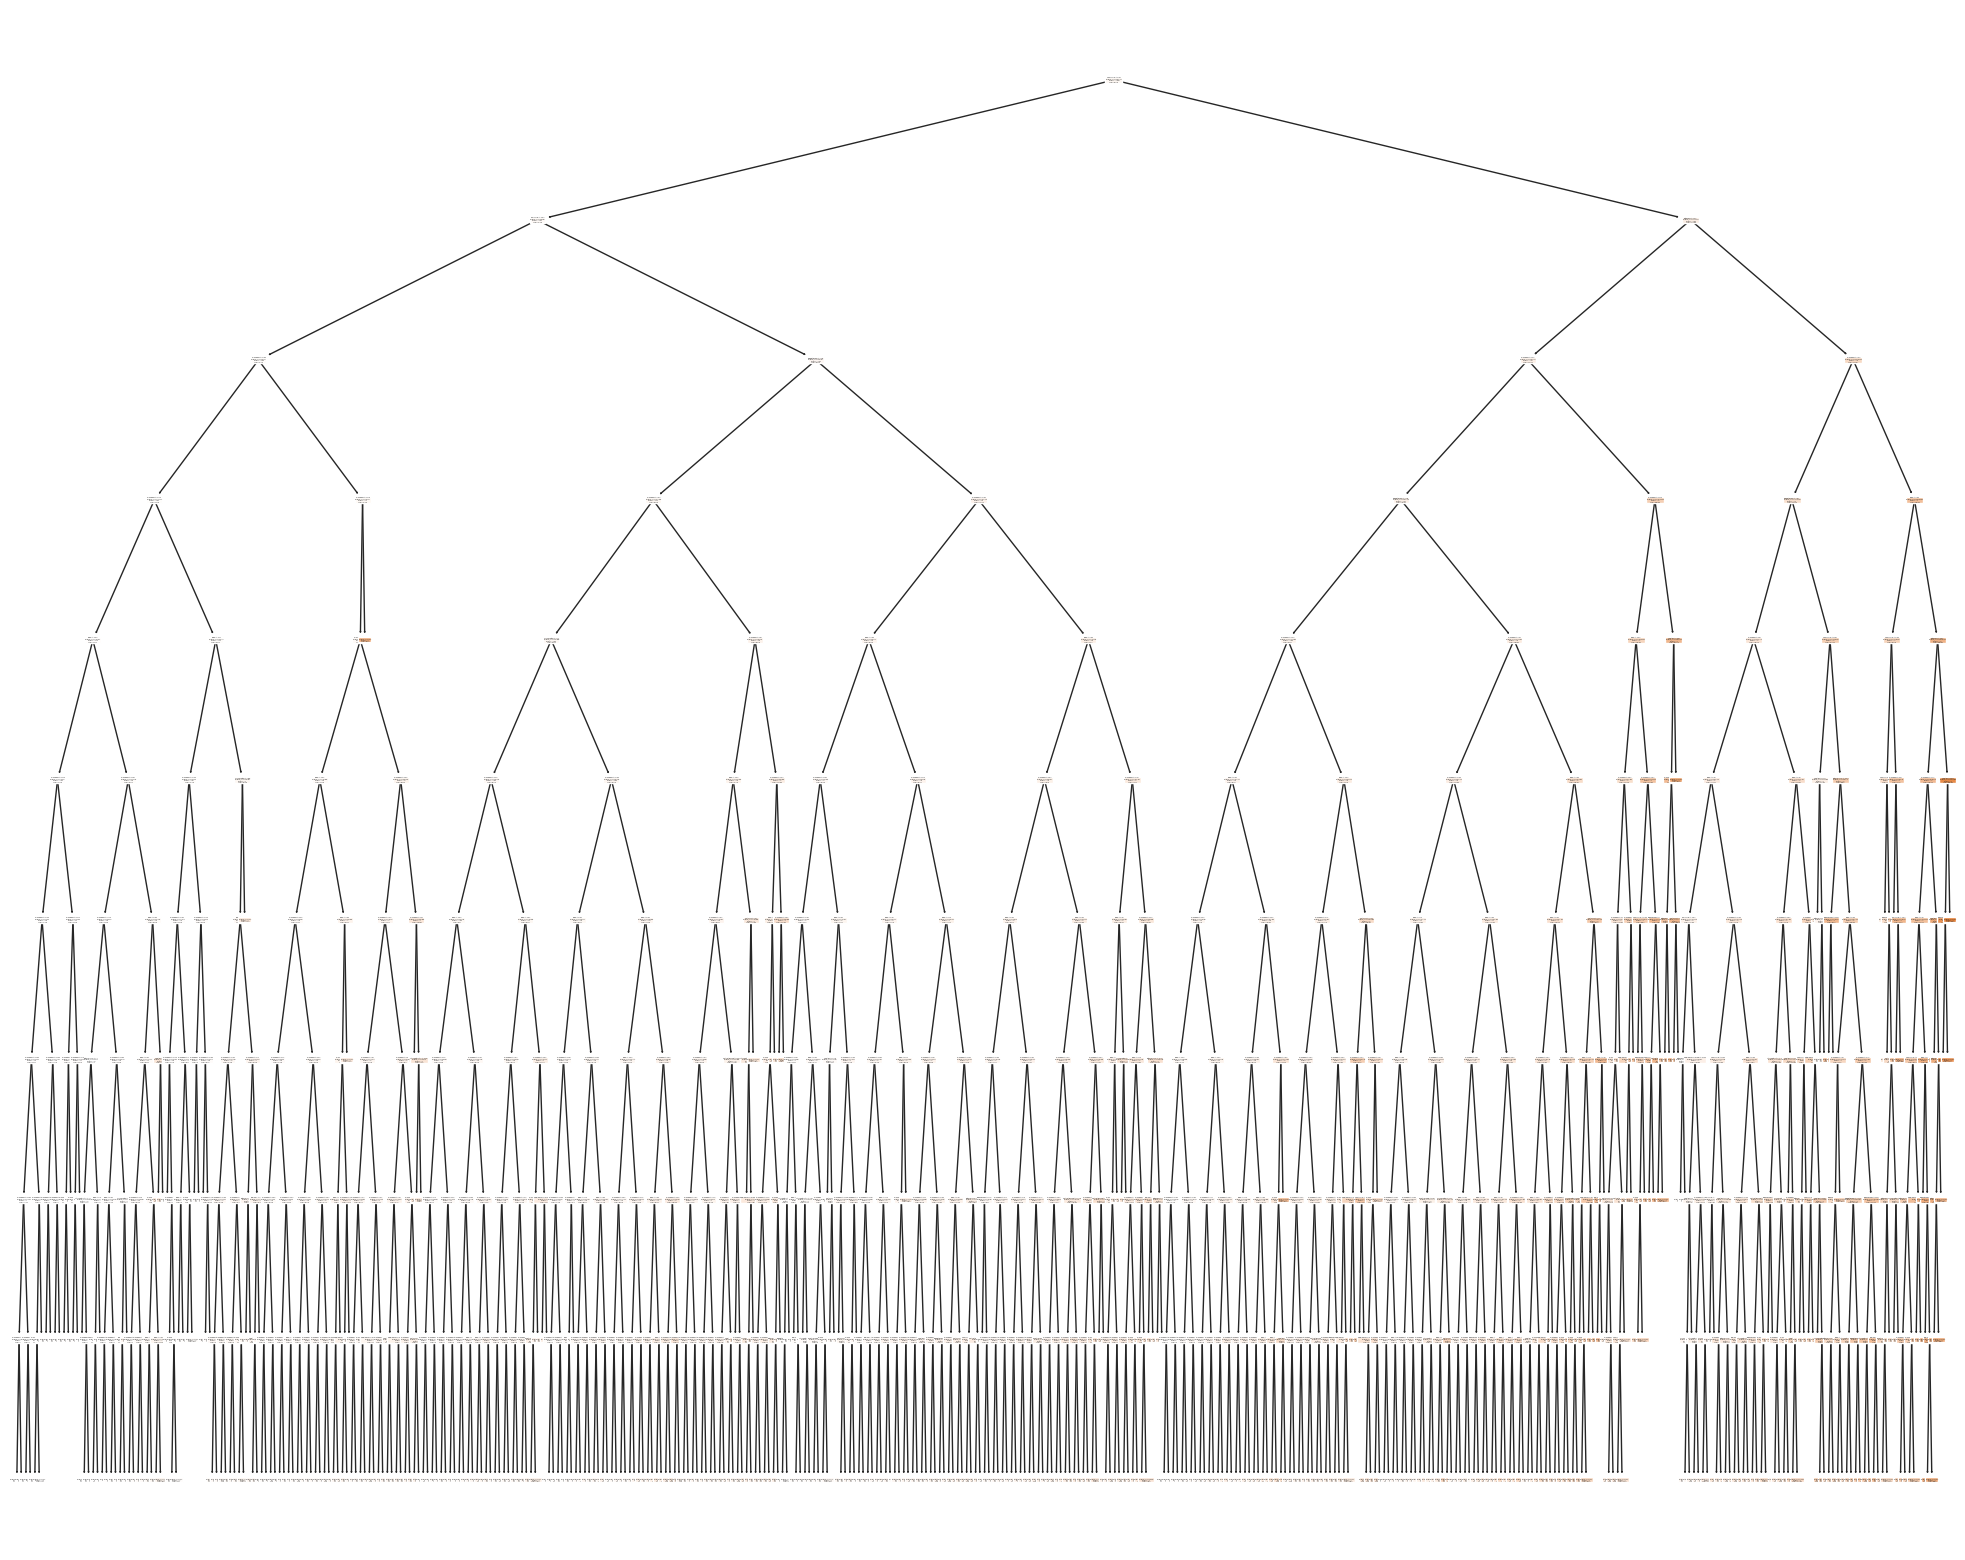

In [159]:
from sklearn import tree

treeModel = DecisionTreeRegressor(max_depth=10).fit(XtrainScaled, y_train)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(treeModel, feature_names=list(feature_names), filled=True)

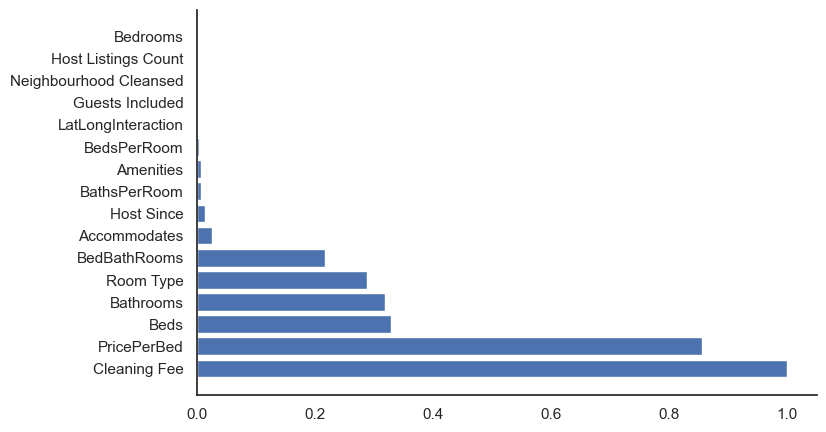

In [160]:
importances = treeModel.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

sns.set_theme(style="white")
plt.figure(figsize=(8,5))
plt.barh(range(XtrainScaled.shape[1]),importances[indices])
plt.yticks(range(XtrainScaled.shape[1]),feature_names[indices])
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [166]:
# Evaluación del Árbol de Decisión
maxDepthOptimo = 11
treeModel = DecisionTreeRegressor(max_depth=maxDepthOptimo).fit(XtrainScaled,y_train)

print("Train: ",treeModel.score(XtrainScaled,y_train))
print("Test: ",treeModel.score(XtestScaled,y_test))

Train:  0.9971661476137205
Test:  0.9565759431334919


MAE: 2.72
MSE: 110.83
RMSE: 10.528
R2: 0.962


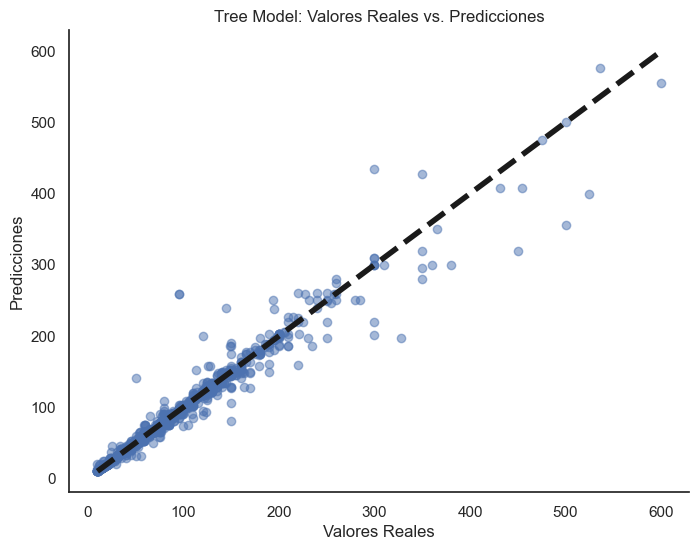

In [126]:
y_pred = treeModel.predict(XtestScaled)

# Métricas
metrics = compute_metrics(y_test, y_pred)

for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Línea de perfecta predicción
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Tree Model: Valores Reales vs. Predicciones')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

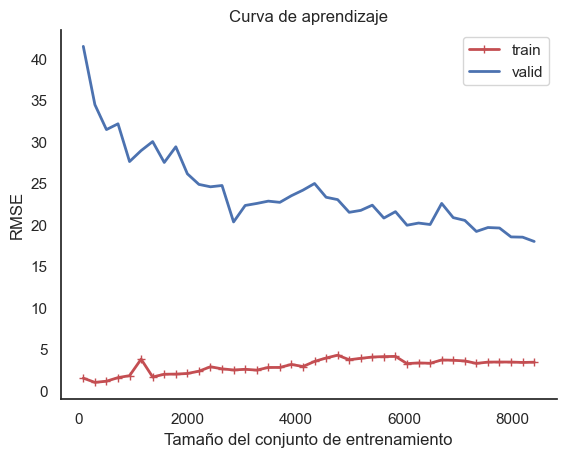

In [127]:
# Curva de Aprendizaje
train_sizes, train_scores, valid_scores = learning_curve(
    treeModel, XtrainScaled, y_train, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=2, label="valid")
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('RMSE')
plt.title('Curva de aprendizaje')
plt.legend()
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Un **MAE** de 3.478 es bastante bajo (en promedio, este modelo se equivoca por aproximadamente 3.478 unidades en sus predicciones).
Un **MSE** de 96.548 y un **RMSE** de 9.826 indican la calidad de los ajustes del modelo y la dispersión de los residuos. Dado que el RMSE es la raíz cuadrada del MSE, proporciona una medida de error en las mismas unidades que la variable objetivo.
Un **R2** de 0.967 es muy alto, lo que implica que este modelo explica aproximadamente el 96.7% de la variabilidad en los datos de prueba.

La diferencia entre las puntuaciones de entrenamiento (0.991) y prueba (0.966) no es muy grande, lo que sugiere que **no hay un sobreajuste significativo.**

<div class = "alert alert-success">
El rendimiento del modelo **DecisionTreeRegressor** parece ser bastante bueno según estas métricas, especialmente en términos de R2, que está muy cerca de 1 (este valor podría ser indicativo de un buen ajuste).
</div>

### Random Forest

Fitting 3 folds for each of 14 candidates, totalling 42 fits
[CV] END ........................................max_depth=1; total time=   0.3s
[CV] END ........................................max_depth=1; total time=   0.3s
[CV] END ........................................max_depth=1; total time=   0.3s
[CV] END ........................................max_depth=2; total time=   0.5s
[CV] END ........................................max_depth=2; total time=   0.5s
[CV] END ........................................max_depth=2; total time=   0.5s
[CV] END ........................................max_depth=3; total time=   0.6s
[CV] END ........................................max_depth=3; total time=   0.6s
[CV] END ........................................max_depth=3; total time=   0.6s
[CV] END ........................................max_depth=4; total time=   0.7s
[CV] END ........................................max_depth=4; total time=   0.7s
[CV] END .......................................

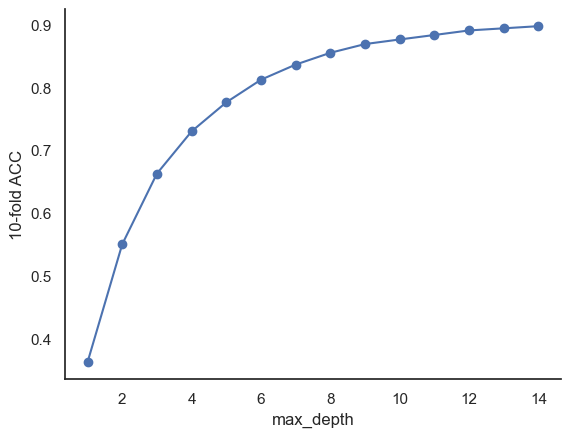

In [171]:
from sklearn.ensemble import RandomForestRegressor

maxDepth = range(1,15)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(
    RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt'), 
    param_grid=tuned_parameters, cv=3, verbose=2) 

grid.fit(XtrainScaled, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

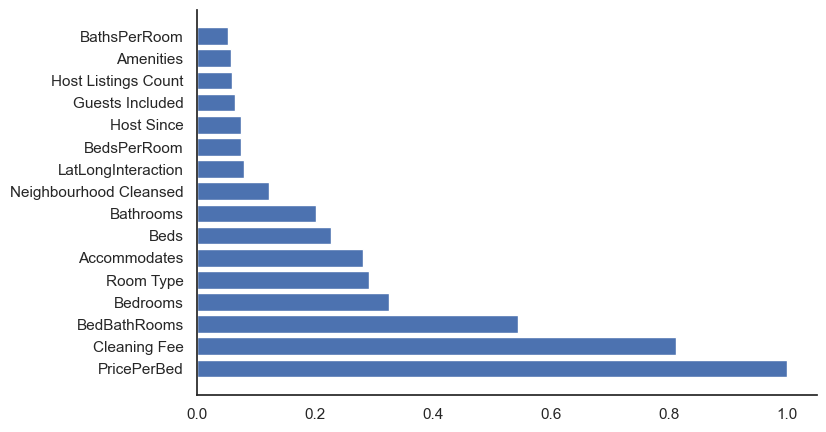

In [172]:
maxDepthOptimo = grid.best_params_['max_depth']
randomForest = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(XtrainScaled,y_train)

importances = randomForest.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

sns.set_theme(style="white")
plt.figure(figsize=(8,5))
plt.barh(range(XtrainScaled.shape[1]),importances[indices])
plt.yticks(range(XtrainScaled.shape[1]),feature_names[indices])
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [173]:
for score, name in zip(randomForest.feature_importances_, feature_names):
    print(round(score,2), name)

0.02 Host Since
0.01 Host Listings Count
0.03 Neighbourhood Cleansed
0.07 Room Type
0.07 Accommodates
0.05 Bathrooms
0.08 Bedrooms
0.05 Beds
0.01 Amenities
0.19 Cleaning Fee
0.02 Guests Included
0.02 LatLongInteraction
0.02 BedsPerRoom
0.01 BathsPerRoom
0.23 PricePerBed
0.13 BedBathRooms


In [174]:
# Evaluación de Random Forest
maxDepthOptimo = grid.best_params_['max_depth']
randomForest = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(XtrainScaled,y_train)

print("Train: ",randomForest.score(XtrainScaled,y_train))
print("Test: ",randomForest.score(XtestScaled,y_test))

Train:  0.9831833465915698
Test:  0.9438753933446635


MAE: 5.818
MSE: 162.466
RMSE: 12.746
R2: 0.944


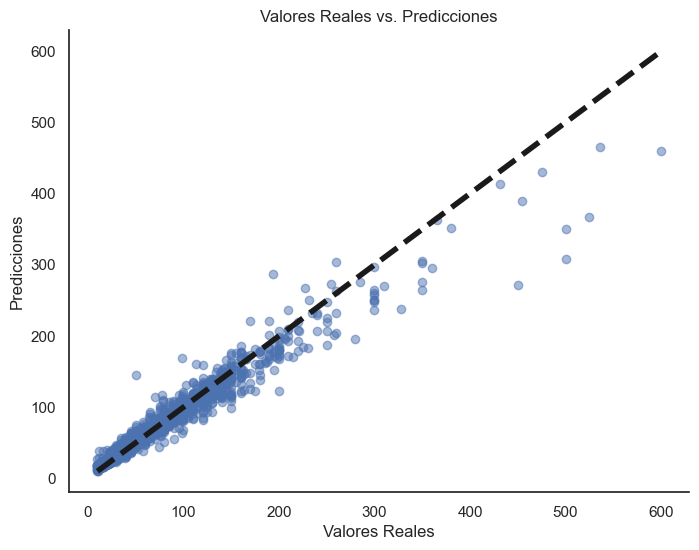

In [175]:
y_pred = randomForest.predict(XtestScaled)

# Métricas
metrics = compute_metrics(y_test, y_pred)

for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Línea de perfecta predicción
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title(f'Valores Reales vs. Predicciones')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

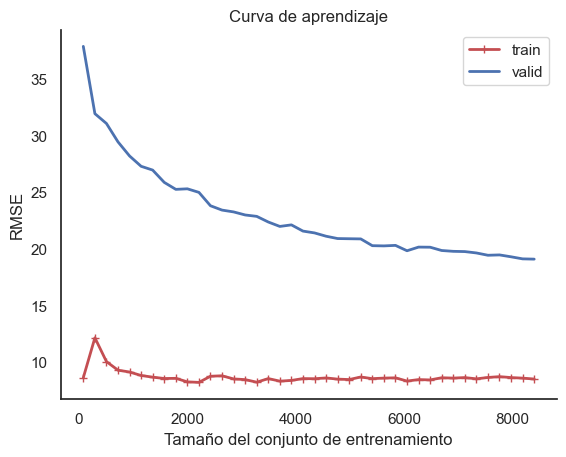

In [133]:
# Curva de Aprendizaje
train_sizes, train_scores, valid_scores = learning_curve(
    randomForest, XtrainScaled, y_train, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=2, label="valid")
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('RMSE')
plt.title('Curva de aprendizaje')
plt.legend()
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

A medida que se añaden más datos, tanto el error de entrenamiento como el de validación disminuyen. El hecho de que el error de validación disminuya y se estabilice a medida que se usan más datos de entrenamiento es una buena señal. La diferencia entre las curvas de entrenamiento y validación parece razonable, lo que indica que el modelo generaliza bien. Sin embargo, un error de validación consistentemente más alto que el error de entrenamiento puede sugerir un sobreajuste leve.

<div class = "alert alert-success">
El modelo Random Forest parece estar rindiendo bien según las métricas, con signos limitados de sobreajuste.
</div>

### Bagging Regressor

Fitting 3 folds for each of 14 candidates, totalling 42 fits


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=1; total time=   0.8s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=1; total time=   0.9s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=1; total time=   0.8s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=2; total time=   1.3s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=2; total time=   1.3s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=2; total time=   1.3s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=3; total time=   1.9s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=3; total time=   1.9s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=3; total time=   1.9s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=4; total time=   2.4s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=4; total time=   2.5s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=4; total time=   2.6s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=5; total time=   3.1s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=5; total time=   2.9s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=5; total time=   2.9s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=6; total time=   3.5s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=6; total time=   3.4s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=6; total time=   3.4s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=7; total time=   3.9s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=7; total time=   4.0s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=7; total time=   3.9s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=8; total time=   4.4s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=8; total time=   4.4s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=8; total time=   4.7s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=9; total time=   5.0s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=9; total time=   4.9s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END ........................base_estimator__max_depth=9; total time=   5.2s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END .......................base_estimator__max_depth=10; total time=   5.5s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END .......................base_estimator__max_depth=10; total time=   5.5s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END .......................base_estimator__max_depth=10; total time=   5.5s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END .......................base_estimator__max_depth=11; total time=   5.7s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END .......................base_estimator__max_depth=11; total time=   5.9s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END .......................base_estimator__max_depth=11; total time=   5.7s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END .......................base_estimator__max_depth=12; total time=   6.1s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END .......................base_estimator__max_depth=12; total time=   6.1s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END .......................base_estimator__max_depth=12; total time=   5.9s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END .......................base_estimator__max_depth=13; total time=   6.4s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END .......................base_estimator__max_depth=13; total time=   6.4s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END .......................base_estimator__max_depth=13; total time=   6.3s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END .......................base_estimator__max_depth=14; total time=   6.4s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END .......................base_estimator__max_depth=14; total time=   6.5s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END .......................base_estimator__max_depth=14; total time=   6.2s


/Users/rociobenitezgarcia/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:929: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  clone(base_estimator).set_params(**self.best_params_)


best mean cross-validation score: 0.931
best parameters: {'base_estimator__max_depth': 14}


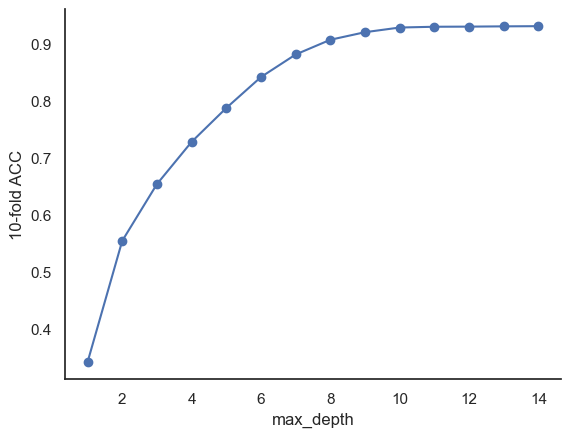

In [176]:
from sklearn.ensemble import BaggingRegressor

maxDepth = range(1,15)
tuned_parameters = {'base_estimator__max_depth': maxDepth}

grid = GridSearchCV(
    BaggingRegressor(estimator=DecisionTreeRegressor(), random_state=0, n_estimators=200), 
    param_grid=tuned_parameters, cv=3, verbose=2) 

grid.fit(XtrainScaled, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [177]:
# Evaluación de Baging Regressor
maxDepthOptimo = grid.best_params_['base_estimator__max_depth']
#maxDepthOptimo = 9
baggingModel = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=maxDepthOptimo),n_estimators=200).fit(XtrainScaled,y_train)

print("Train: ", baggingModel.score(XtrainScaled,y_train))
print("Test: ", baggingModel.score(XtestScaled,y_test))

Train:  0.992663296332992
Test:  0.9752735476497003


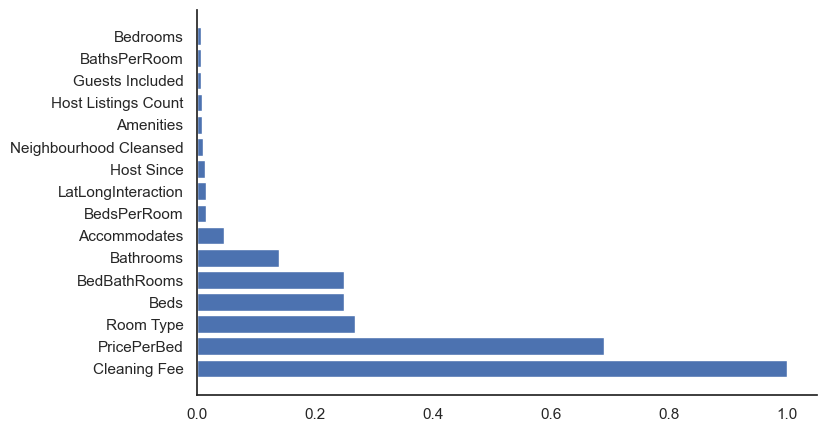

In [178]:
importances = np.mean([tree.feature_importances_ for tree in baggingModel.estimators_], axis=0)
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

sns.set_theme(style="white")
plt.figure(figsize=(8,5))
plt.barh(range(XtrainScaled.shape[1]),importances[indices])
plt.yticks(range(XtrainScaled.shape[1]),feature_names[indices])
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

MAE: 1.572
MSE: 71.577
RMSE: 8.46
R2: 0.975


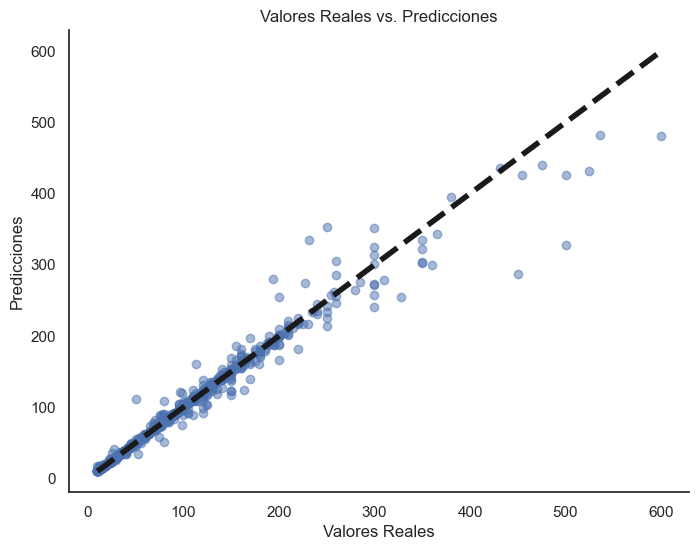

In [179]:
y_pred = baggingModel.predict(XtestScaled)

# Métricas
metrics = compute_metrics(y_test, y_pred)

for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Línea de perfecta predicción
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title(f'Valores Reales vs. Predicciones')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

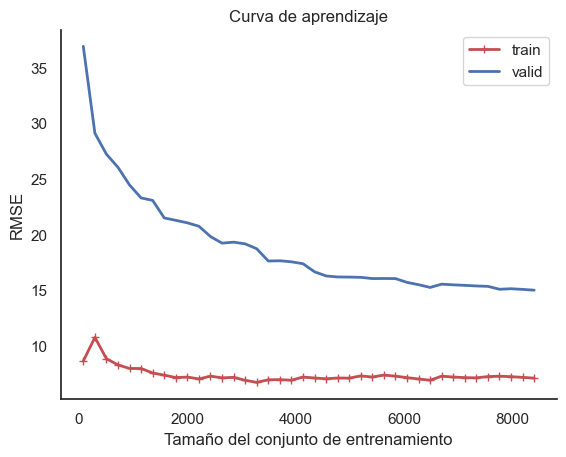

In [138]:
# Curva de Aprendizaje
train_sizes, train_scores, valid_scores = learning_curve(
    baggingModel, XtrainScaled, y_train, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=2, label="valid")
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('RMSE')
plt.title('Curva de aprendizaje')
plt.legend()
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

<div class = "alert alert-success">
Los resultados del Bagging Regressor son sólidos y sugieren un modelo bien ajustado.
</div>

Un **R2 de 0.97** indica que el modelo puede explicar el 97% de la variabilidad en los datos de prueba, lo cual es excelente. Los **valores bajos de MAE y RMSE** indican que los errores de predicción son pequeños en promedio. La diferencia entre las métricas de entrenamiento y prueba no es muy grande, lo que sugiere que **no hay un sobreajuste significativo.**

### Gradient Boosting Regressor

In [180]:
from sklearn.ensemble import GradientBoostingRegressor

Niterations = [500, 1000, 1500, 2000]
learningRate = [0.1, 0.05]
# mantenemos max_depth estático: max_depth=3

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }

grid = GridSearchCV(
    GradientBoostingRegressor(random_state = 0, max_depth = 3), 
    param_grid=param_grid, cv = 5, verbose = 2)

grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ................learning_rate=0.1, n_estimators=500; total time=   8.0s
[CV] END ................learning_rate=0.1, n_estimators=500; total time=   8.2s
[CV] END ................learning_rate=0.1, n_estimators=500; total time=   8.2s
[CV] END ................learning_rate=0.1, n_estimators=500; total time=   8.1s
[CV] END ................learning_rate=0.1, n_estimators=500; total time=   8.1s
[CV] END ...............learning_rate=0.1, n_estimators=1000; total time=  15.9s
[CV] END ...............learning_rate=0.1, n_estimators=1000; total time=  16.0s
[CV] END ...............learning_rate=0.1, n_estimators=1000; total time=  15.8s
[CV] END ...............learning_rate=0.1, n_estimators=1000; total time=  15.8s
[CV] END ...............learning_rate=0.1, n_estimators=1000; total time=  16.3s
[CV] END ...............learning_rate=0.1, n_estimators=1500; total time=  24.1s
[CV] END ...............learning_rate=0.1, n_esti

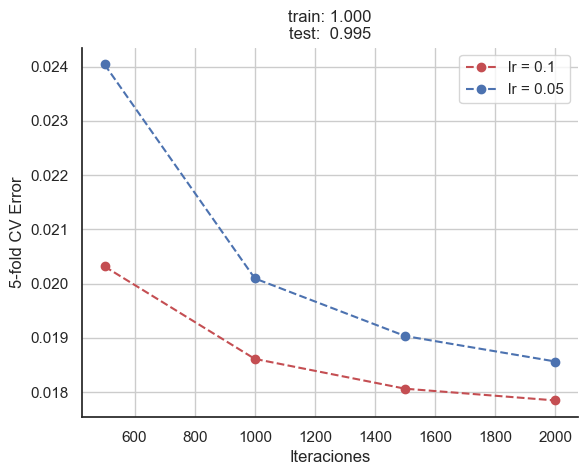

In [181]:
# Gradient Boosting Regressor
lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']
bt = GradientBoostingRegressor(random_state=0, max_depth=3,learning_rate=lrOptimo, n_estimators=neOptimo)
bt.fit(XtrainScaled,y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('Iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(XtrainScaled,y_train),bt.score(XtestScaled,y_test)))
sns.despine(top=True, right=True, left=False, bottom=False)
plt.grid()
plt.show()

In [182]:
print("Train: ", bt.score(XtrainScaled,y_train))
print("Test: ", bt.score(XtestScaled,y_test))

Train:  0.9997283072534239
Test:  0.9947365442926436


MAE: 1.165
MSE: 15.236
RMSE: 3.903
R2: 0.995


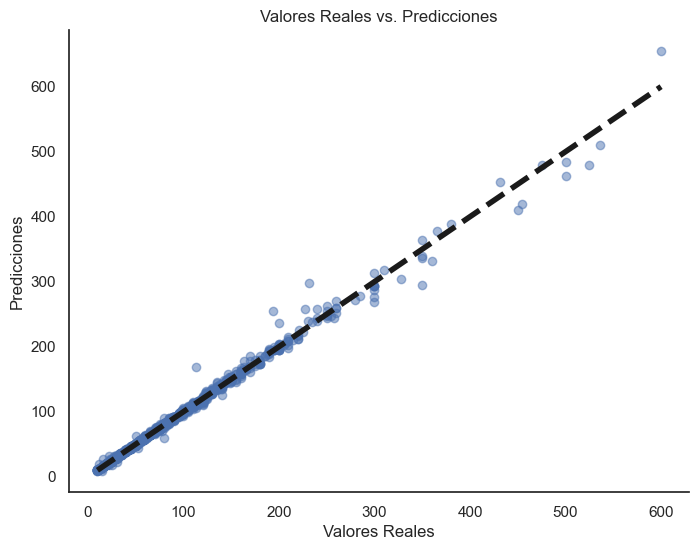

In [184]:
y_pred = bt.predict(XtestScaled)

# Métricas
metrics = compute_metrics(y_test, y_pred)

for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Línea de perfecta predicción
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title(f'Valores Reales vs. Predicciones')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

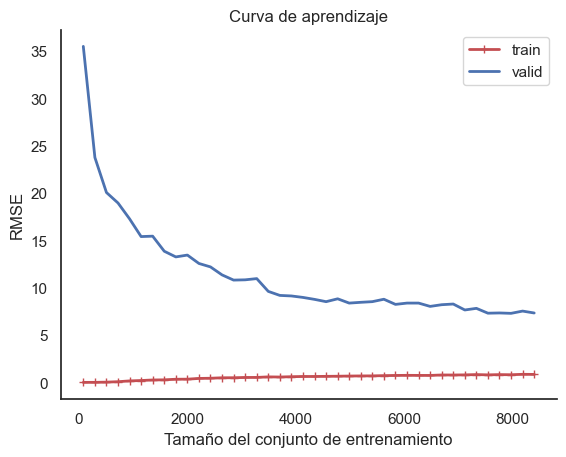

In [185]:
# Curva de Aprendizaje
train_sizes, train_scores, valid_scores = learning_curve(
    bt, XtrainScaled, y_train, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=2, label="valid")
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('RMSE')
plt.title('Curva de aprendizaje')
plt.legend()
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

El modelo *Gradient Boosting Regressor* muestra un excelente desempeño, con un **R² de 0.995** en el conjunto de prueba, lo que indica una sólida capacidad para explicar la variabilidad de los datos y proporcionar predicciones precisas. El **bajo MAE y RMSE** confirman la precisión del modelo, mientras que una **puntuación alta en la validación** cruzada refleja su robustez y buena generalización.

Estos resultados, junto con la cuidadosa selección de hiperparámetros, sugieren que el modelo es altamente efectivo para la tarea de predicción en cuestión. Sin embargo, siempre es prudente realizar una validación adicional para asegurar la consistencia del modelo en diferentes conjuntos de datos.

### SVMs

In [186]:
from sklearn.svm import SVR

vectorC = np.logspace(-2, 2, 10)
vectorG = np.logspace(-5, 1, 8)

param_grid = {'C': vectorC, 'gamma': vectorG}
grid = GridSearchCV(SVR(kernel='rbf'), param_grid=param_grid, cv = 5, verbose=1)
grid.fit(XtrainScaled, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
                         'gamma': array([1.00000000e-05, 7.19685673e-05, 5.17947468e-04, 3.72759372e-03,
       2.68269580e-02, 1.93069773e-01, 1.38949549e+00, 1.00000000e+01])},
             verbose=1)

best mean cross-validation score: 0.927
best parameters: {'C': 100.0, 'gamma': 0.003727593720314938}


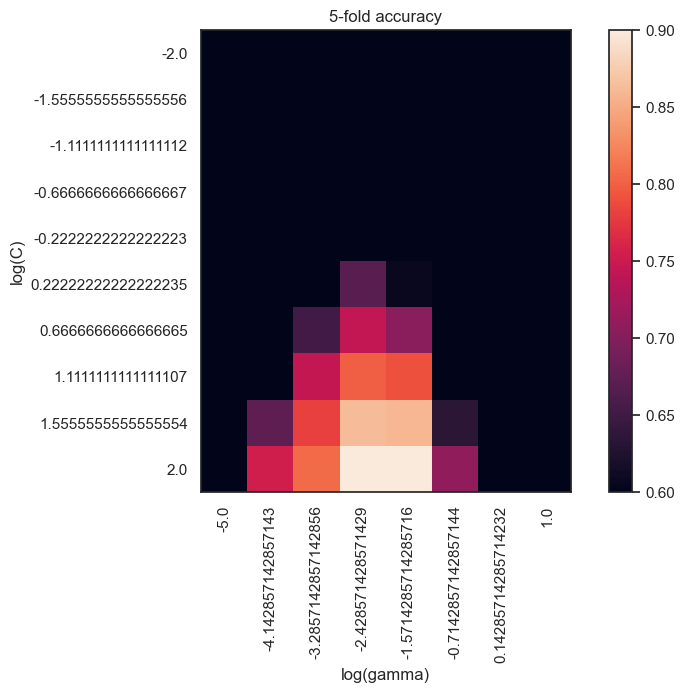

In [187]:
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

# Mostramos prestaciones en CV
scores = grid.cv_results_['mean_test_score'].reshape(len(vectorC),len(vectorG))

plt.figure(figsize=(10,6))
plt.imshow(scores, interpolation='nearest', vmin= 0.6, vmax=0.9)
plt.xlabel('log(gamma)')
plt.ylabel('log(C)')
plt.colorbar()
plt.xticks(np.arange(len(vectorG)), np.log10(vectorG), rotation=90)
plt.yticks(np.arange(len(vectorC)), np.log10(vectorC))
plt.title('5-fold accuracy')
plt.show()

In [188]:
Copt = grid.best_params_['C']
Gopt = grid.best_params_['gamma']

svmModel = SVR(kernel='rbf',gamma = Gopt, C = Copt).fit(XtrainScaled,y_train)
print('Acc (TEST): %0.2f'%svmModel.score(XtestScaled,y_test))

Acc (TEST): 0.96


MAE: 4.121
MSE: 116.13
RMSE: 10.776
R2: 0.96


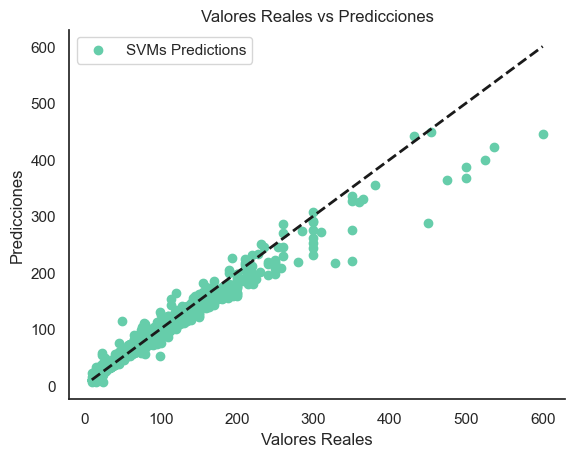

In [189]:
# Predicción
y_pred = svmModel.predict(XtestScaled)

# Métricas
metrics = compute_metrics(y_test, y_pred)

for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value}")

plt.scatter(y_test, y_pred, color='mediumaquamarine', label='SVMs Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Línea de identidad
plt.title(f'Valores Reales vs Predicciones')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.legend()
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [190]:
print("Train: ", svmModel.score(XtrainScaled,y_train))
print("Test: ", svmModel.score(XtestScaled,y_test))

Train:  0.9466135230762418
Test:  0.9598823359046609


El análisis del modelo SVM (Máquinas de Vectores de Soporte) revela un rendimiento notablemente alto en la predicción de los datos, con un coeficiente **R² de 0.96** en el conjunto de prueba, lo que indica una buena capacidad del modelo para explicar la variabilidad de los datos.

Las métricas de error, como el MAE y el RMSE, muestran que las predicciones del modelo tienen un grado razonable de precisión, aunque el RMSE algo elevado sugiere que existen algunos errores de predicción significativos.

Los valores de entrenamiento y prueba están muy alineados, lo que demuestra que el modelo generaliza bien a nuevos datos y no sufre de sobreajuste. La **alta puntuación en la validación cruzada** confirma la robustez del modelo, y los parámetros optimizados indican un ajuste adecuado.

### Kernel Ridge Regression

Mejores parámetros: {'alpha': 0.001, 'gamma': 0.01}
Mejor puntuación (neg_mean_squared_error): 0.9747203739235382
MAE: 0.61
MSE: 6.214
RMSE: 2.493
R2: 0.998


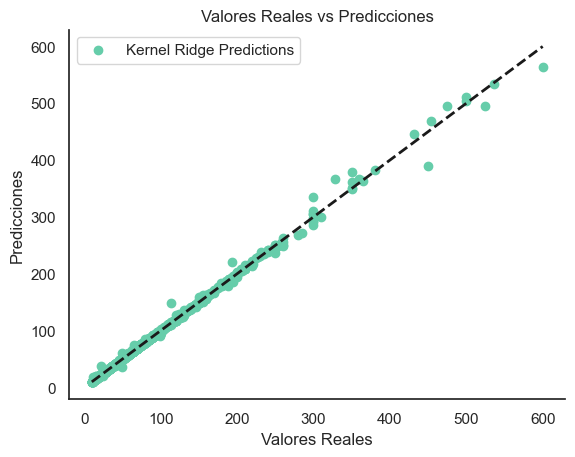

In [201]:
from sklearn.kernel_ridge import KernelRidge

# Definimos y entrenamos el modelo
kr = GridSearchCV(
    KernelRidge(kernel="rbf", gamma=0.1),
    param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3], "gamma": np.logspace(-2, 2, 5)},
)

kr.fit(XtrainScaled, y_train)

# Mejores parámetros y mejor puntuación
print("Mejores parámetros:", kr.best_params_)
print("Mejor puntuación (neg_mean_squared_error):", kr.best_score_)

kr_best = kr.best_estimator_

# Predicción
y_pred = kr.predict(XtestScaled)

# Métricas
metrics = compute_metrics(y_test, y_pred)

for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value}")

plt.scatter(y_test, y_pred, color='mediumaquamarine', label='Kernel Ridge Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Línea de identidad
plt.title(f'Valores Reales vs Predicciones')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.legend()
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [202]:
print("Train: ", kr.score(XtrainScaled,y_train))
print("Test: ", kr.score(XtestScaled,y_test))

Train:  0.9990038605388917
Test:  0.9978534759363776


Los resultados obtenidos del modelo Kernel Ridge Regression con los mejores parámetros `{'alpha': 0.001, 'gamma': 0.01}` demuestran un **rendimiento excepcionalmente alto**, evidenciado por un **R² de 0.998** en el conjunto de prueba. Esto indica que el modelo es capaz de explicar prácticamente toda la variabilidad en los precios de los alojamientos.

La puntuación de **validación cruzada de 0.974**, junto con valores bajos de MAE y RMSE, refuerza la precisión y la robustez del modelo. Estos resultados sugieren que este, con la configuración óptima de hiperparámetros, ofrece una herramienta poderosa y precisa para la tarea de predicción en este contexto.

### Comparando modelos

In [ ]:
lr = LinearRegression().fit(XtrainScaled, y_train)
models = [lr, treeModel, randomForest, baggingModel, bt, svmModel, kr]
model_names = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Bagging', 'Boosting', 'SVM', 'KRidge']

# Entrenar y predecir con cada modelo
predictions = {}
for model, name in zip(models, model_names):
    model.fit(XtrainScaled, y_train) 
    predictions[name] = model.predict(XtestScaled)

ncols = 2 # Nº de columnas para subplot
nrows = (len(models) + ncols - 1) // ncols # Nº de filas calculado en base a la cantidad de modelos y el nº de columnas

# Crear una figura y ejes para subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 4 * nrows))
axs = axs.ravel()  # Convertir la matriz de ejes en un array 1D para una fácil iteración

# Trazar cada modelo en su propio subplot y calcular métricas
for idx, (name, y_pred) in enumerate(predictions.items()):
    metrics = compute_metrics(y_test, y_pred)
    metric_text = "\n".join([f"{metric_name}: {metric_value:.2f}" for metric_name, metric_value in metrics.items()])
    
    # Trazar predicciones vs valores reales
    axs[idx].scatter(y_test, y_pred, alpha=0.3)
    axs[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axs[idx].set_title(f'{name}\n{metric_text}', fontsize='9')
    axs[idx].set_xlabel('Valores Reales', fontsize='9')
    axs[idx].set_ylabel('Predicciones', fontsize='9')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, XtrainScaled, y_train, ax, model_name):
    train_sizes, train_scores, test_scores = learning_curve(
        model, XtrainScaled, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_mean_squared_error'
    )
    
    # Calcula la media y el intervalo de confianza del score de entrenamiento y de prueba para cada tamaño de conjunto de entrenamiento
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Grafica las curvas de aprendizaje
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    # Rellena entre las desviaciones estándar
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # Etiquetas y leyendas
    ax.set_title('Curva de aprendizaje: ' + model_name)
    ax.set_xlabel('Tamaño del conjunto de entrenamiento')
    ax.set_ylabel('MSE Negativo')
    ax.legend(loc="best")

# Crea una figura para graficar
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # Ajusta según la cantidad de modelos que tienes

# Lista de modelos a evaluar
models = [
    (lr, 'Regresión Lineal'),
    (treeModel, 'Árbol de Decisión'),
    (randomForest, 'Random Forest'),
    (baggingModel, 'Bagging'),
    (bt, 'Boosting'),
    (svmModel, 'SVM'),
    (kr, 'kRidge')
]

# Grafica las curvas de aprendizaje de cada modelo
for ax, (model, name) in zip(axes.flatten(), models):
    plot_learning_curve(model, XtrainScaled, y_train, ax, name)

plt.tight_layout()
plt.show()

### 5. Conclusión

Escrita, no numérica; un par de líneas es más que suficiente

<div class = "alert alert-success">
 La comparación de modelos ha revelado que tanto el <b>Gradient Boosting Regressor</b> como el <b>Kernel Ridge Regression</b> se destacan por su alta precisión y confiabilidad, con un <b>R² cercano a 0.995 y 0.998</b> en el conjunto de prueba, respectivamente. Ambos modelos exhiben <b>bajas métricas de error</b> y un <b>desempeño robusto en la validación cruzada</b>, destacando su capacidad para predecir precios de alojamientos con gran exactitud. La selección óptima de hiperparámetros ha sido clave en su éxito, sugiriendo que, con una validación adicional, ambos modelos podrían ofrecer predicciones consistentes y confiables en aplicaciones prácticas.
</div>